# [CASE STUDY] BERTopic extraction for interval data

In [2]:
import pandas as pd
from bertopic import BERTopic
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [250]:
df = pd.read_json("data.json", orient='index')
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month

In [251]:
df2021 = df[df['year'] == 2021]
df2022 = df[df['year'] == 2022]

## Optimizing BERTopic

In [252]:
#df is sorted by handle, we want it by time
sorted_df = df.sort_values(by='date')
#we want 20% of the total df length -> 5556 rows
final_length = 0.2*len(df)
#now we want to extract it at a constant rate that returns me that length
#this helps maintain sample distribution
#for each 100, we want 20 -> rate of 100/20 = 5
rate = 5
test_df = sorted_df[::rate]
len(test_df)

5557

In [262]:
#docs = test_df['tweet'].to_list()
docs = test_df['tweet']

In [321]:
#coherence
from bertopic import BERTopic
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

def coherence_score(docs, topics):
    # Preprocess Documents
    documents = pd.DataFrame({"Document": docs,
                              "ID": range(len(docs)),
                              "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

    # Extract vectorizer and analyzer from BERTopic
    vectorizer = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names_out()
    tokens = [analyzer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
                   for topic in range(len(set(topics))-1)]

    # Evaluate
    coherence_model = CoherenceModel(topics=topic_words, 
                                     texts=tokens, 
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_v')
    coherence = coherence_model.get_coherence()
    return coherence 

In [322]:
#perplexity
import numpy as np
def perplexity_score(probs):
    try:
        log_perplexity = -1 * np.mean(np.log(np.sum(probs, axis=0)))
    except: 
        log_perplexity = 0
    perplexity = np.exp(log_perplexity)
    return perplexity

In [323]:
#diversity
def diversity_score(topic_model):
    t = topic_model.topic_representations_
    t = list(t.values())
    #flatten list of lists
    flat_t = [item for sublist in t for item in sublist]
    #sort by values
    t = pd.DataFrame(flat_t, columns =['Word', 'Value'])
    t = t.sort_values(by=['Value'], ascending=False)
    #select top 25 words 
    t = t[:25]
    #count proportion of unique words
    diversity = t['Word'].nunique()/len(t)
    return diversity, list(t.Word)

In [324]:
#stability
from itertools import combinations, starmap

def jaccard_similarity(tup):
    intersection = len(set(tup[0]).intersection(tup[1]))
    union = (len(set(tup[0])) + len(set(tup[1]))) - intersection
    return intersection / union

def stability_score(stability_aux):
    #for each model, we want to calculate the avg Jaccard index of all iterations
    #this means comparing all combos of iterations
    #but without repeating the combos
    combos = list(stability_aux.values())
    inputs = list(combinations(combos, 2))
    stability = list(map(jaccard_similarity, inputs))
    return round(sum(stability)/len(stability),3)

In [265]:
#default BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
vectorizer_model = CountVectorizer()
ctfidf_model = ClassTfidfTransformer()
representation_model = KeyBERTInspired()

topic_model_default = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model # Step 6 - (Optional) Fine-tune topic represenations
)

In [266]:
performance_scores_default = {}
stability_aux = {}
coherence = []
perplexity = []
diversity = []
stability = []
for j in range(20):
    print("Iteration", j)

    print("--> Modeling topics...")
    topics, probs = topic_model_default.fit_transform(docs)

    print("--> Calculating Coherence...")
    coherence.append(coherence_score(docs, topics))

    print("--> Calculating Perplexity...")
    perplexity.append(perplexity_score(probs))

    print("--> Calculating Diversity...")
    diversity_value, unique_words = diversity_score(topic_model_default)
    diversity.append(diversity_value)
    stability_aux[j] = unique_words
print("--> Calculating Stability...")
stability = stability_score(stability_aux)
#save model performance scores
performance_scores_default['coherence'] = coherence
performance_scores_default['perplexity'] = perplexity
performance_scores_default['diversity'] = diversity
performance_scores_default['stability'] = stability

print("---------------------------")

Iteration 0
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> 

In [267]:
#default BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

embedding_model = Word2Vec
umap_model = BaseDimensionalityReduction()
hdbscan_model = HDBSCAN()
vectorizer_model = CountVectorizer(ngram_range=(1, 1))
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True, bm25_weighting=False)

topic_model_default = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model                # Step 5 - Extract topic words
)

In [268]:
performance_scores_optimized = {}
stability_aux = {}
coherence = []
perplexity = []
diversity = []
stability = []
for j in range(20):
    print("Iteration", j)

    print("--> Modeling topics...")
    topics, probs = topic_model_default.fit_transform(docs)

    print("--> Calculating Coherence...")
    coherence.append(coherence_score(docs, topics))

    print("--> Calculating Perplexity...")
    perplexity.append(perplexity_score(probs))

    print("--> Calculating Diversity...")
    diversity_value, unique_words = diversity_score(topic_model_default)
    diversity.append(diversity_value)
    stability_aux[j] = unique_words
print("--> Calculating Stability...")
stability = stability_score(stability_aux)
#save model performance scores
performance_scores_optimized['coherence'] = coherence
performance_scores_optimized['perplexity'] = perplexity
performance_scores_optimized['diversity'] = diversity
performance_scores_optimized['stability'] = stability

print("---------------------------")

Iteration 0
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> 

In [319]:
import statistics
scores = ['coherence','perplexity', 'diversity']
for score in scores:
    print(score, statistics.mean(performance_scores_default[score]), statistics.mean(performance_scores_optimized[score]))
print(performance_scores_default['stability'], performance_scores_optimized['stability'])

coherence 0.6498507180182606 0.506373910086673
perplexity 0.0003302251242220813 0.0002904194873392751
diversity 1.0 1.0
0.521 1.0


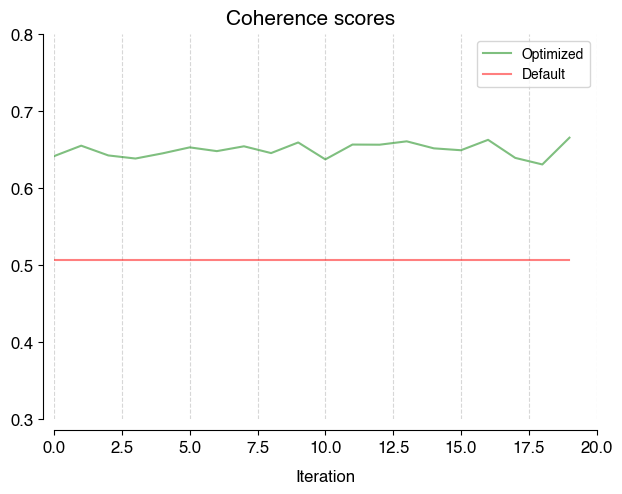

In [273]:
import seaborn as sns
#default coherence
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.37, 0.9, 'Coherence scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0.3, 0.8))
ax.set_xlim(0,20)
ax.set_ylim(0.3,0.8)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()
plt.plot(performance_scores_default['coherence'], color="green",
          alpha=0.5, linewidth = 1.5)

plt.plot(performance_scores_optimized['coherence'], color="red", alpha=0.5, linewidth = 1.5)


plt.legend(['Optimized', 'Default'])

plt.show()

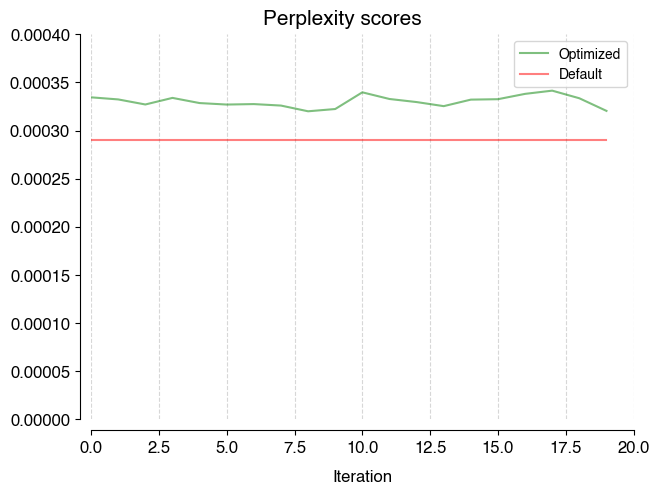

In [330]:
#default perplexity
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.37, 0.9, 'Perplexity scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0.000, 0.0004))
ax.set_xlim(0,20)
ax.set_ylim(0, 0.0004)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()
plt.plot(performance_scores_default['perplexity'], color="green",
          alpha=0.5, linewidth = 1.5)

plt.plot(performance_scores_optimized['perplexity'], color="red", alpha=0.5, linewidth = 1.5)


plt.legend(['Optimized', 'Default'])

plt.show()

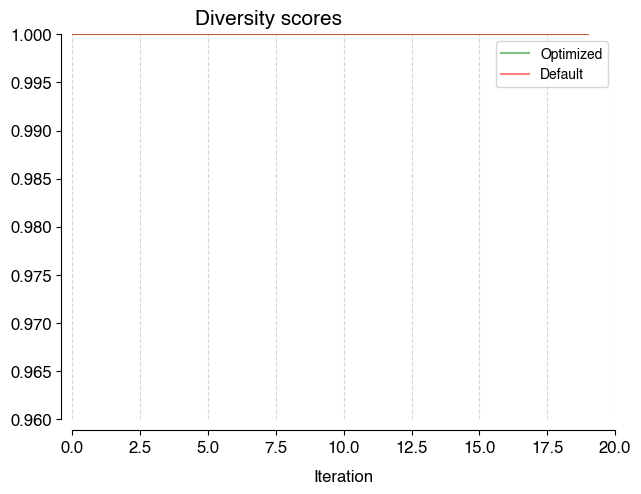

In [285]:
import seaborn as sns
#diversity
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Diversity scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0.96, 1))
ax.set_xlim(0,20)
ax.set_ylim(0.96,1)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()
plt.plot(performance_scores_default['diversity'], color="green",
          alpha=0.5, linewidth = 1.5)

plt.plot(performance_scores_optimized['diversity'], color="red", alpha=0.5, linewidth = 1.5)


plt.legend(['Optimized', 'Default'])

plt.show()

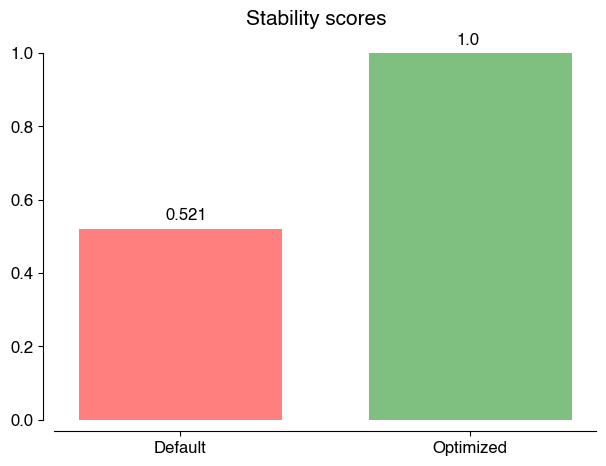

In [308]:
import seaborn as sns
#diversity
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

#ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.4, 0.9, 'Stability scores', fontsize=15, fontweight='black', color = 'black')

fig.text(0.285, 0.51, performance_scores_default['stability'], fontsize=12, fontweight='black', color = 'black')
fig.text(0.7, 0.86, performance_scores_optimized['stability'], fontsize=12, fontweight='black', color = 'black')
         
stab = [performance_scores_default['stability'], 
        performance_scores_optimized['stability']]

stab_names = ['Default', 'Optimized']
c = ['red', 'green']

plt.bar(stab_names, stab, color=c, width = 0.7, alpha=0.5)
ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0, 1))

#ax.set_xlim(0,1)
#ax.set_ylim(0,1)
#ax.invert_yaxis()

#ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.show()

#### Embeddings

In [325]:
#sbert
performance_scores_sbert = {}    
topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2")

stability_aux = {}
coherence = []
perplexity = []
diversity = []
stability = []
for j in range(20):
    print("Iteration", j)

    print("--> Modeling topics...")
    topics, probs = topic_model.fit_transform(docs)

    print("--> Calculating Coherence...")
    coherence.append(coherence_score(docs, topics))

    print("--> Calculating Perplexity...")
    perplexity.append(perplexity_score(probs))

    print("--> Calculating Diversity...")
    diversity_value, unique_words = diversity_score(topic_model)
    diversity.append(diversity_value)
    stability_aux[j] = unique_words
print("--> Calculating Stability...")
stability = stability_score(stability_aux)
#save model performance scores
performance_scores_sbert['coherence'] = coherence
performance_scores_sbert['perplexity'] = perplexity
performance_scores_sbert['diversity'] = diversity
performance_scores_sbert['stability'] = stability

print("---------------------------")


Iteration 0
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> 

In [326]:
#spacy
import spacy
performance_scores_spacy = {}    
nlp = spacy.load("en_core_web_sm", exclude=['tagger', 'parser', 'ner', 
                                            'attribute_ruler', 'lemmatizer'])
topic_model = BERTopic(embedding_model=nlp)

stability_aux = {}
coherence = []
perplexity = []
diversity = []
stability = []
for j in range(20):
    print("Iteration", j)

    print("--> Modeling topics...")
    topics, probs = topic_model.fit_transform(docs)

    print("--> Calculating Coherence...")
    coherence.append(coherence_score(docs, topics))

    print("--> Calculating Perplexity...")
    perplexity.append(perplexity_score(probs))

    print("--> Calculating Diversity...")
    diversity_value, unique_words = diversity_score(topic_model)
    diversity.append(diversity_value)
    stability_aux[j] = unique_words
print("--> Calculating Stability...")
stability = stability_score(stability_aux)
#save model performance scores
performance_scores_spacy['coherence'] = coherence
performance_scores_spacy['perplexity'] = perplexity
performance_scores_spacy['diversity'] = diversity
performance_scores_spacy['stability'] = stability

print("---------------------------")


Iteration 0
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> 

In [327]:
#gensim (word2vec)
import gensim.downloader as api
from gensim.models import Word2Vec
performance_scores_gensim = {}    
#kft = api.load('fasttext-wiki-news-subwords-300')
topic_model = BERTopic(embedding_model=Word2Vec)

stability_aux = {}
coherence = []
perplexity = []
diversity = []
stability = []
for j in range(20):
    print("Iteration", j)

    print("--> Modeling topics...")
    topics, probs = topic_model.fit_transform(docs)

    print("--> Calculating Coherence...")
    coherence.append(coherence_score(docs, topics))

    print("--> Calculating Perplexity...")
    perplexity.append(perplexity_score(probs))

    print("--> Calculating Diversity...")
    diversity_value, unique_words = diversity_score(topic_model)
    diversity.append(diversity_value)
    stability_aux[j] = unique_words
print("--> Calculating Stability...")
stability = stability_score(stability_aux)
#save model performance scores
performance_scores_gensim['coherence'] = coherence
performance_scores_gensim['perplexity'] = perplexity
performance_scores_gensim['diversity'] = diversity
performance_scores_gensim['stability'] = stability

print("---------------------------")


Iteration 0
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> 

In [329]:
import statistics
scores = ['coherence','perplexity', 'diversity']
for score in scores:
    print(score, statistics.mean(performance_scores_sbert[score]), statistics.mean(performance_scores_spacy[score]), statistics.mean(performance_scores_gensim[score]))
print(performance_scores_sbert['stability'], performance_scores_spacy['stability'], performance_scores_gensim['stability'])

coherence 0.7488386140029815 0.6066005236362758 0.7486585891332284
perplexity 0.0003281285354874991 0.00018623445729925244 0.0003236860831501114
diversity 0.97 0.996 0.962
0.557 0.696 0.639


In [ ]:
###### import seaborn as sns
#coherence
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Embeddings coherence scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0.3, 0.8))
ax.set_xlim(0,20)
ax.set_ylim(0.3,0.8)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()
plt.plot(performance_scores_sbert['coherence'], color="green",
          alpha=0.5, linewidth = 1.5)

plt.plot(performance_scores_spacy['coherence'], color="red", alpha=0.5, linewidth = 1.5)

plt.plot(performance_scores_gensim['coherence'], color="#007ACC", alpha=0.5, linewidth = 1.5)

plt.legend(['SBERT', 'SpaCy', 'Word2Vec'])

plt.show()

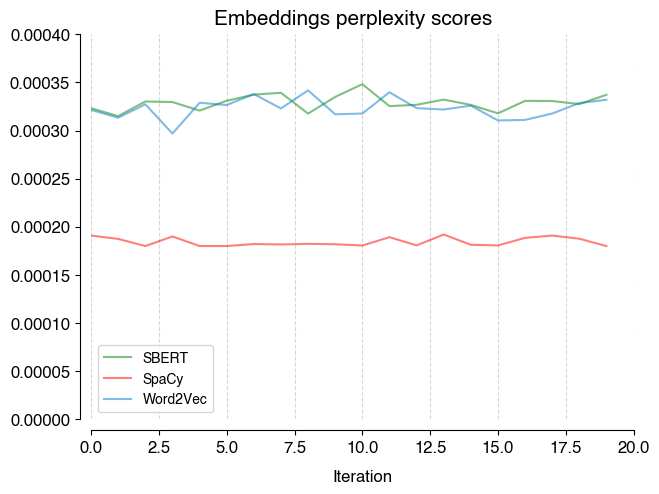

In [874]:
import seaborn as sns
#perplexity
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Embeddings perplexity scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0, 0.0004))
ax.set_xlim(0,20)
ax.set_ylim(0,0.0004)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()
plt.plot(performance_scores_sbert['perplexity'], color="green",
          alpha=0.5, linewidth = 1.5)

plt.plot(performance_scores_spacy['perplexity'], color="red", alpha=0.5, linewidth = 1.5)

plt.plot(performance_scores_gensim['perplexity'], color="#007ACC", alpha=0.5, linewidth = 1.5)

plt.legend(['SBERT', 'SpaCy', 'Word2Vec'])

plt.show()

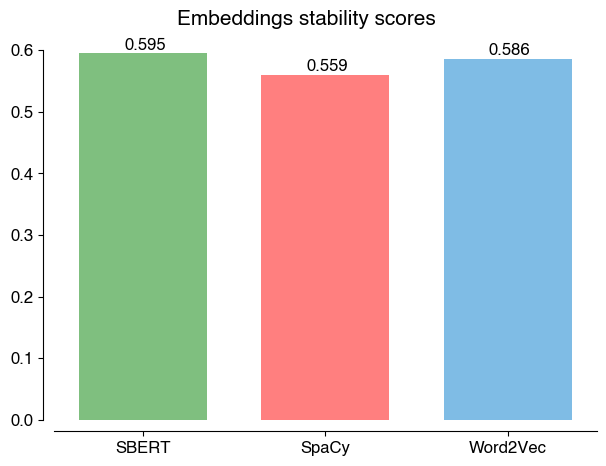

In [506]:
import seaborn as sns
#diversity
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

#ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Embeddings stability scores', fontsize=15, fontweight='black', color = 'black')

fig.text(0.225, 0.85, performance_scores_sbert['stability'], fontsize=12, fontweight='black', color = 'black')
fig.text(0.485, 0.808, performance_scores_spacy['stability'], fontsize=12, fontweight='black', color = 'black')
fig.text(0.745, 0.84, performance_scores_gensim['stability'], fontsize=12, fontweight='black', color = 'black')
         
stab = [performance_scores_sbert['stability'], 
        performance_scores_spacy['stability'], 
        performance_scores_gensim['stability']]

stab_names = ['SBERT', 'SpaCy', 'Word2Vec']
c = ['green', 'red', "#007ACC"]

plt.bar(stab_names, stab, color=c, width = 0.7, alpha=0.5)
ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0, 0.6))

#ax.set_xlim(0,1)
#ax.set_ylim(0,1)
#ax.invert_yaxis()

#ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.show()

#### Dimensionality

In [331]:
#umap
from umap import UMAP
performance_scores_umap = {}    
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
topic_model = BERTopic(umap_model=umap_model)
stability_aux = {}
coherence = []
perplexity = []
diversity = []

stability = [] 
for j in range(5):
    print("Iteration", j)

    print("--> Modeling topics...")
    topics, probs = topic_model.fit_transform(docs)

    print("--> Calculating Coherence...")
    coherence.append(coherence_score(docs, topics))

    print("--> Calculating Perplexity...")
    perplexity.append(perplexity_score(probs))

    print("--> Calculating Diversity...")
    diversity_value, unique_words = diversity_score(topic_model)
    diversity.append(diversity_value)
    stability_aux[j] = unique_words
print("--> Calculating Stability...")
stability = stability_score(stability_aux)
#save model performance scores
performance_scores_umap['coherence'] = coherence
performance_scores_umap['perplexity'] = perplexity
performance_scores_umap['diversity'] = diversity
performance_scores_umap['stability'] = stability
print("---------------------------")


Iteration 0
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------


In [332]:
#PCA
performance_scores_pca = {}    
from sklearn.decomposition import PCA
dim_model = PCA(n_components=5)
topic_model = BERTopic(umap_model=dim_model)

stability_aux = {}
coherence = []
perplexity = []
diversity = []

stability = [] 
for j in range(5):
    print("Iteration", j)

    print("--> Modeling topics...")
    topics, probs = topic_model.fit_transform(docs)

    print("--> Calculating Coherence...")
    coherence.append(coherence_score(docs, topics))

    print("--> Calculating Perplexity...")
    perplexity.append(perplexity_score(probs))

    print("--> Calculating Diversity...")
    diversity_value, unique_words = diversity_score(topic_model)
    diversity.append(diversity_value)
    stability_aux[j] = unique_words
print("--> Calculating Stability...")
stability = stability_score(stability_aux)
#save model performance scores
performance_scores_pca['coherence'] = coherence
performance_scores_pca['perplexity'] = perplexity
performance_scores_pca['diversity'] = diversity
performance_scores_pca['stability'] = stability
print("---------------------------")


Iteration 0
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------


In [333]:
#none
from bertopic.dimensionality import BaseDimensionalityReduction
performance_scores_none = {}    
empty_dimensionality_model = BaseDimensionalityReduction()
topic_model = BERTopic(umap_model=empty_dimensionality_model)

stability_aux = {}
coherence = []
perplexity = []
diversity = []

stability = [] 
for j in range(5):
    print("Iteration", j)

    print("--> Modeling topics...")
    topics, probs = topic_model.fit_transform(docs)

    print("--> Calculating Coherence...")
    coherence.append(coherence_score(docs, topics))

    print("--> Calculating Perplexity...")
    perplexity.append(perplexity_score(probs))

    print("--> Calculating Diversity...")
    diversity_value, unique_words = diversity_score(topic_model)
    diversity.append(diversity_value)
    stability_aux[j] = unique_words
print("--> Calculating Stability...")
stability = stability_score(stability_aux)
#save model performance scores
performance_scores_none['coherence'] = coherence
performance_scores_none['perplexity'] = perplexity
performance_scores_none['diversity'] = diversity
performance_scores_none['stability'] = stability
print("---------------------------")


Iteration 0
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------


In [334]:
import statistics
scores = ['coherence','perplexity', 'diversity']
for score in scores:
    print(score, statistics.mean(performance_scores_umap[score]), statistics.mean(performance_scores_pca[score]), statistics.mean(performance_scores_none[score]))
print(performance_scores_umap['stability'], performance_scores_pca['stability'], performance_scores_none['stability'])

coherence 0.7559286145337654 0.43443308806474934 0.6593759077506511
perplexity 0.000338836387740088 0.0005215395733586985 0.0005331405649331307
diversity 0.968 0.792 0.92
0.695 0.98 1.0


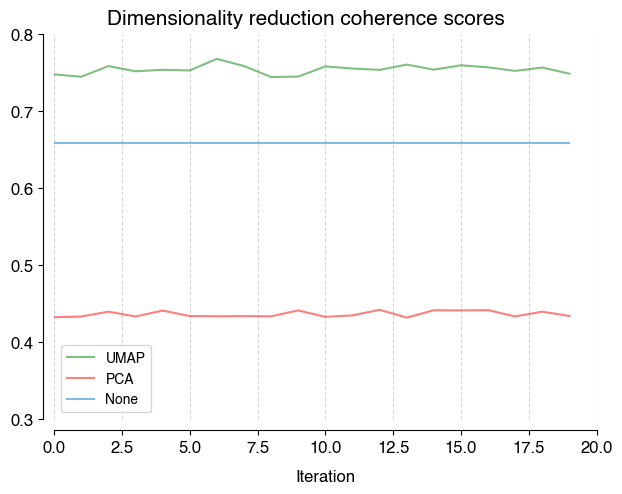

In [878]:
import seaborn as sns
#dimensionality reduction coherence
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.2, 0.9, 'Dimensionality reduction coherence scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0.3, 0.8))
ax.set_xlim(0,20)
ax.set_ylim(0.3,0.8)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(performance_scores_umap['coherence'], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(performance_scores_pca['coherence'], color="red", alpha=0.5, linewidth = 1.5)
plt.plot(performance_scores_none['coherence'], color="#007ACC", alpha=0.5, linewidth = 1.5)

plt.legend(['UMAP', 'PCA', 'None'])

plt.show()

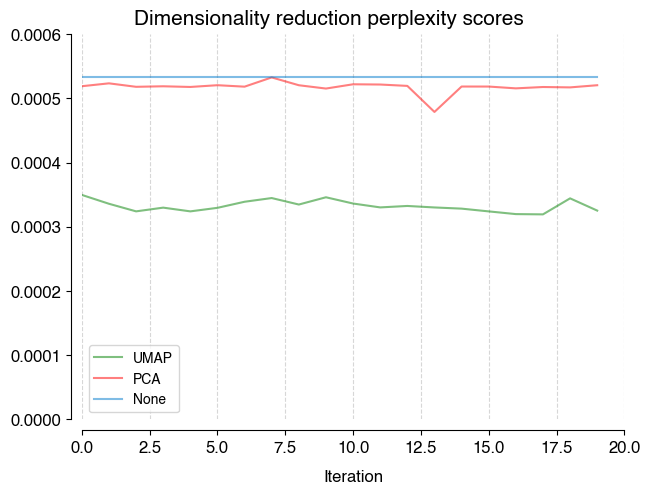

In [897]:
import seaborn as sns
#dimensionality reduction perplexity
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.2, 0.9, 'Dimensionality reduction perplexity scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0, 0.0006))
ax.set_xlim(0,20)
ax.set_ylim(0,0.0006)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(performance_scores_umap['perplexity'], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(performance_scores_pca['perplexity'], color="red", alpha=0.5, linewidth = 1.5)
plt.plot(performance_scores_none['perplexity'], color="#007ACC", alpha=0.5, linewidth = 1.5)

plt.legend(['UMAP', 'PCA', 'None'])

plt.show()

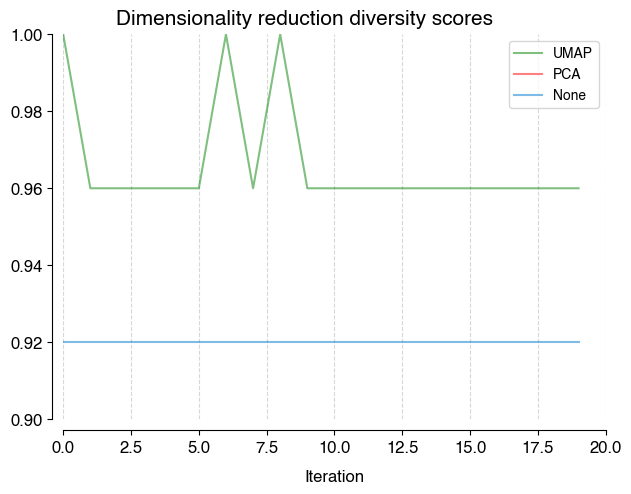

In [906]:
import seaborn as sns
#dimensionality reduction diversity
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.2, 0.9, 'Dimensionality reduction diversity scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0.9, 1))
ax.set_xlim(0,20)
ax.set_ylim(0.9,1)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(performance_scores_umap['diversity'], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(performance_scores_pca['diversity'], color="red", alpha=0.5, linewidth = 1.5)
plt.plot(performance_scores_none['diversity'], color="#007ACC", alpha=0.5, linewidth = 1.5)

plt.legend(['UMAP', 'PCA', 'None'])

plt.show()

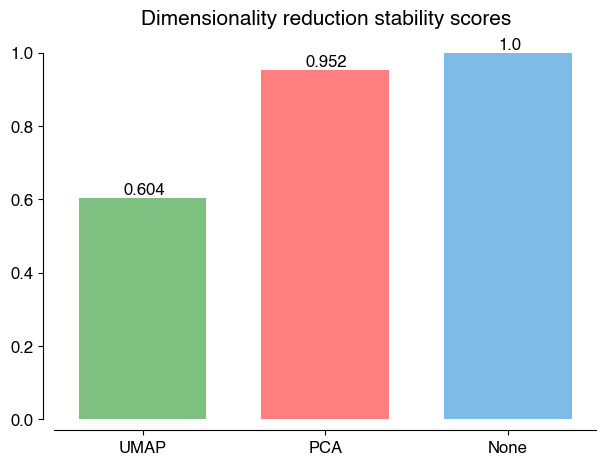

In [546]:
import seaborn as sns
#stability
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

#ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.25, 0.9, 'Dimensionality reduction stability scores', fontsize=15, fontweight='black', color = 'black')

fig.text(0.225, 0.56, performance_scores_umap['stability'], fontsize=12, fontweight='black', color = 'black')
fig.text(0.485, 0.816, performance_scores_pca['stability'], fontsize=12, fontweight='black', color = 'black')
fig.text(0.76, 0.85, performance_scores_none['stability'], fontsize=12, fontweight='black', color = 'black')
         
stab = [performance_scores_umap['stability'], 
        performance_scores_pca['stability'], 
        performance_scores_none['stability']]

stab_names = ['UMAP', 'PCA', 'None']
c = ['green', 'red', "#007ACC"]

plt.bar(stab_names, stab, color=c, width = 0.7, alpha=0.5)
ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0, 1))

#ax.set_xlim(0,1)
#ax.set_ylim(0,1)
#ax.invert_yaxis()

#ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.show()

#### Clustering

In [335]:
#hdbscan

performance_scores_hdbscan = {}    
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
topic_model = BERTopic(hdbscan_model=hdbscan_model)

stability_aux = {}
coherence = []
perplexity = []
diversity = []

stability = [] 
for j in range(5):
    print("Iteration", j)

    print("--> Modeling topics...")
    topics, probs = topic_model.fit_transform(docs)

    print("--> Calculating Coherence...")
    coherence.append(coherence_score(docs, topics))
    print(coherence)
    print("--> Calculating Perplexity...")
    perplexity.append(perplexity_score(probs))

    print("--> Calculating Diversity...")
    diversity_value, unique_words = diversity_score(topic_model)
    diversity.append(diversity_value)
    stability_aux[j] = unique_words
print("--> Calculating Stability...")
stability = stability_score(stability_aux)
#save model performance scores
print(coherence)
performance_scores_hdbscan['coherence'] = coherence
performance_scores_hdbscan['perplexity'] = perplexity
performance_scores_hdbscan['diversity'] = diversity
performance_scores_hdbscan['stability'] = stability
print("---------------------------")


Iteration 0
--> Modeling topics...
--> Calculating Coherence...
[0.7416509073339718]
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...
--> Calculating Coherence...
[0.7416509073339718, 0.7615559381109754]
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...
--> Calculating Coherence...
[0.7416509073339718, 0.7615559381109754, 0.7481808287912536]
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...
--> Calculating Coherence...
[0.7416509073339718, 0.7615559381109754, 0.7481808287912536, 0.7403264140413358]
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...
--> Calculating Coherence...
[0.7416509073339718, 0.7615559381109754, 0.7481808287912536, 0.7403264140413358, 0.7538560130146436]
--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
[0.7416509073339718, 0.7615559381109754, 0.74818082

In [336]:
#kmeans

performance_scores_kmeans = {}    
from sklearn.cluster import KMeans

cluster_model = KMeans(n_clusters=50)
topic_model = BERTopic(hdbscan_model=cluster_model, calculate_probabilities=True)
print(type(probs))
stability_aux = {}
coherence = []
perplexity = []
diversity = []

stability = [] 
for j in range(5):
    print("Iteration", j)

    print("--> Modeling topics...")
    topics, probs = topic_model.fit_transform(docs)

    print("--> Calculating Coherence...")
    coherence.append(coherence_score(docs, topics))

    print("--> Calculating Perplexity...")
    perplexity.append(perplexity_score(probs))

    print("--> Calculating Diversity...")
    diversity_value, unique_words = diversity_score(topic_model)
    diversity.append(diversity_value)
    stability_aux[j] = unique_words
print("--> Calculating Stability...")
stability = stability_score(stability_aux)
#save model performance scores
performance_scores_kmeans['coherence'] = coherence
performance_scores_kmeans['perplexity'] = perplexity
performance_scores_kmeans['diversity'] = diversity
performance_scores_kmeans['stability'] = stability
print("---------------------------")


<class 'numpy.ndarray'>
Iteration 0
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------


In [337]:
import statistics
scores = ['coherence','perplexity', 'diversity']
for score in scores:
    print(score, statistics.mean(performance_scores_hdbscan[score]), statistics.mean(performance_scores_kmeans[score]))
print(performance_scores_hdbscan['stability'], performance_scores_kmeans['stability'])

coherence 0.749114020258436 0.7367661163396125
perplexity 0.0003306586972869772 1.0
diversity 1.0 1.0
0.654 0.493


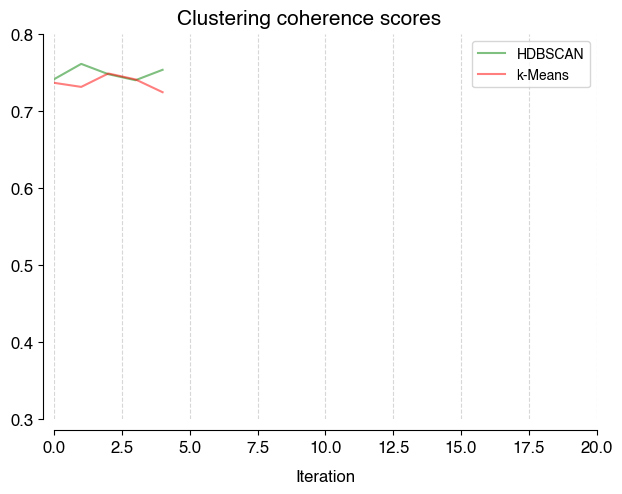

In [341]:
import seaborn as sns
#clustering coherence
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Clustering coherence scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0.3, 0.8))
ax.set_xlim(0,20)
ax.set_ylim(0.3,0.8)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(performance_scores_hdbscan['coherence'], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(performance_scores_kmeans['coherence'], color="red", alpha=0.5, linewidth = 1.5)

plt.legend(['HDBSCAN', 'k-Means'])

plt.show()

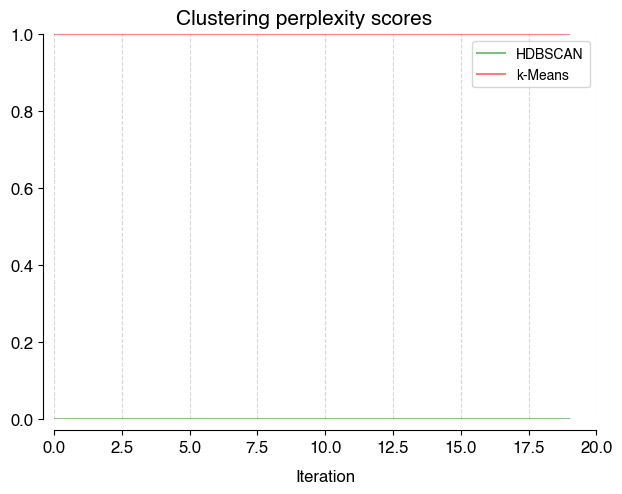

In [899]:
import seaborn as sns
#clustering perplexity
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Clustering perplexity scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0, 1))
ax.set_xlim(0,20)
ax.set_ylim(0,1)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(performance_scores_hdbscan['perplexity'], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(performance_scores_kmeans['perplexity'], color="red", alpha=0.5, linewidth = 1.5)

plt.legend(['HDBSCAN', 'k-Means'])

plt.show()

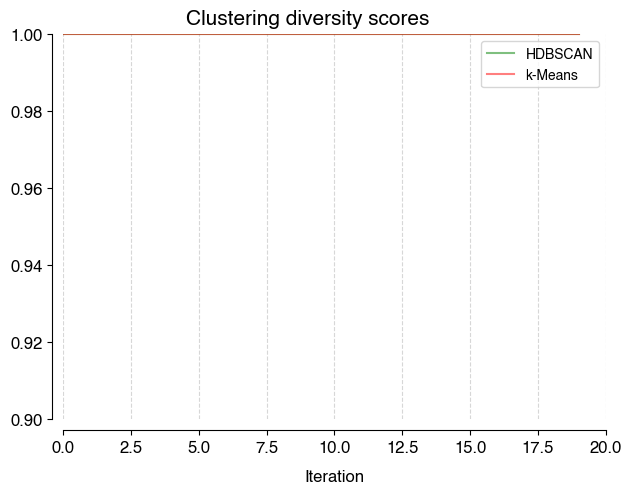

In [589]:
import seaborn as sns
#clustering diversity
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Clustering diversity scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0.9, 1))
ax.set_xlim(0,20)
ax.set_ylim(0.9,1)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(performance_scores_hdbscan['diversity'], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(performance_scores_kmeans['diversity'], color="red", alpha=0.5, linewidth = 1.5)

plt.legend(['HDBSCAN', 'k-Means'])

plt.show()

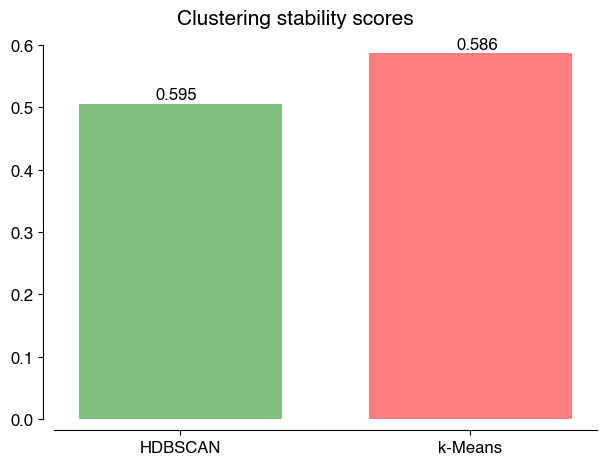

In [603]:
import seaborn as sns
#stability
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

#ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Clustering stability scores', fontsize=15, fontweight='black', color = 'black')

fig.text(0.27, 0.75, performance_scores_sbert['stability'], fontsize=12, fontweight='black', color = 'black')
fig.text(0.7, 0.85, performance_scores_gensim['stability'], fontsize=12, fontweight='black', color = 'black')
         
stab = [performance_scores_hdbscan['stability'], 
        performance_scores_kmeans['stability']]

stab_names = ['HDBSCAN', 'k-Means']
c = ['green', 'red']

plt.bar(stab_names, stab, color=c, width = 0.7, alpha=0.5)
ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0, 0.6))

#ax.set_xlim(0,1)
#ax.set_ylim(0,1)
#ax.invert_yaxis()

#ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.show()

#### Bag-of-Words

In [338]:
#ngram_range
from sklearn.feature_extraction.text import CountVectorizer
performance_scores_ngram = {}
for i in range(1,7):
    vectorizer_model = CountVectorizer(ngram_range=(1, i))
    topic_model = BERTopic()
    
    stability_aux = {}
    coherence = []
    perplexity = []
    diversity = []
    stability = []
    for j in range(5):
        print("Iteration", j)

        print("--> Modeling topics...")
        topics, probs = topic_model.fit_transform(docs)
        topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
        print("--> Calculating Coherence...")
        coherence.append(coherence_score(docs, topics))

        print("--> Calculating Perplexity...")
        perplexity.append(perplexity_score(probs))

        print("--> Calculating Diversity...")
        diversity_value, unique_words = diversity_score(topic_model)
        diversity.append(diversity_value)
        stability_aux[j] = unique_words
    print("--> Calculating Stability...")
    stability = stability_score(stability_aux)
    #save model performance scores
    performance_scores_ngram[i] = [coherence, perplexity, diversity, stability]
    print("---------------------------")


Iteration 0
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------
Iteration 0
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...
--> Calculating Coherence...
--> Calculating Pe

In [339]:
one = performance_scores_ngram[1]
two = performance_scores_ngram[2]
three = performance_scores_ngram[3]
four  = performance_scores_ngram[4]
five = performance_scores_ngram[5]
six  = performance_scores_ngram[6]

In [340]:
one

[[0.7486917836361031,
  0.7532315357514732,
  0.7678914573493463,
  0.7489486236967036,
  0.753557902846554],
 [0.00031831399980718087,
  0.0003480354981801453,
  0.0003340652359682932,
  0.00035102944233564944,
  0.00033167126172043646],
 [0.96, 0.96, 0.96, 0.96, 0.96],
 0.619]

In [ ]:
import statistics
scores = ['coherence','perplexity', 'diversity']
for score in scores:
    print(score, statistics.mean(performance_scores_sbert[score]), statistics.mean(performance_scores_spacy[score]), statistics.mean(performance_scores_gensim[score]))
print(performance_scores_sbert['stability'], performance_scores_spacy['stability'], performance_scores_gensim['stability'])

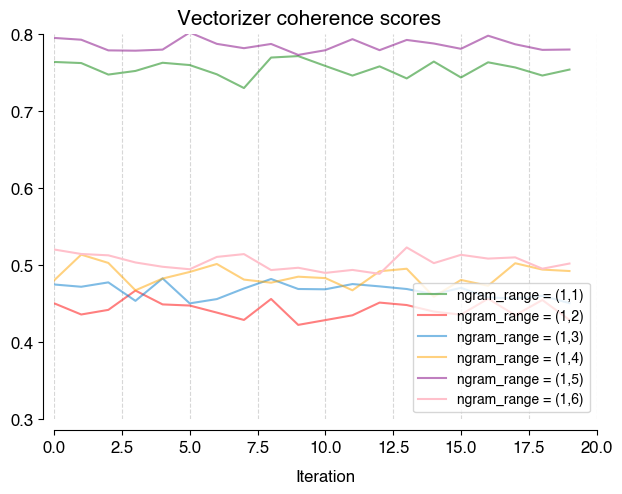

In [882]:
import seaborn as sns
#vectorizers coherence
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Vectorizer coherence scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0.3, 0.8))
ax.set_xlim(0,20)
ax.set_ylim(0.3,0.8)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(one[0], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(two[0], color="red", alpha=0.5, linewidth = 1.5)
plt.plot(three[0], color="#007ACC", alpha=0.5, linewidth = 1.5)
plt.plot(four[0], color="orange", alpha=0.5, linewidth = 1.5)
plt.plot(five[0], color="purple", alpha=0.5, linewidth = 1.5)
plt.plot(six[0], color="pink", alpha=1, linewidth = 1.5)

plt.legend(['ngram_range = (1,1)', 'ngram_range = (1,2)', 'ngram_range = (1,3)', 
            'ngram_range = (1,4)', 'ngram_range = (1,5)', 'ngram_range = (1,6)'], loc='lower right')

plt.show()

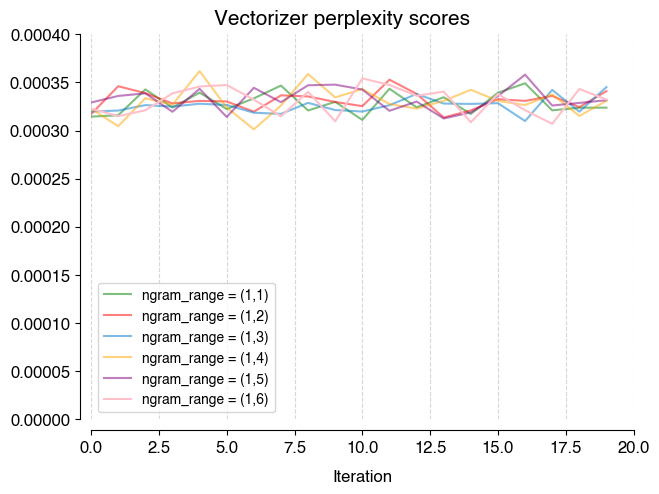

In [900]:
import seaborn as sns
#vectorizers coherence
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Vectorizer perplexity scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0, 0.0004))
ax.set_xlim(0,20)
ax.set_ylim(0,0.0004)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(one[1], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(two[1], color="red", alpha=0.5, linewidth = 1.5)
plt.plot(three[1], color="#007ACC", alpha=0.5, linewidth = 1.5)
plt.plot(four[1], color="orange", alpha=0.5, linewidth = 1.5)
plt.plot(five[1], color="purple", alpha=0.5, linewidth = 1.5)
plt.plot(six[1], color="pink", alpha=1, linewidth = 1.5)

plt.legend(['ngram_range = (1,1)', 'ngram_range = (1,2)', 'ngram_range = (1,3)', 
            'ngram_range = (1,4)', 'ngram_range = (1,5)', 'ngram_range = (1,6)'])

plt.show()

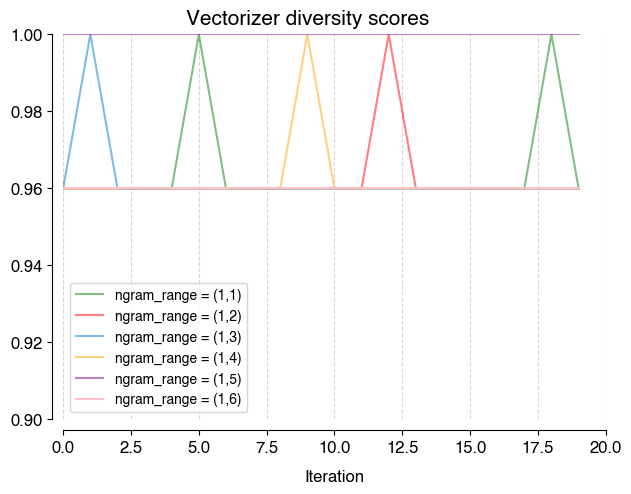

In [908]:
import seaborn as sns
#vectorizers diversity
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Vectorizer diversity scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0.9, 1))
ax.set_xlim(0,20)
ax.set_ylim(0.9,1)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(one[2], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(two[2], color="red", alpha=0.5, linewidth = 1.5)
plt.plot(three[2], color="#007ACC", alpha=0.5, linewidth = 1.5)
plt.plot(four[2], color="orange", alpha=0.5, linewidth = 1.5)
plt.plot(five[2], color="purple", alpha=0.5, linewidth = 1.5)
plt.plot(six[2], color="pink", alpha=1, linewidth = 1.5)

plt.legend(['ngram_range = (1,1)', 'ngram_range = (1,2)', 'ngram_range = (1,3)', 
            'ngram_range = (1,4)', 'ngram_range = (1,5)', 'ngram_range = (1,6)'])

plt.show()

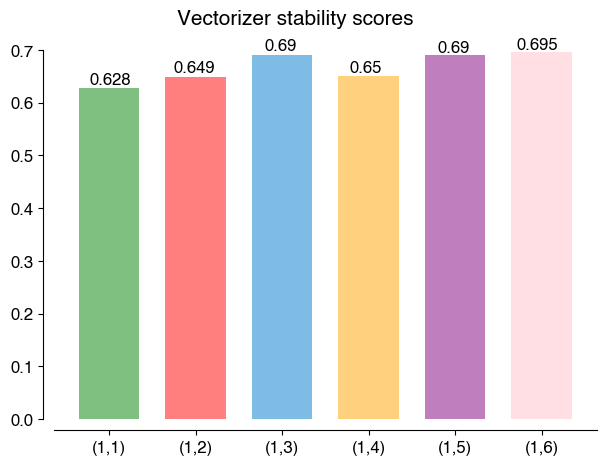

In [672]:
import seaborn as sns
#stability
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

#ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Vectorizer stability scores', fontsize=15, fontweight='black', color = 'black')

fig.text(0.175, 0.78, one[3], fontsize=12, fontweight='black', color = 'black')
fig.text(0.295, 0.805, two[3], fontsize=12, fontweight='black', color = 'black')
fig.text(0.425, 0.848, three[3], fontsize=12, fontweight='black', color = 'black')
fig.text(0.547, 0.805, four[3], fontsize=12, fontweight='black', color = 'black')
fig.text(0.673, 0.845, five[3], fontsize=12, fontweight='black', color = 'black')
fig.text(0.785, 0.85, six[3], fontsize=12, fontweight='black', color = 'black')
         
stab = [one[3], two[3], three[3], four[3], five[3], six[3]]

stab_names = ['(1,1)', '(1,2)', '(1,3)', '(1,4)', '(1,5)', '(1,6)']
c = ['green', 'red', '#007ACC', 'orange', 'purple', 'pink']

plt.bar(stab_names, stab, color=c, width = 0.7, alpha=0.5)
ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0, 0.7))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.show()

In [673]:
#bow
performance_scores_mindf = {}
from tqdm.auto import tqdm

for i in tqdm(range(5,26,5)):
    
    print("PARAMETER:", i)
    
    vectorizer_model = CountVectorizer(min_df=i)
    topic_model = BERTopic()
    
    stability_aux = {}
    coherence = []
    perplexity = []
    diversity = []
    stability = []
    for j in range(20):
        print("Iteration", j)

        print("--> Modeling topics...")
        topics, probs = topic_model.fit_transform(docs)
        topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
        print("--> Calculating Coherence...")
        coherence.append(coherence_score(docs, topics))

        print("--> Calculating Perplexity...")
        perplexity.append(perplexity_score(probs))

        print("--> Calculating Diversity...")
        diversity_value, unique_words = diversity_score(topic_model)
        diversity.append(diversity_value)
        stability_aux[j] = unique_words
    print("--> Calculating Stability...")
    stability = stability_score(stability_aux)
    #save model performance scores
    performance_scores_mindf[i] = [coherence, perplexity, diversity, stability]
    print("---------------------------")



  0%|                                                     | 0/5 [00:00<?, ?it/s]

PARAMETER: 5
Iteration 0
--> Modeling topics...


2023-09-17 19:36:44,988 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:36:47,768 - BERTopic - Reduced dimensionality
2023-09-17 19:36:47,853 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...


2023-09-17 19:37:13,147 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:37:16,071 - BERTopic - Reduced dimensionality
2023-09-17 19:37:16,160 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...


2023-09-17 19:37:40,780 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:37:43,653 - BERTopic - Reduced dimensionality
2023-09-17 19:37:43,744 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...


2023-09-17 19:38:08,878 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:38:11,701 - BERTopic - Reduced dimensionality
2023-09-17 19:38:11,794 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...


2023-09-17 19:38:37,516 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:38:40,419 - BERTopic - Reduced dimensionality
2023-09-17 19:38:40,512 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...


2023-09-17 19:39:06,758 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:39:09,591 - BERTopic - Reduced dimensionality
2023-09-17 19:39:09,683 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...


2023-09-17 19:39:34,525 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:39:37,439 - BERTopic - Reduced dimensionality
2023-09-17 19:39:37,533 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...


2023-09-17 19:40:03,519 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:40:06,342 - BERTopic - Reduced dimensionality
2023-09-17 19:40:06,427 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> Modeling topics...


2023-09-17 19:40:32,415 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:40:35,217 - BERTopic - Reduced dimensionality
2023-09-17 19:40:35,306 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 9
--> Modeling topics...


2023-09-17 19:41:01,000 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:41:03,814 - BERTopic - Reduced dimensionality
2023-09-17 19:41:03,900 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 10
--> Modeling topics...


2023-09-17 19:41:30,355 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:41:33,273 - BERTopic - Reduced dimensionality
2023-09-17 19:41:33,362 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 11
--> Modeling topics...


2023-09-17 19:41:59,135 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:42:01,963 - BERTopic - Reduced dimensionality
2023-09-17 19:42:02,051 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 12
--> Modeling topics...


2023-09-17 19:42:27,576 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:42:30,443 - BERTopic - Reduced dimensionality
2023-09-17 19:42:30,535 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 13
--> Modeling topics...


2023-09-17 19:42:56,464 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:42:59,278 - BERTopic - Reduced dimensionality
2023-09-17 19:42:59,370 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 14
--> Modeling topics...


2023-09-17 19:43:24,818 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:43:27,582 - BERTopic - Reduced dimensionality
2023-09-17 19:43:27,671 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 15
--> Modeling topics...


2023-09-17 19:43:54,263 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:43:57,070 - BERTopic - Reduced dimensionality
2023-09-17 19:43:57,159 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 16
--> Modeling topics...


2023-09-17 19:44:23,407 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:44:26,250 - BERTopic - Reduced dimensionality
2023-09-17 19:44:26,338 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 17
--> Modeling topics...


2023-09-17 19:44:52,385 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:44:55,315 - BERTopic - Reduced dimensionality
2023-09-17 19:44:55,400 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 18
--> Modeling topics...


2023-09-17 19:45:20,854 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:45:23,685 - BERTopic - Reduced dimensionality
2023-09-17 19:45:23,775 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 19
--> Modeling topics...


2023-09-17 19:45:49,155 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:45:52,052 - BERTopic - Reduced dimensionality
2023-09-17 19:45:52,138 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...



 20%|████████▊                                   | 1/5 [09:33<38:13, 573.46s/it]

--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------
PARAMETER: 10
Iteration 0
--> Modeling topics...


2023-09-17 19:46:18,173 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:46:20,949 - BERTopic - Reduced dimensionality
2023-09-17 19:46:21,043 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...


2023-09-17 19:46:47,639 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:46:50,505 - BERTopic - Reduced dimensionality
2023-09-17 19:46:50,596 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...


2023-09-17 19:47:16,221 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:47:19,126 - BERTopic - Reduced dimensionality
2023-09-17 19:47:19,217 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...


2023-09-17 19:47:44,843 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:47:47,718 - BERTopic - Reduced dimensionality
2023-09-17 19:47:47,807 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...


2023-09-17 19:48:13,658 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:48:16,500 - BERTopic - Reduced dimensionality
2023-09-17 19:48:16,592 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...


2023-09-17 19:48:43,694 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:48:46,569 - BERTopic - Reduced dimensionality
2023-09-17 19:48:46,659 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...


2023-09-17 19:49:13,403 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:49:16,266 - BERTopic - Reduced dimensionality
2023-09-17 19:49:16,359 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...


2023-09-17 19:49:42,070 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:49:44,869 - BERTopic - Reduced dimensionality
2023-09-17 19:49:44,954 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> Modeling topics...


2023-09-17 19:50:10,910 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:50:13,776 - BERTopic - Reduced dimensionality
2023-09-17 19:50:13,866 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 9
--> Modeling topics...


2023-09-17 19:50:40,106 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:50:43,041 - BERTopic - Reduced dimensionality
2023-09-17 19:50:43,132 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 10
--> Modeling topics...


2023-09-17 19:51:11,273 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:51:14,129 - BERTopic - Reduced dimensionality
2023-09-17 19:51:14,215 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 11
--> Modeling topics...


2023-09-17 19:51:41,163 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:51:44,229 - BERTopic - Reduced dimensionality
2023-09-17 19:51:44,321 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 12
--> Modeling topics...


2023-09-17 19:52:11,569 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:52:14,588 - BERTopic - Reduced dimensionality
2023-09-17 19:52:14,678 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 13
--> Modeling topics...


2023-09-17 19:52:42,487 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:52:45,562 - BERTopic - Reduced dimensionality
2023-09-17 19:52:45,654 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 14
--> Modeling topics...


2023-09-17 19:53:12,141 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:53:15,052 - BERTopic - Reduced dimensionality
2023-09-17 19:53:15,142 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 15
--> Modeling topics...


2023-09-17 19:53:43,263 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:53:46,223 - BERTopic - Reduced dimensionality
2023-09-17 19:53:46,317 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 16
--> Modeling topics...


2023-09-17 19:54:13,248 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:54:16,176 - BERTopic - Reduced dimensionality
2023-09-17 19:54:16,266 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 17
--> Modeling topics...


2023-09-17 19:54:43,051 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:54:46,114 - BERTopic - Reduced dimensionality
2023-09-17 19:54:46,208 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 18
--> Modeling topics...


2023-09-17 19:55:13,516 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:55:16,722 - BERTopic - Reduced dimensionality
2023-09-17 19:55:16,813 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 19
--> Modeling topics...


2023-09-17 19:55:44,334 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:55:47,213 - BERTopic - Reduced dimensionality
2023-09-17 19:55:47,301 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...



 40%|█████████████████▌                          | 2/5 [19:28<29:18, 586.14s/it]

--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------
PARAMETER: 15
Iteration 0
--> Modeling topics...


2023-09-17 19:56:13,562 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:56:17,428 - BERTopic - Reduced dimensionality
2023-09-17 19:56:17,516 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...


2023-09-17 19:56:43,977 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:56:46,860 - BERTopic - Reduced dimensionality
2023-09-17 19:56:46,954 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...


2023-09-17 19:57:13,418 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:57:16,288 - BERTopic - Reduced dimensionality
2023-09-17 19:57:16,379 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...


2023-09-17 19:57:42,022 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:57:44,913 - BERTopic - Reduced dimensionality
2023-09-17 19:57:44,999 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...


2023-09-17 19:58:11,133 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:58:14,012 - BERTopic - Reduced dimensionality
2023-09-17 19:58:14,097 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...


2023-09-17 19:58:40,219 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:58:43,049 - BERTopic - Reduced dimensionality
2023-09-17 19:58:43,137 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...


2023-09-17 19:59:09,884 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:59:12,671 - BERTopic - Reduced dimensionality
2023-09-17 19:59:12,762 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...


2023-09-17 19:59:38,412 - BERTopic - Transformed documents to Embeddings
2023-09-17 19:59:41,421 - BERTopic - Reduced dimensionality
2023-09-17 19:59:41,514 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> Modeling topics...


2023-09-17 20:00:08,117 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:00:11,278 - BERTopic - Reduced dimensionality
2023-09-17 20:00:11,366 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 9
--> Modeling topics...


2023-09-17 20:00:37,689 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:00:40,551 - BERTopic - Reduced dimensionality
2023-09-17 20:00:40,639 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 10
--> Modeling topics...


2023-09-17 20:01:06,068 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:01:08,915 - BERTopic - Reduced dimensionality
2023-09-17 20:01:09,005 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 11
--> Modeling topics...


2023-09-17 20:01:35,075 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:01:38,882 - BERTopic - Reduced dimensionality
2023-09-17 20:01:38,970 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 12
--> Modeling topics...


2023-09-17 20:02:05,079 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:02:08,385 - BERTopic - Reduced dimensionality
2023-09-17 20:02:08,475 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 13
--> Modeling topics...


2023-09-17 20:02:34,764 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:02:37,599 - BERTopic - Reduced dimensionality
2023-09-17 20:02:37,686 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 14
--> Modeling topics...


2023-09-17 20:03:03,943 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:03:07,031 - BERTopic - Reduced dimensionality
2023-09-17 20:03:07,129 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 15
--> Modeling topics...


2023-09-17 20:03:34,675 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:03:37,609 - BERTopic - Reduced dimensionality
2023-09-17 20:03:37,698 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 16
--> Modeling topics...


2023-09-17 20:04:04,045 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:04:06,878 - BERTopic - Reduced dimensionality
2023-09-17 20:04:06,968 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 17
--> Modeling topics...


2023-09-17 20:04:33,891 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:04:36,745 - BERTopic - Reduced dimensionality
2023-09-17 20:04:36,835 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 18
--> Modeling topics...


2023-09-17 20:05:02,777 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:05:05,562 - BERTopic - Reduced dimensionality
2023-09-17 20:05:05,651 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 19
--> Modeling topics...


2023-09-17 20:05:30,771 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:05:33,554 - BERTopic - Reduced dimensionality
2023-09-17 20:05:33,647 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...



 60%|██████████████████████████▍                 | 3/5 [29:13<19:31, 585.82s/it]

--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------
PARAMETER: 20
Iteration 0
--> Modeling topics...


2023-09-17 20:05:58,455 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:06:01,232 - BERTopic - Reduced dimensionality
2023-09-17 20:06:01,321 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...


2023-09-17 20:06:24,104 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:06:26,889 - BERTopic - Reduced dimensionality
2023-09-17 20:06:26,978 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...


2023-09-17 20:06:49,736 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:06:52,490 - BERTopic - Reduced dimensionality
2023-09-17 20:06:52,581 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...


2023-09-17 20:07:15,470 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:07:18,253 - BERTopic - Reduced dimensionality
2023-09-17 20:07:18,341 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...


2023-09-17 20:07:41,565 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:07:45,303 - BERTopic - Reduced dimensionality
2023-09-17 20:07:45,392 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...


2023-09-17 20:08:08,242 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:08:11,013 - BERTopic - Reduced dimensionality
2023-09-17 20:08:11,102 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...


2023-09-17 20:08:34,411 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:08:37,212 - BERTopic - Reduced dimensionality
2023-09-17 20:08:37,299 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...


2023-09-17 20:09:00,066 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:09:02,834 - BERTopic - Reduced dimensionality
2023-09-17 20:09:02,922 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> Modeling topics...


2023-09-17 20:09:27,355 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:09:30,107 - BERTopic - Reduced dimensionality
2023-09-17 20:09:30,196 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 9
--> Modeling topics...


2023-09-17 20:09:52,828 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:09:55,594 - BERTopic - Reduced dimensionality
2023-09-17 20:09:55,683 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 10
--> Modeling topics...


2023-09-17 20:10:18,271 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:10:21,037 - BERTopic - Reduced dimensionality
2023-09-17 20:10:21,124 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 11
--> Modeling topics...


2023-09-17 20:10:44,898 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:10:47,668 - BERTopic - Reduced dimensionality
2023-09-17 20:10:47,757 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 12
--> Modeling topics...


2023-09-17 20:11:10,691 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:11:13,470 - BERTopic - Reduced dimensionality
2023-09-17 20:11:13,558 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 13
--> Modeling topics...


2023-09-17 20:11:36,560 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:11:39,315 - BERTopic - Reduced dimensionality
2023-09-17 20:11:39,402 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 14
--> Modeling topics...


2023-09-17 20:12:02,106 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:12:04,884 - BERTopic - Reduced dimensionality
2023-09-17 20:12:04,968 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 15
--> Modeling topics...


2023-09-17 20:12:27,729 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:12:30,500 - BERTopic - Reduced dimensionality
2023-09-17 20:12:30,587 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 16
--> Modeling topics...


2023-09-17 20:12:53,119 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:12:56,936 - BERTopic - Reduced dimensionality
2023-09-17 20:12:57,025 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 17
--> Modeling topics...


2023-09-17 20:13:19,610 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:13:22,370 - BERTopic - Reduced dimensionality
2023-09-17 20:13:22,457 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 18
--> Modeling topics...


2023-09-17 20:13:45,354 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:13:48,117 - BERTopic - Reduced dimensionality
2023-09-17 20:13:48,205 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 19
--> Modeling topics...


2023-09-17 20:14:10,570 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:14:13,345 - BERTopic - Reduced dimensionality
2023-09-17 20:14:13,433 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...



 80%|███████████████████████████████████▏        | 4/5 [37:52<09:19, 559.29s/it]

--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------
PARAMETER: 25
Iteration 0
--> Modeling topics...


2023-09-17 20:14:37,539 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:14:40,317 - BERTopic - Reduced dimensionality
2023-09-17 20:14:40,403 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...


2023-09-17 20:15:03,094 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:15:05,876 - BERTopic - Reduced dimensionality
2023-09-17 20:15:05,966 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...


2023-09-17 20:15:29,034 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:15:31,830 - BERTopic - Reduced dimensionality
2023-09-17 20:15:31,918 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...


2023-09-17 20:15:54,875 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:15:57,635 - BERTopic - Reduced dimensionality
2023-09-17 20:15:57,721 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...


2023-09-17 20:16:20,457 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:16:23,258 - BERTopic - Reduced dimensionality
2023-09-17 20:16:23,343 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...


2023-09-17 20:16:45,890 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:16:48,655 - BERTopic - Reduced dimensionality
2023-09-17 20:16:48,739 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...


2023-09-17 20:17:11,292 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:17:14,062 - BERTopic - Reduced dimensionality
2023-09-17 20:17:14,152 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...


2023-09-17 20:17:36,642 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:17:39,426 - BERTopic - Reduced dimensionality
2023-09-17 20:17:39,516 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> Modeling topics...


2023-09-17 20:18:01,882 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:18:05,706 - BERTopic - Reduced dimensionality
2023-09-17 20:18:05,791 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 9
--> Modeling topics...


2023-09-17 20:18:28,290 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:18:31,080 - BERTopic - Reduced dimensionality
2023-09-17 20:18:31,169 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 10
--> Modeling topics...


2023-09-17 20:18:54,046 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:18:56,832 - BERTopic - Reduced dimensionality
2023-09-17 20:18:56,917 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 11
--> Modeling topics...


2023-09-17 20:19:19,147 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:19:21,923 - BERTopic - Reduced dimensionality
2023-09-17 20:19:22,010 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 12
--> Modeling topics...


2023-09-17 20:19:44,479 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:19:47,258 - BERTopic - Reduced dimensionality
2023-09-17 20:19:47,343 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 13
--> Modeling topics...


2023-09-17 20:20:10,256 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:20:13,026 - BERTopic - Reduced dimensionality
2023-09-17 20:20:13,114 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 14
--> Modeling topics...


2023-09-17 20:20:35,559 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:20:38,336 - BERTopic - Reduced dimensionality
2023-09-17 20:20:38,424 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 15
--> Modeling topics...


2023-09-17 20:21:01,070 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:21:03,858 - BERTopic - Reduced dimensionality
2023-09-17 20:21:03,948 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 16
--> Modeling topics...


2023-09-17 20:21:26,466 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:21:29,242 - BERTopic - Reduced dimensionality
2023-09-17 20:21:29,328 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 17
--> Modeling topics...


2023-09-17 20:21:51,922 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:21:54,710 - BERTopic - Reduced dimensionality
2023-09-17 20:21:54,797 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 18
--> Modeling topics...


2023-09-17 20:22:16,921 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:22:19,715 - BERTopic - Reduced dimensionality
2023-09-17 20:22:19,801 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 19
--> Modeling topics...


2023-09-17 20:22:42,412 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:22:45,191 - BERTopic - Reduced dimensionality
2023-09-17 20:22:45,277 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...


100%|████████████████████████████████████████████| 5/5 [46:23<00:00, 556.62s/it]

--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------


In [687]:
five = performance_scores_mindf[5]
ten = performance_scores_mindf[10]
fifteen = performance_scores_mindf[15]
twenty  = performance_scores_mindf[20]
twentyfive = performance_scores_mindf[25]

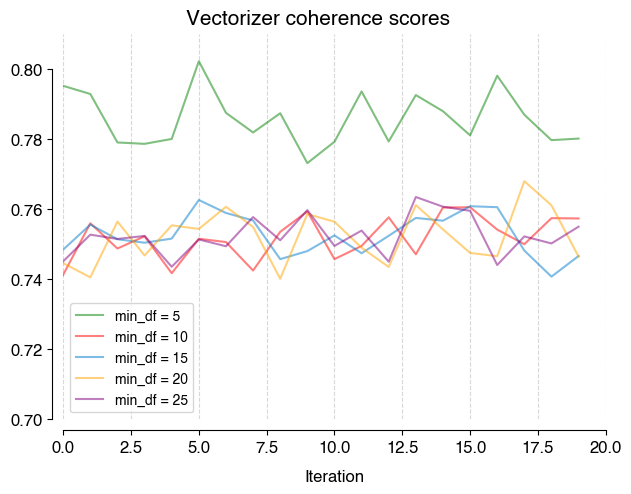

In [891]:
import seaborn as sns
#vectorizers coherence 2
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Vectorizer coherence scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0.7, 0.8))
ax.set_xlim(0,20)
ax.set_ylim(0.7,0.81)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(five[0], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(ten[0], color="red", alpha=0.5, linewidth = 1.5)
plt.plot(fifteen[0], color="#007ACC", alpha=0.5, linewidth = 1.5)
plt.plot(twenty[0], color="orange", alpha=0.5, linewidth = 1.5)
plt.plot(twentyfive[0], color="purple", alpha=0.5, linewidth = 1.5)

plt.legend(['min_df = 5', 'min_df = 10', 'min_df = 15', 'min_df = 20', 'min_df = 25'])

plt.show()

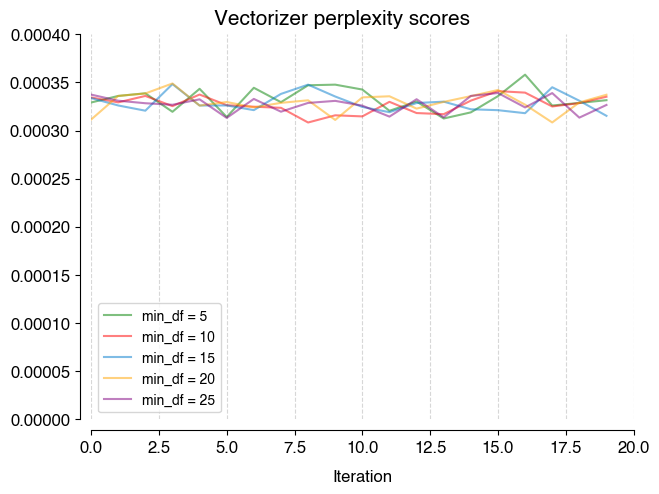

In [901]:
import seaborn as sns
#vectorizers perplexity 2
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Vectorizer perplexity scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0, 0.0004))
ax.set_xlim(0,20)
ax.set_ylim(0,0.0004)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(five[1], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(ten[1], color="red", alpha=0.5, linewidth = 1.5)
plt.plot(fifteen[1], color="#007ACC", alpha=0.5, linewidth = 1.5)
plt.plot(twenty[1], color="orange", alpha=0.5, linewidth = 1.5)
plt.plot(twentyfive[1], color="purple", alpha=0.5, linewidth = 1.5)

plt.legend(['min_df = 5', 'min_df = 10', 'min_df = 15', 'min_df = 20', 'min_df = 25'])

plt.show()

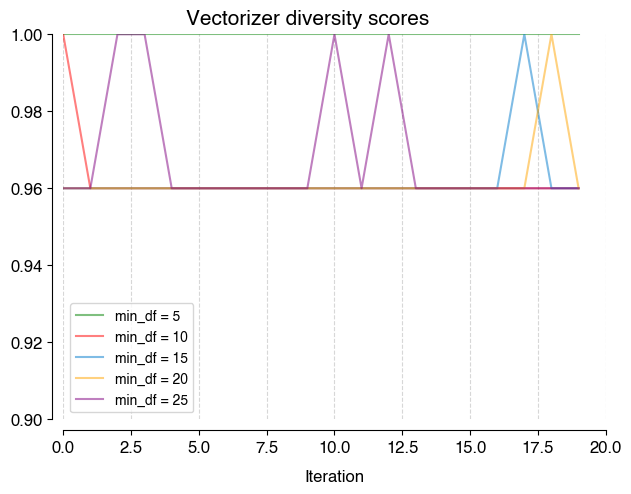

In [909]:
import seaborn as sns
#vectorizers diversity 2
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Vectorizer diversity scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0.9, 1))
ax.set_xlim(0,20)
ax.set_ylim(0.9,1)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(five[2], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(ten[2], color="red", alpha=0.5, linewidth = 1.5)
plt.plot(fifteen[2], color="#007ACC", alpha=0.5, linewidth = 1.5)
plt.plot(twenty[2], color="orange", alpha=0.5, linewidth = 1.5)
plt.plot(twentyfive[2], color="purple", alpha=0.5, linewidth = 1.5)

plt.legend(['min_df = 5', 'min_df = 10', 'min_df = 15', 'min_df = 20', 'min_df = 25'])

plt.show()

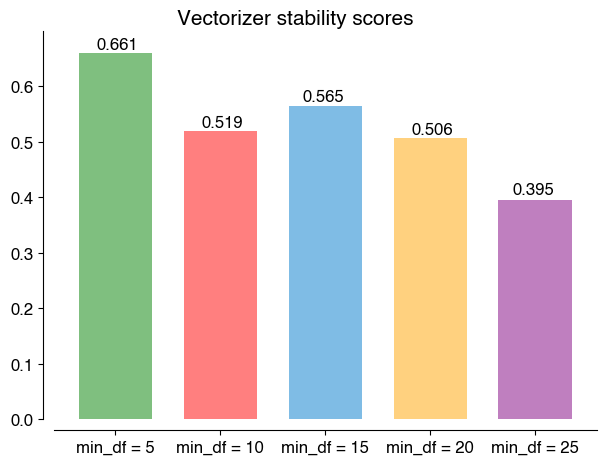

In [741]:
import seaborn as sns
#stability 2
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

#ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Vectorizer stability scores', fontsize=15, fontweight='black', color = 'black')

fig.text(0.185, 0.85, five[3], fontsize=12, fontweight='black', color = 'black')
fig.text(0.335, 0.695, ten[3], fontsize=12, fontweight='black', color = 'black')
fig.text(0.48, 0.745, fifteen[3], fontsize=12, fontweight='black', color = 'black')
fig.text(0.635, 0.68, twenty[3], fontsize=12, fontweight='black', color = 'black')
fig.text(0.78, 0.56, twentyfive[3], fontsize=12, fontweight='black', color = 'black')
         
stab = [five[3], ten[3], fifteen[3], twenty[3], twentyfive[3]]

stab_names = ['min_df = 5', 'min_df = 10', 'min_df = 15', 'min_df = 20', 'min_df = 25']
c = ['green', 'red', '#007ACC', 'orange', 'purple']

plt.bar(stab_names, stab, color=c, width = 0.7, alpha=0.5)
ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0, 0.7))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.show()

In [678]:
#bow
performance_scores_maxfeatures = {}
for i in tqdm(range(15000,20001,1000)):
    
    print("PARAMETER:", i)  
    
    vectorizer_model = CountVectorizer(max_features=i)
    
    topic_model = BERTopic(
      #embedding_model=embeddings[i]#,          # Step 1 - Extract embeddings
      #umap_model=dimensionality[i]#,                    # Step 2 - Reduce dimensionality
      #hdbscan_model=clustering[i]#,              # Step 3 - Cluster reduced embeddings
      vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
      #ctfidf_model=ctfidf_model
    )
    topic_model = BERTopic(verbose=False)
    stability_aux = {}
    coherence = []
    perplexity = []
    diversity = []
    stability = []
    for j in range(20):
        print("Iteration", j)

        print("--> Modeling topics...")
        topics, probs = topic_model.fit_transform(docs)
        topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
        print("--> Calculating Coherence...")
        coherence.append(coherence_score(docs, topics))

        print("--> Calculating Perplexity...")
        perplexity.append(perplexity_score(probs))

        print("--> Calculating Diversity...")
        diversity_value, unique_words = diversity_score(topic_model)
        diversity.append(diversity_value)
        stability_aux[j] = unique_words
    print("--> Calculating Stability...")
    stability = stability_score(stability_aux)
    #save model performance scores
    performance_scores_maxfeatures[i] = [coherence, perplexity, diversity, stability]
    print("---------------------------")



  0%|                                                     | 0/6 [00:00<?, ?it/s]

PARAMETER: 15000
Iteration 0
--> Modeling topics...


2023-09-17 20:24:38,397 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:24:41,260 - BERTopic - Reduced dimensionality
2023-09-17 20:24:41,345 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...


2023-09-17 20:25:05,550 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:25:09,166 - BERTopic - Reduced dimensionality
2023-09-17 20:25:09,255 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...


2023-09-17 20:25:32,044 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:25:34,909 - BERTopic - Reduced dimensionality
2023-09-17 20:25:34,996 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...


2023-09-17 20:25:57,981 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:26:00,978 - BERTopic - Reduced dimensionality
2023-09-17 20:26:01,067 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...


2023-09-17 20:26:23,674 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:26:26,505 - BERTopic - Reduced dimensionality
2023-09-17 20:26:26,592 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...


2023-09-17 20:26:48,793 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:26:51,701 - BERTopic - Reduced dimensionality
2023-09-17 20:26:51,791 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...


2023-09-17 20:27:14,925 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:27:17,836 - BERTopic - Reduced dimensionality
2023-09-17 20:27:17,929 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...


2023-09-17 20:27:39,919 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:27:42,773 - BERTopic - Reduced dimensionality
2023-09-17 20:27:42,864 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> Modeling topics...


2023-09-17 20:28:05,836 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:28:08,908 - BERTopic - Reduced dimensionality
2023-09-17 20:28:08,998 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 9
--> Modeling topics...


2023-09-17 20:28:31,750 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:28:34,648 - BERTopic - Reduced dimensionality
2023-09-17 20:28:34,742 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 10
--> Modeling topics...


2023-09-17 20:28:58,339 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:29:01,183 - BERTopic - Reduced dimensionality
2023-09-17 20:29:01,270 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 11
--> Modeling topics...


2023-09-17 20:29:23,734 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:29:26,566 - BERTopic - Reduced dimensionality
2023-09-17 20:29:26,655 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 12
--> Modeling topics...


2023-09-17 20:29:48,786 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:29:51,747 - BERTopic - Reduced dimensionality
2023-09-17 20:29:51,837 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 13
--> Modeling topics...


2023-09-17 20:30:15,694 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:30:18,736 - BERTopic - Reduced dimensionality
2023-09-17 20:30:18,826 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 14
--> Modeling topics...


2023-09-17 20:30:40,965 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:30:43,867 - BERTopic - Reduced dimensionality
2023-09-17 20:30:43,953 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 15
--> Modeling topics...


2023-09-17 20:31:06,932 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:31:09,957 - BERTopic - Reduced dimensionality
2023-09-17 20:31:10,048 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 16
--> Modeling topics...


2023-09-17 20:31:33,399 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:31:36,272 - BERTopic - Reduced dimensionality
2023-09-17 20:31:36,367 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 17
--> Modeling topics...


2023-09-17 20:31:58,971 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:32:01,904 - BERTopic - Reduced dimensionality
2023-09-17 20:32:01,997 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 18
--> Modeling topics...


2023-09-17 20:32:25,850 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:32:29,753 - BERTopic - Reduced dimensionality
2023-09-17 20:32:29,843 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 19
--> Modeling topics...


2023-09-17 20:32:52,743 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:32:55,734 - BERTopic - Reduced dimensionality
2023-09-17 20:32:55,825 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...



 17%|███████▎                                    | 1/6 [08:39<43:19, 519.92s/it]

--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------
PARAMETER: 16000
Iteration 0
--> Modeling topics...


2023-09-17 20:33:18,005 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:33:20,908 - BERTopic - Reduced dimensionality
2023-09-17 20:33:21,006 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...


2023-09-17 20:33:44,984 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:33:48,031 - BERTopic - Reduced dimensionality
2023-09-17 20:33:48,126 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...


2023-09-17 20:34:10,635 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:34:13,560 - BERTopic - Reduced dimensionality
2023-09-17 20:34:13,648 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...


2023-09-17 20:34:35,066 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:34:38,834 - BERTopic - Reduced dimensionality
2023-09-17 20:34:38,923 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...


2023-09-17 20:35:00,656 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:35:03,530 - BERTopic - Reduced dimensionality
2023-09-17 20:35:03,621 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...


2023-09-17 20:35:25,650 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:35:28,627 - BERTopic - Reduced dimensionality
2023-09-17 20:35:28,719 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...


2023-09-17 20:35:50,356 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:35:54,165 - BERTopic - Reduced dimensionality
2023-09-17 20:35:54,248 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...


2023-09-17 20:36:15,515 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:36:18,439 - BERTopic - Reduced dimensionality
2023-09-17 20:36:18,530 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> Modeling topics...


2023-09-17 20:36:40,795 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:36:43,680 - BERTopic - Reduced dimensionality
2023-09-17 20:36:43,770 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 9
--> Modeling topics...


2023-09-17 20:37:05,938 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:37:09,885 - BERTopic - Reduced dimensionality
2023-09-17 20:37:09,973 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 10
--> Modeling topics...


2023-09-17 20:37:32,345 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:37:35,283 - BERTopic - Reduced dimensionality
2023-09-17 20:37:35,372 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 11
--> Modeling topics...


2023-09-17 20:37:58,049 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:38:01,039 - BERTopic - Reduced dimensionality
2023-09-17 20:38:01,126 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 12
--> Modeling topics...


2023-09-17 20:38:23,432 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:38:27,561 - BERTopic - Reduced dimensionality
2023-09-17 20:38:27,650 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 13
--> Modeling topics...


2023-09-17 20:38:51,028 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:38:54,090 - BERTopic - Reduced dimensionality
2023-09-17 20:38:54,177 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 14
--> Modeling topics...


2023-09-17 20:39:16,770 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:39:19,733 - BERTopic - Reduced dimensionality
2023-09-17 20:39:19,828 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 15
--> Modeling topics...


2023-09-17 20:39:43,900 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:39:46,865 - BERTopic - Reduced dimensionality
2023-09-17 20:39:46,956 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 16
--> Modeling topics...


2023-09-17 20:40:09,657 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:40:12,805 - BERTopic - Reduced dimensionality
2023-09-17 20:40:12,896 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 17
--> Modeling topics...


2023-09-17 20:40:33,578 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:40:36,432 - BERTopic - Reduced dimensionality
2023-09-17 20:40:36,522 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 18
--> Modeling topics...


2023-09-17 20:40:58,727 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:41:01,570 - BERTopic - Reduced dimensionality
2023-09-17 20:41:01,660 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 19
--> Modeling topics...


2023-09-17 20:41:22,954 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:41:25,864 - BERTopic - Reduced dimensionality
2023-09-17 20:41:25,952 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...



 33%|██████████████▋                             | 2/6 [17:09<34:16, 514.04s/it]

--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------
PARAMETER: 17000
Iteration 0
--> Modeling topics...


2023-09-17 20:41:48,544 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:41:51,371 - BERTopic - Reduced dimensionality
2023-09-17 20:41:51,461 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...


2023-09-17 20:42:13,379 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:42:16,394 - BERTopic - Reduced dimensionality
2023-09-17 20:42:16,484 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...


2023-09-17 20:42:37,933 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:42:40,745 - BERTopic - Reduced dimensionality
2023-09-17 20:42:40,830 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...


2023-09-17 20:43:02,492 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:43:05,307 - BERTopic - Reduced dimensionality
2023-09-17 20:43:05,393 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...


2023-09-17 20:43:28,336 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:43:31,180 - BERTopic - Reduced dimensionality
2023-09-17 20:43:31,272 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...


2023-09-17 20:43:53,890 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:43:56,930 - BERTopic - Reduced dimensionality
2023-09-17 20:43:57,021 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...


2023-09-17 20:44:20,548 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:44:23,547 - BERTopic - Reduced dimensionality
2023-09-17 20:44:23,638 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...


2023-09-17 20:44:46,644 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:44:49,534 - BERTopic - Reduced dimensionality
2023-09-17 20:44:49,620 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> Modeling topics...


2023-09-17 20:45:12,385 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:45:15,430 - BERTopic - Reduced dimensionality
2023-09-17 20:45:15,527 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 9
--> Modeling topics...


2023-09-17 20:45:39,410 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:45:42,426 - BERTopic - Reduced dimensionality
2023-09-17 20:45:42,516 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 10
--> Modeling topics...


2023-09-17 20:46:04,830 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:46:07,662 - BERTopic - Reduced dimensionality
2023-09-17 20:46:07,752 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 11
--> Modeling topics...


2023-09-17 20:46:31,883 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:46:35,008 - BERTopic - Reduced dimensionality
2023-09-17 20:46:35,100 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 12
--> Modeling topics...


2023-09-17 20:46:58,305 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:47:01,259 - BERTopic - Reduced dimensionality
2023-09-17 20:47:01,346 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 13
--> Modeling topics...


2023-09-17 20:47:24,164 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:47:27,287 - BERTopic - Reduced dimensionality
2023-09-17 20:47:27,376 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 14
--> Modeling topics...


2023-09-17 20:47:50,870 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:47:53,830 - BERTopic - Reduced dimensionality
2023-09-17 20:47:53,922 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 15
--> Modeling topics...


2023-09-17 20:48:16,670 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:48:19,652 - BERTopic - Reduced dimensionality
2023-09-17 20:48:19,741 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 16
--> Modeling topics...


2023-09-17 20:48:42,581 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:48:45,569 - BERTopic - Reduced dimensionality
2023-09-17 20:48:45,656 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 17
--> Modeling topics...


2023-09-17 20:49:07,680 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:49:10,514 - BERTopic - Reduced dimensionality
2023-09-17 20:49:10,603 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 18
--> Modeling topics...


2023-09-17 20:49:32,669 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:49:35,499 - BERTopic - Reduced dimensionality
2023-09-17 20:49:35,585 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 19
--> Modeling topics...


2023-09-17 20:49:58,064 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:50:00,898 - BERTopic - Reduced dimensionality
2023-09-17 20:50:00,989 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...



 50%|██████████████████████                      | 3/6 [25:44<25:42, 514.29s/it]

--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------
PARAMETER: 18000
Iteration 0
--> Modeling topics...


2023-09-17 20:50:22,996 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:50:25,855 - BERTopic - Reduced dimensionality
2023-09-17 20:50:25,946 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...


2023-09-17 20:50:48,535 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:50:51,393 - BERTopic - Reduced dimensionality
2023-09-17 20:50:51,481 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...


2023-09-17 20:51:13,925 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:51:16,779 - BERTopic - Reduced dimensionality
2023-09-17 20:51:16,869 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...


2023-09-17 20:51:40,438 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:51:43,300 - BERTopic - Reduced dimensionality
2023-09-17 20:51:43,390 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...


2023-09-17 20:52:06,895 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:52:09,899 - BERTopic - Reduced dimensionality
2023-09-17 20:52:09,987 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...


2023-09-17 20:52:32,407 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:52:35,274 - BERTopic - Reduced dimensionality
2023-09-17 20:52:35,361 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...


2023-09-17 20:53:00,246 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:53:03,347 - BERTopic - Reduced dimensionality
2023-09-17 20:53:03,438 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...


2023-09-17 20:53:25,306 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:53:28,161 - BERTopic - Reduced dimensionality
2023-09-17 20:53:28,259 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> Modeling topics...


2023-09-17 20:53:51,517 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:53:54,513 - BERTopic - Reduced dimensionality
2023-09-17 20:53:54,602 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 9
--> Modeling topics...


2023-09-17 20:54:18,744 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:54:21,790 - BERTopic - Reduced dimensionality
2023-09-17 20:54:21,886 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 10
--> Modeling topics...


2023-09-17 20:54:45,321 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:54:48,293 - BERTopic - Reduced dimensionality
2023-09-17 20:54:48,386 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 11
--> Modeling topics...


2023-09-17 20:55:11,236 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:55:14,211 - BERTopic - Reduced dimensionality
2023-09-17 20:55:14,303 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 12
--> Modeling topics...


2023-09-17 20:55:37,870 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:55:40,866 - BERTopic - Reduced dimensionality
2023-09-17 20:55:40,953 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 13
--> Modeling topics...


2023-09-17 20:56:03,390 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:56:06,303 - BERTopic - Reduced dimensionality
2023-09-17 20:56:06,391 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 14
--> Modeling topics...


2023-09-17 20:56:28,740 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:56:31,580 - BERTopic - Reduced dimensionality
2023-09-17 20:56:31,669 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 15
--> Modeling topics...


2023-09-17 20:56:55,339 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:56:58,241 - BERTopic - Reduced dimensionality
2023-09-17 20:56:58,326 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 16
--> Modeling topics...


2023-09-17 20:57:21,691 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:57:24,507 - BERTopic - Reduced dimensionality
2023-09-17 20:57:24,601 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 17
--> Modeling topics...


2023-09-17 20:57:48,565 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:57:51,508 - BERTopic - Reduced dimensionality
2023-09-17 20:57:51,598 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 18
--> Modeling topics...


2023-09-17 20:58:16,166 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:58:19,220 - BERTopic - Reduced dimensionality
2023-09-17 20:58:19,311 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 19
--> Modeling topics...


2023-09-17 20:58:42,282 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:58:45,292 - BERTopic - Reduced dimensionality
2023-09-17 20:58:45,380 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...



 67%|█████████████████████████████▎              | 4/6 [34:29<17:17, 518.55s/it]

--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------
PARAMETER: 19000
Iteration 0
--> Modeling topics...


2023-09-17 20:59:08,434 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:59:11,320 - BERTopic - Reduced dimensionality
2023-09-17 20:59:11,409 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...


2023-09-17 20:59:35,294 - BERTopic - Transformed documents to Embeddings
2023-09-17 20:59:38,373 - BERTopic - Reduced dimensionality
2023-09-17 20:59:38,461 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...


2023-09-17 21:00:02,141 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:00:05,169 - BERTopic - Reduced dimensionality
2023-09-17 21:00:05,262 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...


2023-09-17 21:00:27,184 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:00:30,083 - BERTopic - Reduced dimensionality
2023-09-17 21:00:30,173 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...


2023-09-17 21:00:53,854 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:00:56,735 - BERTopic - Reduced dimensionality
2023-09-17 21:00:56,826 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...


2023-09-17 21:01:19,188 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:01:22,228 - BERTopic - Reduced dimensionality
2023-09-17 21:01:22,321 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...


2023-09-17 21:01:45,207 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:01:48,468 - BERTopic - Reduced dimensionality
2023-09-17 21:01:48,566 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...


2023-09-17 21:02:10,529 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:02:13,530 - BERTopic - Reduced dimensionality
2023-09-17 21:02:13,620 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> Modeling topics...


2023-09-17 21:02:37,518 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:02:40,447 - BERTopic - Reduced dimensionality
2023-09-17 21:02:40,539 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 9
--> Modeling topics...


2023-09-17 21:03:03,286 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:03:06,138 - BERTopic - Reduced dimensionality
2023-09-17 21:03:06,225 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 10
--> Modeling topics...


2023-09-17 21:03:28,636 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:03:32,521 - BERTopic - Reduced dimensionality
2023-09-17 21:03:32,608 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 11
--> Modeling topics...


2023-09-17 21:03:54,866 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:03:57,869 - BERTopic - Reduced dimensionality
2023-09-17 21:03:57,961 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 12
--> Modeling topics...


2023-09-17 21:04:20,525 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:04:23,463 - BERTopic - Reduced dimensionality
2023-09-17 21:04:23,550 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 13
--> Modeling topics...


2023-09-17 21:04:45,943 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:04:49,022 - BERTopic - Reduced dimensionality
2023-09-17 21:04:49,110 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 14
--> Modeling topics...


2023-09-17 21:05:12,071 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:05:14,992 - BERTopic - Reduced dimensionality
2023-09-17 21:05:15,079 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 15
--> Modeling topics...


2023-09-17 21:05:37,698 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:05:40,558 - BERTopic - Reduced dimensionality
2023-09-17 21:05:40,647 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 16
--> Modeling topics...


2023-09-17 21:06:03,420 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:06:06,379 - BERTopic - Reduced dimensionality
2023-09-17 21:06:06,468 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 17
--> Modeling topics...


2023-09-17 21:06:30,404 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:06:33,395 - BERTopic - Reduced dimensionality
2023-09-17 21:06:33,488 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 18
--> Modeling topics...


2023-09-17 21:06:55,887 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:06:58,766 - BERTopic - Reduced dimensionality
2023-09-17 21:06:58,852 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 19
--> Modeling topics...


2023-09-17 21:07:21,676 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:07:24,660 - BERTopic - Reduced dimensionality
2023-09-17 21:07:24,751 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...



 83%|████████████████████████████████████▋       | 5/6 [43:10<08:39, 519.30s/it]

--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------
PARAMETER: 20000
Iteration 0
--> Modeling topics...


2023-09-17 21:07:49,062 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:07:52,136 - BERTopic - Reduced dimensionality
2023-09-17 21:07:52,223 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...


2023-09-17 21:08:14,199 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:08:17,045 - BERTopic - Reduced dimensionality
2023-09-17 21:08:17,133 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...


2023-09-17 21:08:40,630 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:08:43,739 - BERTopic - Reduced dimensionality
2023-09-17 21:08:43,832 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...


2023-09-17 21:09:05,841 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:09:08,781 - BERTopic - Reduced dimensionality
2023-09-17 21:09:08,873 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...


2023-09-17 21:09:31,700 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:09:34,570 - BERTopic - Reduced dimensionality
2023-09-17 21:09:34,659 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...


2023-09-17 21:09:56,780 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:09:59,706 - BERTopic - Reduced dimensionality
2023-09-17 21:09:59,803 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...


2023-09-17 21:10:22,925 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:10:26,031 - BERTopic - Reduced dimensionality
2023-09-17 21:10:26,124 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...


2023-09-17 21:10:48,150 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:10:51,003 - BERTopic - Reduced dimensionality
2023-09-17 21:10:51,087 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> Modeling topics...


2023-09-17 21:11:15,132 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:11:18,011 - BERTopic - Reduced dimensionality
2023-09-17 21:11:18,098 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 9
--> Modeling topics...


2023-09-17 21:11:40,538 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:11:43,487 - BERTopic - Reduced dimensionality
2023-09-17 21:11:43,582 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 10
--> Modeling topics...


2023-09-17 21:12:05,649 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:12:08,508 - BERTopic - Reduced dimensionality
2023-09-17 21:12:08,593 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 11
--> Modeling topics...


2023-09-17 21:12:31,295 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:12:34,230 - BERTopic - Reduced dimensionality
2023-09-17 21:12:34,319 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 12
--> Modeling topics...


2023-09-17 21:12:56,667 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:12:59,507 - BERTopic - Reduced dimensionality
2023-09-17 21:12:59,596 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 13
--> Modeling topics...


2023-09-17 21:13:22,079 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:13:24,998 - BERTopic - Reduced dimensionality
2023-09-17 21:13:25,086 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 14
--> Modeling topics...


2023-09-17 21:13:46,877 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:13:49,752 - BERTopic - Reduced dimensionality
2023-09-17 21:13:49,839 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 15
--> Modeling topics...


2023-09-17 21:14:11,792 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:14:14,646 - BERTopic - Reduced dimensionality
2023-09-17 21:14:14,735 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 16
--> Modeling topics...


2023-09-17 21:14:37,993 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:14:40,855 - BERTopic - Reduced dimensionality
2023-09-17 21:14:40,940 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 17
--> Modeling topics...


2023-09-17 21:15:02,895 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:15:05,770 - BERTopic - Reduced dimensionality
2023-09-17 21:15:05,857 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 18
--> Modeling topics...


2023-09-17 21:15:29,565 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:15:32,392 - BERTopic - Reduced dimensionality
2023-09-17 21:15:32,487 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 19
--> Modeling topics...


2023-09-17 21:15:55,233 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:15:58,086 - BERTopic - Reduced dimensionality
2023-09-17 21:15:58,178 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...


100%|████████████████████████████████████████████| 6/6 [51:42<00:00, 517.01s/it]

--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------


In [743]:
performance_scores_maxfeatures.keys()

dict_keys([15000, 16000, 17000, 18000, 19000, 20000])

In [744]:
five = performance_scores_maxfeatures[15000]
ten = performance_scores_maxfeatures[16000]
fifteen = performance_scores_maxfeatures[17000]
twenty  = performance_scores_maxfeatures[18000]
twentyfive = performance_scores_maxfeatures[19000]
thirty = performance_scores_maxfeatures[20000]

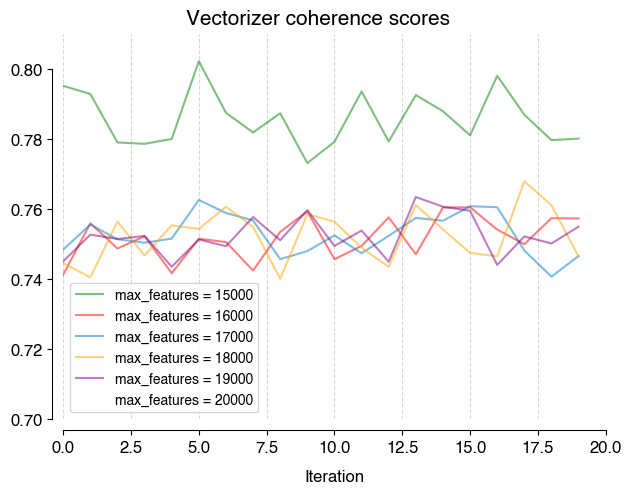

In [890]:
import seaborn as sns
#vectorizers coherence 3
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Vectorizer coherence scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0.7, 0.8))
ax.set_xlim(0,20)
ax.set_ylim(0.7,0.81)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(five[0], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(ten[0], color="red", alpha=0.5, linewidth = 1.5)
plt.plot(fifteen[0], color="#007ACC", alpha=0.5, linewidth = 1.5)
plt.plot(twenty[0], color="orange", alpha=0.5, linewidth = 1.5)
plt.plot(twentyfive[0], color="purple", alpha=0.5, linewidth = 1.5)
plt.plot(thirty[0], color="pink", alpha=0, linewidth = 1.5)

plt.legend(['max_features = 15000', 'max_features = 16000', 'max_features = 17000', 
            'max_features = 18000', 'max_features = 19000', 'max_features = 20000'])

plt.show()

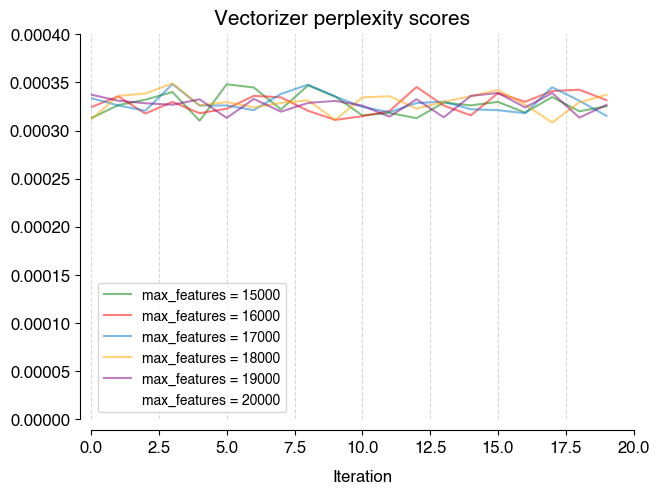

In [753]:
import seaborn as sns
#vectorizers perplexity 3
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Vectorizer perplexity scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0, 0.0004))
ax.set_xlim(0,20)
ax.set_ylim(0,0.0004)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(five[1], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(ten[1], color="red", alpha=0.5, linewidth = 1.5)
plt.plot(fifteen[1], color="#007ACC", alpha=0.5, linewidth = 1.5)
plt.plot(twenty[1], color="orange", alpha=0.5, linewidth = 1.5)
plt.plot(twentyfive[1], color="purple", alpha=0.5, linewidth = 1.5)
plt.plot(thirty[1], color="pink", alpha=0, linewidth = 1.5)

plt.legend(['max_features = 15000', 'max_features = 16000', 'max_features = 17000', 
            'max_features = 18000', 'max_features = 19000', 'max_features = 20000'])

plt.show()

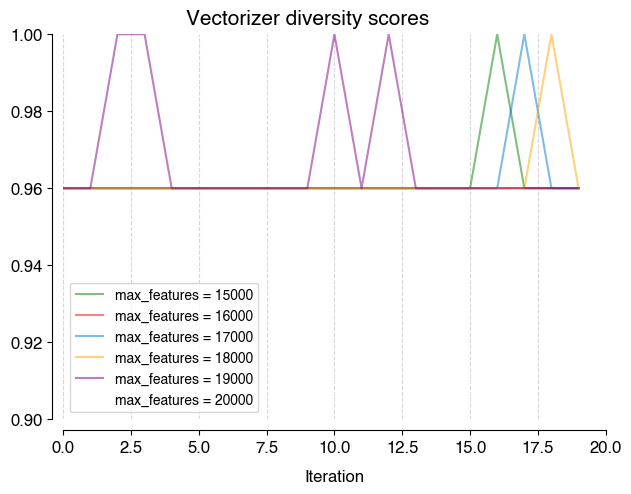

In [755]:
import seaborn as sns
#vectorizers perplexity 3
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Vectorizer diversity scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0.9, 1))
ax.set_xlim(0,20)
ax.set_ylim(0.9,1)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(five[2], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(ten[2], color="red", alpha=0.5, linewidth = 1.5)
plt.plot(fifteen[2], color="#007ACC", alpha=0.5, linewidth = 1.5)
plt.plot(twenty[2], color="orange", alpha=0.5, linewidth = 1.5)
plt.plot(twentyfive[2], color="purple", alpha=0.5, linewidth = 1.5)
plt.plot(thirty[2], color="pink", alpha=0, linewidth = 1.5)

plt.legend(['max_features = 15000', 'max_features = 16000', 'max_features = 17000', 
            'max_features = 18000', 'max_features = 19000', 'max_features = 20000'])

plt.show()

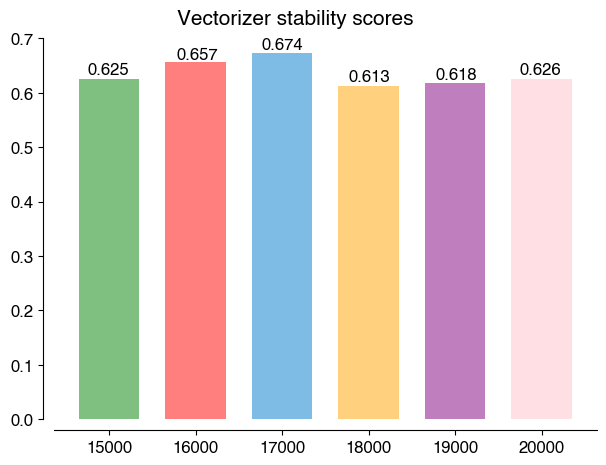

In [811]:
import seaborn as sns
#stability 3
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

#ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Vectorizer stability scores', fontsize=15, fontweight='black', color = 'black')

fig.text(0.173, 0.8, five[3], fontsize=12, fontweight='black', color = 'black')
fig.text(0.3, 0.83, ten[3], fontsize=12, fontweight='black', color = 'black')
fig.text(0.4209, 0.85, fifteen[3], fontsize=12, fontweight='black', color = 'black')
fig.text(0.545, 0.785, twenty[3], fontsize=12, fontweight='black', color = 'black')
fig.text(0.67, 0.79, twentyfive[3], fontsize=12, fontweight='black', color = 'black')
fig.text(0.79, 0.8, thirty[3], fontsize=12, fontweight='black', color = 'black')
         
stab = [five[3], ten[3], fifteen[3], twenty[3], twentyfive[3], thirty[3]]

stab_names = ['15000', '16000', '17000', '18000', '19000', '20000']
c = ['green', 'red', '#007ACC', 'orange', 'purple', 'pink']

plt.bar(stab_names, stab, color=c, width = 0.7, alpha=0.5)
ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0, 0.7))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
#plt.xticks(rotation=30)
sns.despine()

plt.show()

#### Topic Representation

In [679]:
topic_representations = [True, False]

In [680]:
#topic
performance_scores_bm25 = {}
for i in topic_representations:
    
    print("PARAMETER:", i)
    
    from bertopic.vectorizers import ClassTfidfTransformer

    ctfidf_model = ClassTfidfTransformer(bm25_weighting=i)
    topic_model = BERTopic(ctfidf_model=ctfidf_model)
    
    stability_aux = {}
    coherence = []
    perplexity = []
    diversity = []
    stability = []
    for j in range(20):
        print("Iteration", j)

        print("--> Modeling topics...")
        topics, probs = topic_model.fit_transform(docs)

        print("--> Calculating Coherence...")
        coherence.append(coherence_score(docs, topics))

        print("--> Calculating Perplexity...")
        perplexity.append(perplexity_score(probs))

        print("--> Calculating Diversity...")
        diversity_value, unique_words = diversity_score(topic_model)
        diversity.append(diversity_value)
        stability_aux[j] = unique_words
    print("--> Calculating Stability...")
    stability = stability_score(stability_aux)
    #save model performance scores
    performance_scores_bm25[i] = [coherence, perplexity, diversity, stability]
    print("---------------------------")


PARAMETER: True
Iteration 0
--> Modeling topics...


2023-09-17 21:16:59,760 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:17:02,680 - BERTopic - Reduced dimensionality
2023-09-17 21:17:02,768 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...


2023-09-17 21:17:25,072 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:17:28,095 - BERTopic - Reduced dimensionality
2023-09-17 21:17:28,182 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...


2023-09-17 21:17:49,830 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:17:52,709 - BERTopic - Reduced dimensionality
2023-09-17 21:17:52,800 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...


2023-09-17 21:18:14,614 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:18:17,511 - BERTopic - Reduced dimensionality
2023-09-17 21:18:17,593 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...


2023-09-17 21:18:38,838 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:18:41,871 - BERTopic - Reduced dimensionality
2023-09-17 21:18:41,957 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...


2023-09-17 21:19:03,341 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:19:06,232 - BERTopic - Reduced dimensionality
2023-09-17 21:19:06,323 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...


2023-09-17 21:19:27,865 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:19:30,737 - BERTopic - Reduced dimensionality
2023-09-17 21:19:30,825 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...


2023-09-17 21:19:52,962 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:19:55,943 - BERTopic - Reduced dimensionality
2023-09-17 21:19:56,034 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> Modeling topics...


2023-09-17 21:20:17,146 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:20:20,243 - BERTopic - Reduced dimensionality
2023-09-17 21:20:20,335 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 9
--> Modeling topics...


2023-09-17 21:20:42,774 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:20:45,771 - BERTopic - Reduced dimensionality
2023-09-17 21:20:45,865 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 10
--> Modeling topics...


2023-09-17 21:21:07,130 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:21:09,945 - BERTopic - Reduced dimensionality
2023-09-17 21:21:10,037 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 11
--> Modeling topics...


2023-09-17 21:21:31,400 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:21:34,282 - BERTopic - Reduced dimensionality
2023-09-17 21:21:34,368 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 12
--> Modeling topics...


2023-09-17 21:21:56,419 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:21:59,337 - BERTopic - Reduced dimensionality
2023-09-17 21:21:59,424 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 13
--> Modeling topics...


2023-09-17 21:22:20,949 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:22:23,950 - BERTopic - Reduced dimensionality
2023-09-17 21:22:24,038 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 14
--> Modeling topics...


2023-09-17 21:22:45,008 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:22:47,993 - BERTopic - Reduced dimensionality
2023-09-17 21:22:48,087 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 15
--> Modeling topics...


2023-09-17 21:23:10,210 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:23:13,088 - BERTopic - Reduced dimensionality
2023-09-17 21:23:13,173 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 16
--> Modeling topics...


2023-09-17 21:23:34,160 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:23:37,081 - BERTopic - Reduced dimensionality
2023-09-17 21:23:37,169 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 17
--> Modeling topics...


2023-09-17 21:23:58,398 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:24:01,287 - BERTopic - Reduced dimensionality
2023-09-17 21:24:01,384 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 18
--> Modeling topics...


2023-09-17 21:24:23,281 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:24:26,130 - BERTopic - Reduced dimensionality
2023-09-17 21:24:26,216 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 19
--> Modeling topics...


2023-09-17 21:24:47,522 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:24:50,506 - BERTopic - Reduced dimensionality
2023-09-17 21:24:50,596 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------
PARAMETER: False
Iteration 0
--> Modeling topics...


2023-09-17 21:25:11,634 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:25:14,568 - BERTopic - Reduced dimensionality
2023-09-17 21:25:14,653 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...


2023-09-17 21:25:36,896 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:25:39,728 - BERTopic - Reduced dimensionality
2023-09-17 21:25:39,811 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...


2023-09-17 21:26:00,894 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:26:03,770 - BERTopic - Reduced dimensionality
2023-09-17 21:26:03,860 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...


2023-09-17 21:26:25,270 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:26:28,165 - BERTopic - Reduced dimensionality
2023-09-17 21:26:28,251 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...


2023-09-17 21:26:49,120 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:26:53,007 - BERTopic - Reduced dimensionality
2023-09-17 21:26:53,094 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...


2023-09-17 21:27:14,181 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:27:17,096 - BERTopic - Reduced dimensionality
2023-09-17 21:27:17,187 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...


2023-09-17 21:27:38,829 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:27:41,716 - BERTopic - Reduced dimensionality
2023-09-17 21:27:41,810 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...


2023-09-17 21:28:03,785 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:28:06,656 - BERTopic - Reduced dimensionality
2023-09-17 21:28:06,748 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> Modeling topics...


2023-09-17 21:28:27,287 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:28:30,150 - BERTopic - Reduced dimensionality
2023-09-17 21:28:30,237 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 9
--> Modeling topics...


2023-09-17 21:28:50,873 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:28:53,787 - BERTopic - Reduced dimensionality
2023-09-17 21:28:53,878 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 10
--> Modeling topics...


2023-09-17 21:29:15,841 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:29:18,694 - BERTopic - Reduced dimensionality
2023-09-17 21:29:18,784 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 11
--> Modeling topics...


2023-09-17 21:29:41,243 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:29:44,123 - BERTopic - Reduced dimensionality
2023-09-17 21:29:44,213 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 12
--> Modeling topics...


2023-09-17 21:30:05,399 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:30:08,253 - BERTopic - Reduced dimensionality
2023-09-17 21:30:08,341 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 13
--> Modeling topics...


2023-09-17 21:30:29,433 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:30:32,351 - BERTopic - Reduced dimensionality
2023-09-17 21:30:32,436 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 14
--> Modeling topics...


2023-09-17 21:30:55,064 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:30:57,916 - BERTopic - Reduced dimensionality
2023-09-17 21:30:58,008 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 15
--> Modeling topics...


2023-09-17 21:31:18,880 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:31:21,760 - BERTopic - Reduced dimensionality
2023-09-17 21:31:21,848 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 16
--> Modeling topics...


2023-09-17 21:31:42,891 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:31:45,700 - BERTopic - Reduced dimensionality
2023-09-17 21:31:45,786 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 17
--> Modeling topics...


2023-09-17 21:32:06,844 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:32:10,730 - BERTopic - Reduced dimensionality
2023-09-17 21:32:10,818 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 18
--> Modeling topics...


2023-09-17 21:32:31,531 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:32:34,398 - BERTopic - Reduced dimensionality
2023-09-17 21:32:34,483 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 19
--> Modeling topics...


2023-09-17 21:32:55,829 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:32:58,679 - BERTopic - Reduced dimensionality
2023-09-17 21:32:58,768 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------


In [813]:
five = performance_scores_bm25[True]
ten = performance_scores_bm25[False]

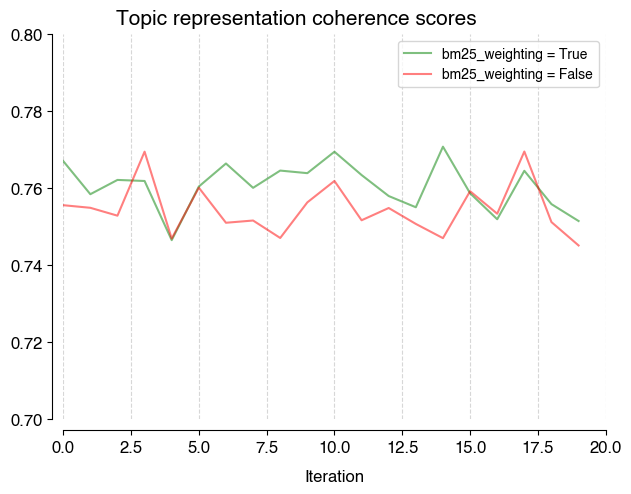

In [817]:
import seaborn as sns
#topicrepresentation coherence
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.2, 0.9, 'Topic representation coherence scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0.7, 0.8))
ax.set_xlim(0,20)
ax.set_ylim(0.7,0.8)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(five[0], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(ten[0], color="red", alpha=0.5, linewidth = 1.5)

plt.legend(['bm25_weighting = True', 'bm25_weighting = False'])

plt.show()

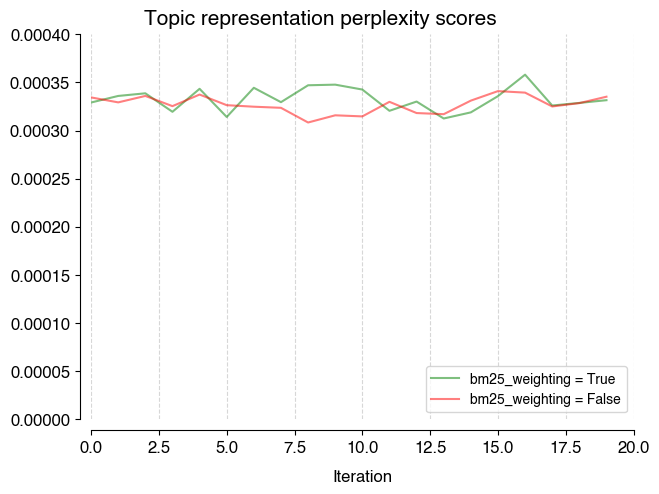

In [903]:
import seaborn as sns
#topicrepresentation perplexity
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.2, 0.9, 'Topic representation perplexity scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0, 0.0004))
ax.set_xlim(0,20)
ax.set_ylim(0,0.0004)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(five[1], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(ten[1], color="red", alpha=0.5, linewidth = 1.5)

plt.legend(['bm25_weighting = True', 'bm25_weighting = False'], loc = 'lower right')

plt.show()

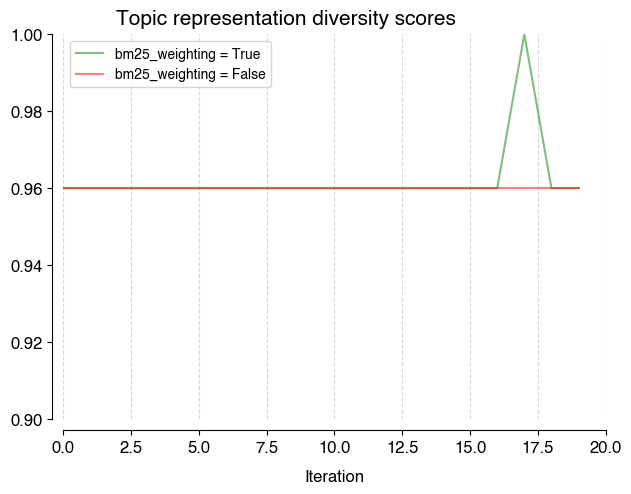

In [822]:
import seaborn as sns
#topicrepresentation diversity
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.2, 0.9, 'Topic representation diversity scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0.9, 1))
ax.set_xlim(0,20)
ax.set_ylim(0.9,1)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(five[2], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(ten[2], color="red", alpha=0.5, linewidth = 1.5)

plt.legend(['bm25_weighting = True', 'bm25_weighting = False'])

plt.show()

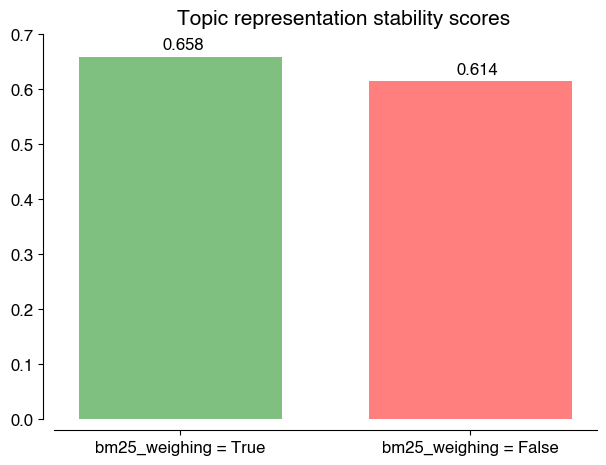

In [852]:
import seaborn as sns
#stability
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

#ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Topic representation stability scores', fontsize=15, fontweight='black', color = 'black')

fig.text(0.28, 0.85, five[3], fontsize=12, fontweight='black', color = 'black')
fig.text(0.7, 0.8, ten[3], fontsize=12, fontweight='black', color = 'black')

stab = [five[3], ten[3]]

stab_names = ['bm25_weighing = True', 'bm25_weighing = False']
c = ['green', 'red']

plt.bar(stab_names, stab, color=c, width = 0.7, alpha=0.5)
ax.set_ylim(0,0.7)
ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0, 0.7))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
#plt.xticks(rotation=30)
sns.despine()

plt.show()

In [681]:
#topic
performance_scores_reduce = {}
for i in topic_representations:
    
    print("PARAMETER:", i)
    
    from bertopic.vectorizers import ClassTfidfTransformer

    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=i)
    topic_model = BERTopic(ctfidf_model=ctfidf_model)
    
    stability_aux = {}
    coherence = []
    perplexity = []
    diversity = []
    stability = []
    for j in range(20):
        print("Iteration", j)

        print("--> Modeling topics...")
        topics, probs = topic_model.fit_transform(docs)

        print("--> Calculating Coherence...")
        coherence.append(coherence_score(docs, topics))

        print("--> Calculating Perplexity...")
        perplexity.append(perplexity_score(probs))

        print("--> Calculating Diversity...")
        diversity_value, unique_words = diversity_score(topic_model)
        diversity.append(diversity_value)
        stability_aux[j] = unique_words
    print("--> Calculating Stability...")
    stability = stability_score(stability_aux)
    #save model performance scores
    performance_scores_reduce[i] = [coherence, perplexity, diversity, stability]
    print("---------------------------")


PARAMETER: True
Iteration 0
--> Modeling topics...


2023-09-17 21:33:20,322 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:33:23,171 - BERTopic - Reduced dimensionality
2023-09-17 21:33:23,259 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...


2023-09-17 21:33:43,069 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:33:45,897 - BERTopic - Reduced dimensionality
2023-09-17 21:33:45,981 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...


2023-09-17 21:34:04,678 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:34:07,515 - BERTopic - Reduced dimensionality
2023-09-17 21:34:07,607 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...


2023-09-17 21:34:26,555 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:34:29,406 - BERTopic - Reduced dimensionality
2023-09-17 21:34:29,494 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...


2023-09-17 21:34:49,477 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:34:52,301 - BERTopic - Reduced dimensionality
2023-09-17 21:34:52,385 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...


2023-09-17 21:35:10,928 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:35:13,766 - BERTopic - Reduced dimensionality
2023-09-17 21:35:13,852 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...


2023-09-17 21:35:33,281 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:35:36,216 - BERTopic - Reduced dimensionality
2023-09-17 21:35:36,301 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...


2023-09-17 21:35:56,593 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:35:59,522 - BERTopic - Reduced dimensionality
2023-09-17 21:35:59,616 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> Modeling topics...


2023-09-17 21:36:18,625 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:36:21,473 - BERTopic - Reduced dimensionality
2023-09-17 21:36:21,561 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 9
--> Modeling topics...


2023-09-17 21:36:41,122 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:36:43,983 - BERTopic - Reduced dimensionality
2023-09-17 21:36:44,070 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 10
--> Modeling topics...


2023-09-17 21:37:02,919 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:37:06,784 - BERTopic - Reduced dimensionality
2023-09-17 21:37:06,869 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 11
--> Modeling topics...


2023-09-17 21:37:26,359 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:37:29,196 - BERTopic - Reduced dimensionality
2023-09-17 21:37:29,283 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 12
--> Modeling topics...


2023-09-17 21:37:48,491 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:37:51,340 - BERTopic - Reduced dimensionality
2023-09-17 21:37:51,428 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 13
--> Modeling topics...


2023-09-17 21:38:10,399 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:38:13,261 - BERTopic - Reduced dimensionality
2023-09-17 21:38:13,347 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 14
--> Modeling topics...


2023-09-17 21:38:34,364 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:38:37,370 - BERTopic - Reduced dimensionality
2023-09-17 21:38:37,467 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 15
--> Modeling topics...


2023-09-17 21:38:57,347 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:39:00,360 - BERTopic - Reduced dimensionality
2023-09-17 21:39:00,455 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 16
--> Modeling topics...


2023-09-17 21:39:21,311 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:39:24,198 - BERTopic - Reduced dimensionality
2023-09-17 21:39:24,290 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 17
--> Modeling topics...


2023-09-17 21:39:43,600 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:39:46,463 - BERTopic - Reduced dimensionality
2023-09-17 21:39:46,553 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 18
--> Modeling topics...


2023-09-17 21:40:06,368 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:40:09,758 - BERTopic - Reduced dimensionality
2023-09-17 21:40:09,851 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 19
--> Modeling topics...


2023-09-17 21:40:30,656 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:40:33,693 - BERTopic - Reduced dimensionality
2023-09-17 21:40:33,778 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------
PARAMETER: False
Iteration 0
--> Modeling topics...


2023-09-17 21:40:53,197 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:40:56,066 - BERTopic - Reduced dimensionality
2023-09-17 21:40:56,160 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 1
--> Modeling topics...


2023-09-17 21:41:18,235 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:41:21,046 - BERTopic - Reduced dimensionality
2023-09-17 21:41:21,134 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 2
--> Modeling topics...


2023-09-17 21:41:42,713 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:41:45,644 - BERTopic - Reduced dimensionality
2023-09-17 21:41:45,730 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 3
--> Modeling topics...


2023-09-17 21:42:08,889 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:42:11,866 - BERTopic - Reduced dimensionality
2023-09-17 21:42:11,956 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 4
--> Modeling topics...


2023-09-17 21:42:33,530 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:42:36,467 - BERTopic - Reduced dimensionality
2023-09-17 21:42:36,573 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 5
--> Modeling topics...


2023-09-17 21:42:58,842 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:43:01,834 - BERTopic - Reduced dimensionality
2023-09-17 21:43:01,921 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 6
--> Modeling topics...


2023-09-17 21:43:24,266 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:43:28,370 - BERTopic - Reduced dimensionality
2023-09-17 21:43:28,463 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 7
--> Modeling topics...


2023-09-17 21:43:50,435 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:43:53,402 - BERTopic - Reduced dimensionality
2023-09-17 21:43:53,490 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 8
--> Modeling topics...


2023-09-17 21:44:14,936 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:44:17,847 - BERTopic - Reduced dimensionality
2023-09-17 21:44:17,941 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 9
--> Modeling topics...


2023-09-17 21:44:39,630 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:44:42,565 - BERTopic - Reduced dimensionality
2023-09-17 21:44:42,652 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 10
--> Modeling topics...


2023-09-17 21:45:05,035 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:45:07,953 - BERTopic - Reduced dimensionality
2023-09-17 21:45:08,042 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 11
--> Modeling topics...


2023-09-17 21:45:28,920 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:45:31,825 - BERTopic - Reduced dimensionality
2023-09-17 21:45:31,914 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 12
--> Modeling topics...


2023-09-17 21:45:53,049 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:45:55,897 - BERTopic - Reduced dimensionality
2023-09-17 21:45:55,986 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 13
--> Modeling topics...


2023-09-17 21:46:18,992 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:46:21,844 - BERTopic - Reduced dimensionality
2023-09-17 21:46:21,931 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 14
--> Modeling topics...


2023-09-17 21:46:43,314 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:46:46,231 - BERTopic - Reduced dimensionality
2023-09-17 21:46:46,323 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 15
--> Modeling topics...


2023-09-17 21:47:07,434 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:47:10,368 - BERTopic - Reduced dimensionality
2023-09-17 21:47:10,456 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 16
--> Modeling topics...


2023-09-17 21:47:32,977 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:47:35,847 - BERTopic - Reduced dimensionality
2023-09-17 21:47:35,936 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 17
--> Modeling topics...


2023-09-17 21:47:57,146 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:48:00,118 - BERTopic - Reduced dimensionality
2023-09-17 21:48:00,215 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 18
--> Modeling topics...


2023-09-17 21:48:21,548 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:48:24,950 - BERTopic - Reduced dimensionality
2023-09-17 21:48:25,037 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
Iteration 19
--> Modeling topics...


2023-09-17 21:48:47,177 - BERTopic - Transformed documents to Embeddings
2023-09-17 21:48:50,036 - BERTopic - Reduced dimensionality
2023-09-17 21:48:50,126 - BERTopic - Clustered reduced embeddings


--> Calculating Coherence...
--> Calculating Perplexity...
--> Calculating Diversity...
--> Calculating Stability...
---------------------------


In [854]:
five = performance_scores_reduce[True]
ten = performance_scores_reduce[False]

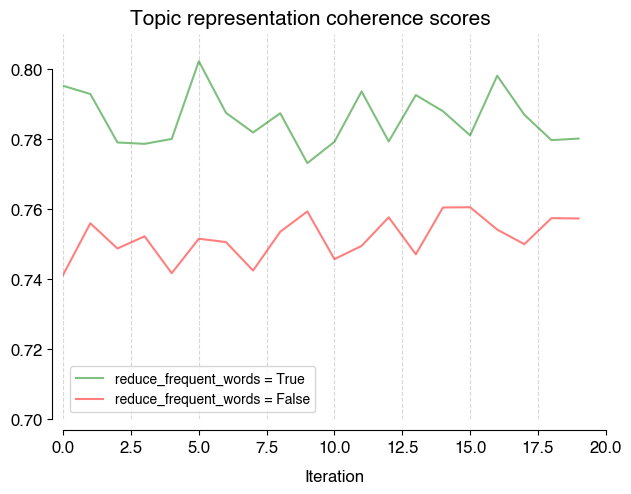

In [893]:
#topicrepresentation coherence
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.22, 0.9, 'Topic representation coherence scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0.7, 0.8))
ax.set_xlim(0,20)
ax.set_ylim(0.7,0.81)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(five[0], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(ten[0], color="red", alpha=0.5, linewidth = 1.5)

plt.legend(['reduce_frequent_words = True', 'reduce_frequent_words = False'])

plt.show()

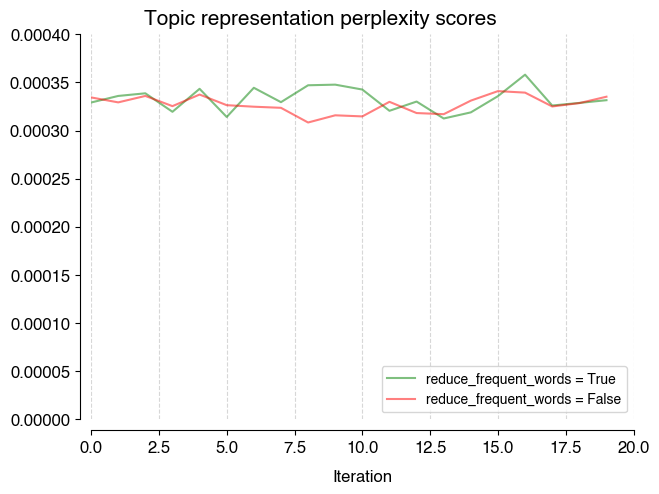

In [905]:
#topicrepresentation perplexity
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.2, 0.9, 'Topic representation perplexity scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0, 0.0004))
ax.set_xlim(0,20)
ax.set_ylim(0,0.0004)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(five[1], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(ten[1], color="red", alpha=0.5, linewidth = 1.5)

plt.legend(['reduce_frequent_words = True', 'reduce_frequent_words = False'], loc="lower right")

plt.show()

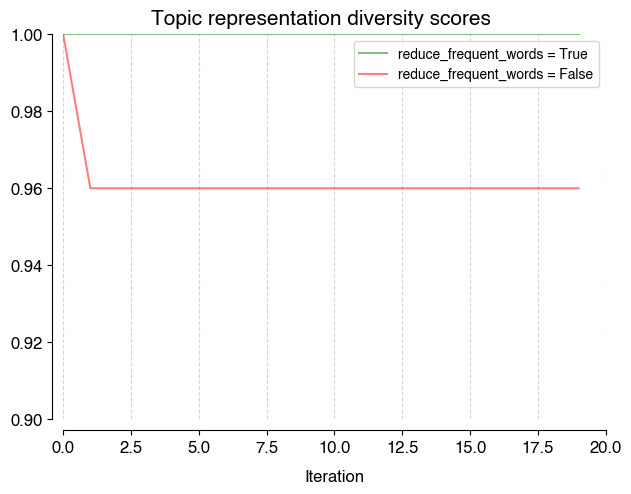

In [867]:
import seaborn as sns
#topicrepresentation diversity
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=10)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.25, 0.9, 'Topic representation diversity scores', fontsize=15, fontweight='black', color = 'black')

ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0.9, 1))
ax.set_xlim(0,20)
ax.set_ylim(0.9,1)
#ax.invert_yaxis()
ax.xaxis.grid(linestyle='--', alpha=0.5)
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
sns.despine()

plt.plot(five[2], color="green", alpha=0.5, linewidth = 1.5)
plt.plot(ten[2], color="red", alpha=0.5, linewidth = 1.5)

plt.legend(['reduce_frequent_words = True', 'reduce_frequent_words = False'])

plt.show()

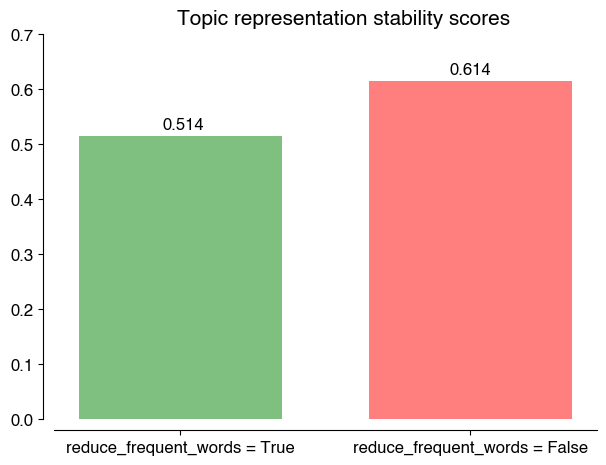

In [862]:
import seaborn as sns
#stability
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(7,5))

#ax.set_xlabel('Iteration', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.9, 'Topic representation stability scores', fontsize=15, fontweight='black', color = 'black')

fig.text(0.28, 0.69, five[3], fontsize=12, fontweight='black', color = 'black')
fig.text(0.69, 0.8, ten[3], fontsize=12, fontweight='black', color = 'black')

stab = [five[3], ten[3]]

stab_names = ['reduce_frequent_words = True', 'reduce_frequent_words = False']
c = ['green', 'red']

plt.bar(stab_names, stab, color=c, width = 0.7, alpha=0.5)
ax.set_ylim(0,0.7)
ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0, 0.7))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
#plt.xticks(rotation=30)
sns.despine()

plt.show()

# Global

In [5]:
import seaborn as sns
from tqdm.auto import tqdm

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.dimensionality import BaseDimensionalityReduction
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from bertopic.vectorizers import ClassTfidfTransformer

In [6]:
# Step 1 - Extract embeddings
embedding_model = Word2Vec

# Step 2 - Reduce dimensionality
umap_model = BaseDimensionalityReduction()

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN()

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(ngram_range=(1, 1))

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True, bm25_weighting=False)

# All steps together
topic_model = BERTopic(
    verbose=False,
    embedding_model=embedding_model,          # Step 1 - Extract embeddings
    umap_model=umap_model,                    # Step 2 - Reduce dimensionality
    hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
    vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model
)

In [7]:
topics, probs = topic_model.fit_transform(df['tweet'].tolist())

In [8]:
#knowing the topic of each tweet
document_info = topic_model.get_document_info(df['tweet'])
document_info

Document  Topic  \
0      brother spend today dad Ed almost 95 mend week...     -1   
1      heartbroken Chesapeake community even week las...     -1   
2      ever end kind horrific violence saw Club Q mus...     -1   
3      Sickened horrify shoot Club Q Colorado Springs...     -1   
4      One favorite moments Nancy Pelosi happen daugh...     -1   
...                                                  ...    ...   
27777  nation lose remarkable American pass Sheldon A...     -1   
27778  Senate grieve death officer literally put line...     -1   
27779  ultimate blame yesterday events lie unhinge cr...     -1   
27780  United States Senate intimidate back post disc...     -1   
27781  vote respect American people decision defend s...     -1   

                          Name  \
0      -1_spend_trump_tell_gas   
1      -1_spend_trump_tell_gas   
2      -1_spend_trump_tell_gas   
3      -1_spend_trump_tell_gas   
4      -1_spend_trump_tell_gas   
...                        ...   
27777  -1_spend_trump_tell_gas   
27778  -1_spend_trump_tell_gas   
27779  -1_spend_trump_tell_gas   
27780  -1_spend_trump_tell_gas   
27781  -1_spend_trump_tell_gas   

                                          Representation  \
0      [spend, trump, tell, gas, think, joe, call, gr...   
1      [spend, trump, tell, gas, think, joe, call, gr...   
2      [spend, trump, tell, gas, think, joe, call, gr...   
3      [spend, trump, tell, gas, think, joe, call, gr...   
4      [spend, trump, tell, gas, think, joe, call, gr...   
...                                                  ...   
27777  [spend, trump, tell, gas, think, joe, call, gr...   
27778  [spend, trump, tell, gas, think, joe, call, gr...   
27779  [spend, trump, tell, gas, think, joe, call, gr...   
27780  [spend, trump, tell, gas, think, joe, call, gr...   
27781  [spend, trump, tell, gas, think, joe, call, gr...   

                                     Representative_Docs  \
0      [Today Senate pass bipartisan bill strengthen ...   
1      [Today Senate pass bipartisan bill strengthen ...   
2      [Today Senate pass bipartisan bill strengthen ...   
3      [Today Senate pass bipartisan bill strengthen ...   
4      [Today Senate pass bipartisan bill strengthen ...   
...                                                  ...   
27777  [Today Senate pass bipartisan bill strengthen ...   
27778  [Today Senate pass bipartisan bill strengthen ...   
27779  [Today Senate pass bipartisan bill strengthen ...   
27780  [Today Senate pass bipartisan bill strengthen ...   
27781  [Today Senate pass bipartisan bill strengthen ...   

                                             Top_n_words  Probability  \
0      spend - trump - tell - gas - think - joe - cal...          0.0   
1      spend - trump - tell - gas - think - joe - cal...          0.0   
2      spend - trump - tell - gas - think - joe - cal...          0.0   
3      spend - trump - tell - gas - think - joe - cal...          0.0   
4      spend - trump - tell - gas - think - joe - cal...          0.0   
...                                                  ...          ...   
27777  spend - trump - tell - gas - think - joe - cal...          0.0   
27778  spend - trump - tell - gas - think - joe - cal...          0.0   
27779  spend - trump - tell - gas - think - joe - cal...          0.0   
27780  spend - trump - tell - gas - think - joe - cal...          0.0   
27781  spend - trump - tell - gas - think - joe - cal...          0.0   

       Representative_document  
0                        False  
1                        False  
2                        False  
3                        False  
4                        False  
...                        ...  
27777                    False  
27778                    False  
27779                    False  
27780                    False  
27781                    False  

[27782 rows x 8 columns]

In [9]:
#getting non-outlier documents
doc_info = document_info[document_info['Topic'] != -1]
doc_info = doc_info.drop_duplicates(subset=['Document'])
doc_info = doc_info.reset_index()

df_t = df.reset_index()
#getting handle and other data into this df
a, b, c, d, e, f, g, h, i, j, k, n, z = ([] for i in range(13))
for l in tqdm(range(len(doc_info))):
    for m in range(len(df_t)):
        if (doc_info['index'][l] == m):
            a.append(df_t['handle'][m])
            b.append(df_t['color'][m])
            c.append(df_t['account_type'][m])
            d.append(df_t['handle'][m])
            e.append(df_t['month'][m])
            f.append(df_t['year'][m])
            g.append(df_t['care'][m])
            h.append(df_t['fairness'][m])
            i.append(df_t['loyalty'][m])
            j.append(df_t['authority'][m])
            k.append(df_t['purity'][m])
            n.append(df_t['date'][m])
            z.append(df_t['text'][m])

100%|███████████████████████████████████████| 4068/4068 [04:23<00:00, 15.44it/s]


In [10]:
doc_info['handle'] = a
doc_info['color'] = b
doc_info['account_type'] = c
doc_info['handle'] = d
doc_info['month'] = e
doc_info['year'] = f
doc_info['care'] = g
doc_info['fairness'] = h
doc_info['loyalty'] = i
doc_info['authority'] = j
doc_info['purity'] = k
doc_info['date'] = n
doc_info['tweet'] = z

In [11]:
t = doc_info[['Document', 'Topic', 'Name', 'handle', 'color', 'date', 'tweet']]

In [12]:
t.tweet

0       On Veterans Day, we honor the brave men and wo...
1       Glad @POTUS is embracing a tax on Big Oil's ex...
2       Sickened by the attack on Paul Pelosi at the f...
3       The student debt relief portal is open for app...
4       For too long, our history books ignored those ...
                              ...                        
4063    This Memorial Day we remember the brave men an...
4064    Tune in now to @FoxBusiness. I'm joining @larr...
4065    Tune in now: I'm joining @BretBaier on @FoxNew...
4066    Israel must know that their friends and allies...
4067    I am continuing to monitor severe flooding acr...
Name: tweet, Length: 4068, dtype: object

In [13]:
members = ['Adam Schiff',
'Alexandria Ocasio-Cortez',
'Andy Biggs',
'Bernie Sanders',
'Charles Schumer',
'Cory Booker',
'Elizabeth Warren',
'Jim Jordan',
'Joaquin Castro',
'Joe Biden',
'John Cornyn',
'John Kennedy',
'Kamala Harris',
'Kevin McCarthy',
'Lee Zeldin',
'Marco Rubio',
'Marjorie Taylor Greene',
'Marsha Blackburn',
'Matt Gaetz',
'Mitt Romney',
'Nancy Pelosi',
'Patty Murray',
'Pramila Jayapal',
'Rand Paul',
'Rick Scott',
'Steny Hoyer',
'Ted Cruz']

members_dict = { 
'RepAdamSchiff':'Adam Schiff',
'AdamSchiff':'Adam Schiff',
'AOC' :'Alexandria Ocasio-Cortez',
'RepAOC' :'Alexandria Ocasio-Cortez', 
'RepAndyBiggsAZ' :'Andy Biggs ',
'BernieSanders' :'Bernie Sanders',
'SenSanders':'Bernie Sanders',
'SenSchumer' :'Charles Schumer',
'chuckschumer':'Charles Schumer', 
'SenBooker' :'Cory Booker',
'CoryBooker':'Cory Booker', 
'ewarren':'Elizabeth Warren',
'SenWarren':'Elizabeth Warren', 
'Jim_Jordan' :'Jim Jordan', 
'JoaquinCastrotx' :'Joaquin Castro', 
'JoeBiden' :'Joe Biden',
'POTUS' :'Joe Biden', 
'JohnCornyn':'John Cornyn', 
'SenJohnKennedy':'John Kennedy', 
'KamalaHarris' :'Kamala Harris',
'VP' :'Kamala Harris', 
'GOPLeader' :'Kevin McCarthy', 
'RepLeeZeldin' :'Lee Zeldin', 
'SenRubioPress' :'Marco Rubio',
'marcorubio':'Marco Rubio', 
'RepMTG' :'Marjorie Taylor Greene', 
'MarshaBlackburn':'Marsha Blackburn', 
'RepMattGaetz' :'Matt Gaetz', 
'SenatorRomney' :'Mitt Romney',
'MittRomney':'Mitt Romney', 
'TeamPelosi':'Nancy Pelosi',
'SpeakerPelosi' :'Nancy Pelosi', 
'PattyMurray':'Patty Murray', 
'RepJayapal':'Pramila Jayapal',
'PramilaJayapal' :'Pramila Jayapal', 
'RandPaul':'Rand Paul', 
'SenRickScott':' Rick Scott', 
'LeaderHoyer' :'Steny Hoyer',
'StenyHoyer' :'Steny Hoyer', 
'SenTedCruz':'Ted Cruz',
'JohnFetterman': 'John Fetterman',
'LeaderMcConnell': 'Mitch McConnell'
}

In [14]:
topic_names = {
    0: 'Abortion',
    1: 'Student Debt',
    2: 'Judge Brown Jackson',
    3: 'Voting',
    4: 'Russo-Ukrainian War',
    5: 'Cannabis',
    6: 'CommitmentToAmerica',
    7: 'DefendOurDemocracy',
    8: 'Firebrand',
    9: 'MemorialDay',
    10:'COVID-19 Vaccine',
    11:'Utah',
    12:'Congratulations'
    
}

In [15]:
t = t[t['Topic'] < 13]

In [16]:
aux = []
aux2 = []
for i in range(len(t)):
    m = t.handle.iloc[i]
    n = t.Topic.iloc[i]
    aux2.append(members_dict[m])
    aux.append(topic_names[n])
t['topic_name'] = aux
t['member'] = aux2

In [17]:
t = t.drop('Name', axis=1)

In [18]:
parties = {
    'blue': 'Democrat', 
    'red': 'Republican',
    'white': 'Independent'
}

aux = []
for i in range(len(t)):
    n = t.color.iloc[i]
    aux.append(parties[n])
t['party'] = aux

In [54]:
t.to_csv('topic_data.csv')

In [19]:
#general info about topics obtained
len(df)-len(doc_info)

23714

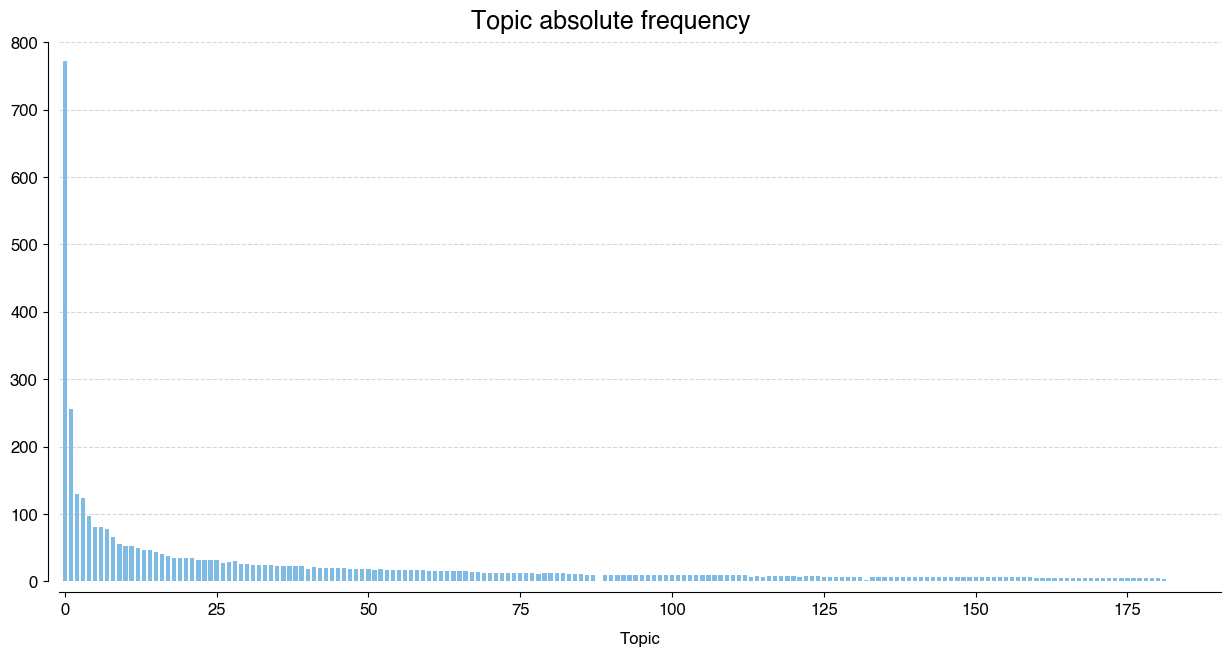

In [22]:
#ax = doc_info['Topic'].value_counts().plot(kind='bar',figsize=(14,8),title="Number for each Owner Name")
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

fig, ax = plt.subplots(figsize=(15,7))

ax.set_xlabel('Topic', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.4, 0.9, 'Topic absolute frequency', fontsize=18, fontweight='black', color = 'black')

#fig.text(0.28, 0.69, five[3], fontsize=12, fontweight='black', color = 'black')
#fig.text(0.69, 0.8, ten[3], fontsize=12, fontweight='black', color = 'black')

stab = doc_info.groupby(['Topic']).count()
stab = stab['index']

stab_names = list(set(doc_info['Topic']))

plt.bar(stab_names, stab, color="#007ACC", width = 0.7, alpha=0.5)

ax.set_ylim(0,800)
ax.spines[['top', 'right']].set_visible('False')
ax.spines['left'].set_bounds((0, 800))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
#plt.xticks(rotation=30)
plt.xlim(left=-1)
sns.despine()
ax.yaxis.grid(linestyle='--', alpha=0.5)
plt.show()

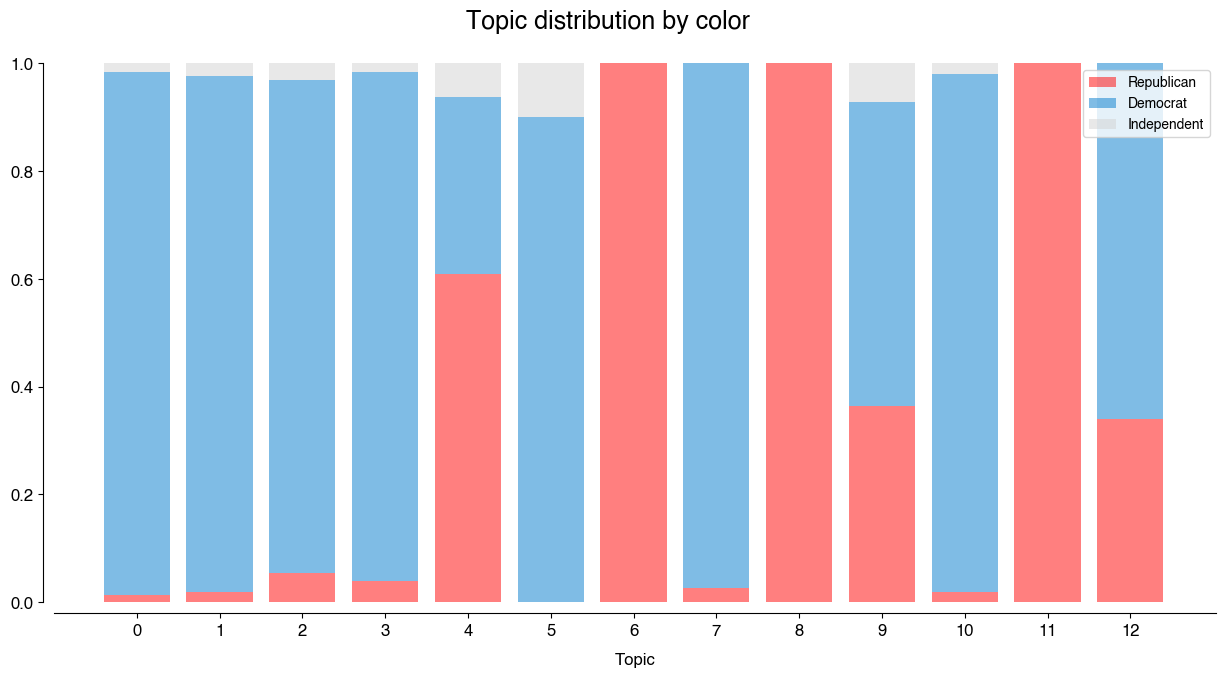

In [24]:
#top 13 by color
doc_info_color = doc_info[doc_info['Topic'] < 13]
cross_tab_prop = pd.crosstab(index=doc_info_color['Topic'],
                             columns=doc_info_color['color'],
                             normalize="index")

#cross_tab_prop.plot(kind='barh', stacked=True, colormap='seismic', figsize=(10, 6))
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(15,7))

ax.set_xlabel('Topic', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.4, 0.93, 'Topic distribution by color', fontsize=18, fontweight='black', color = 'black')

#stab = doc_info.groupby(['Topic']).count()
#stab = stab['index']
stab_names = list(set(doc_info_color['Topic']))

#plt.bar(stab_names, stab, color="blue", width = 0.7, alpha=0.5)
#cross_tab_prop.plot(kind='barh', stacked=True, colormap='seismic', width = 0.7, alpha=0.5)
 
plt.bar(stab_names, cross_tab_prop['red'], color='red', alpha=0.5)
plt.bar(stab_names, cross_tab_prop['blue'], bottom=cross_tab_prop['red'], color="#007ACC", alpha=0.5)
plt.bar(stab_names, cross_tab_prop['white'], bottom=cross_tab_prop['blue']+cross_tab_prop['red'], color='lightgrey',  alpha=0.5)
plt.legend(['Republican', 'Democrat', 'Independent'])
sns.despine()
#ax.spines['left'].set_bounds((0, 10))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
plt.xlim(left=-1)
plt.xticks(stab_names)
plt.show()

#ax.set_ylim(0,800)
#ax.spines['left'].set_bounds((0, 800))
#ax.spines['left'].set_position(('outward', 8))
#ax.spines['bottom'].set_position(('outward', 8))
#plt.xticks(rotation=30)
#ax.yaxis.grid(linestyle='--', alpha=0.5)


In [25]:
doc_info_color[doc_info_color['Topic'] == 5]['Representation'].iloc[0]

['marijuana',
 'cannabis',
 'legalize',
 'possession',
 'prohibition',
 'drugs',
 'marijuanajustice',
 'expunge',
 'convictions',
 'pardon']

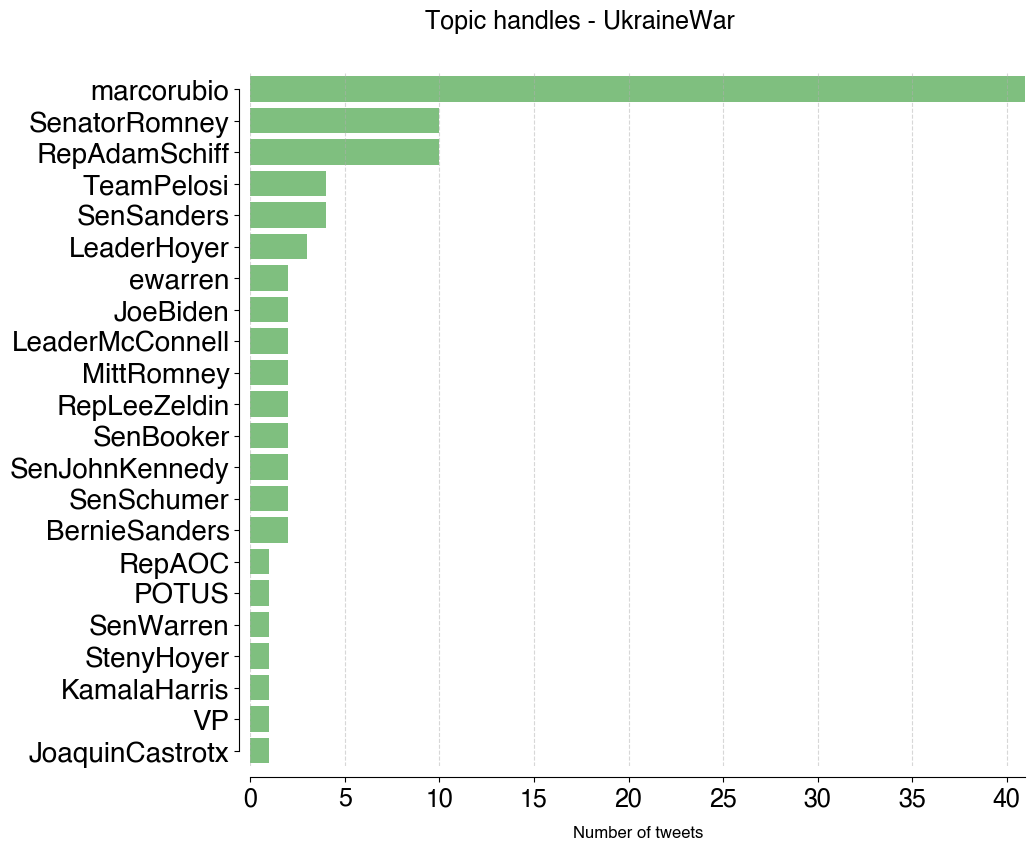

In [164]:
ukraine = doc_info_color[doc_info_color['Topic'] == 4]
counts = ukraine.groupby(['handle']).count()['index']
counts = counts.sort_values()
names = counts.reset_index()['handle']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(10,9))

ax.set_xlabel('Number of tweets', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.93, 'Topic handles - UkraineWar', fontsize=18, fontweight='black', color = 'black')

#stab = doc_info.groupby(['Topic']).count()
#stab = stab['index']
#stab_names = list(set(doc_info_color['Topic']))
 
plt.barh(names, counts, color='green', alpha=0.5)
#plt.legend(['Republican', 'Democrat', 'Independent'])
sns.despine()
ax.spines['left'].set_bounds((0, len(names)-1))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
plt.xlim(left=-1)
ax.set_ylim(-0.5,len(names)-0.5)
ax.set_xlim(0, max(counts))
ax.xaxis.grid(linestyle='--', alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
plt.show()

#ax.spines['left'].set_bounds((0, 800))
#ax.spines['left'].set_position(('outward', 8))
#ax.spines['bottom'].set_position(('outward', 8))
#plt.xticks(rotation=30)



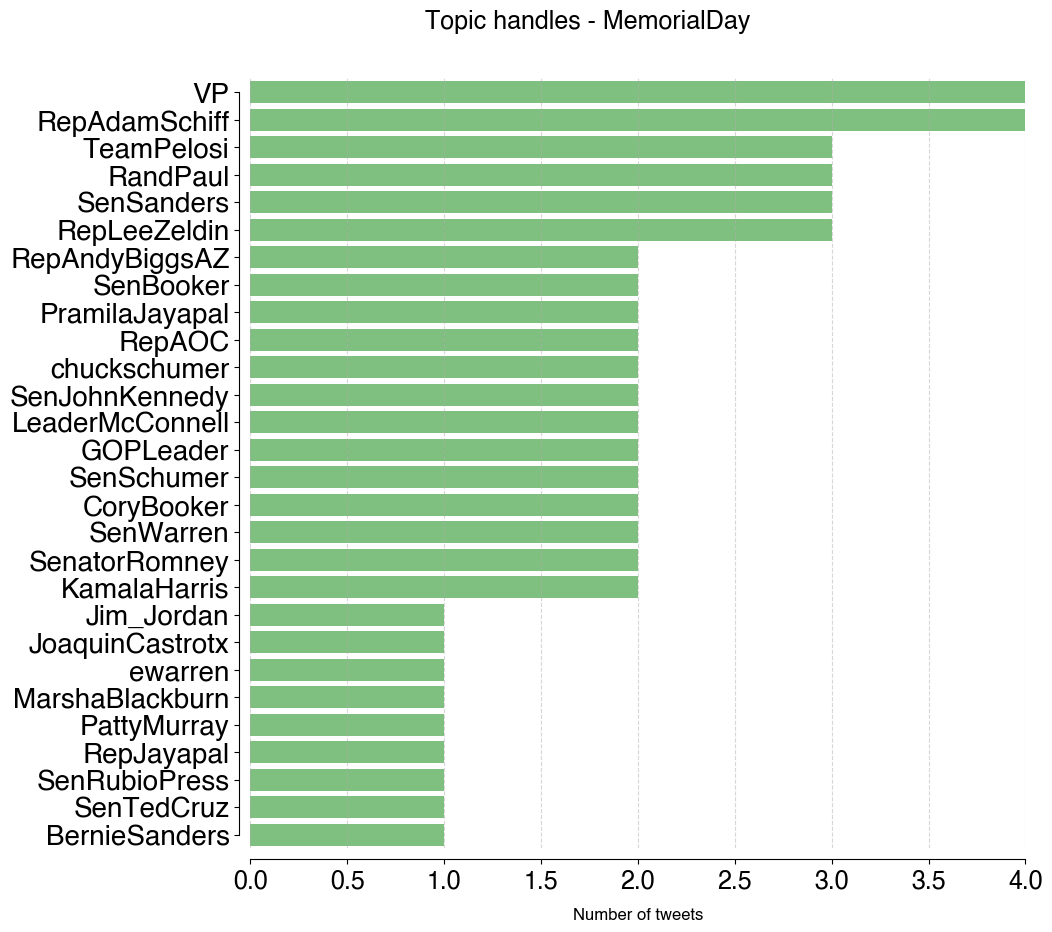

In [165]:
memorial = doc_info_color[doc_info_color['Topic'] == 9]
counts = memorial.groupby(['handle']).count()['index']
counts = counts.sort_values()
names = counts.reset_index()['handle']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlabel('Number of tweets', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.93, 'Topic handles - MemorialDay', fontsize=18, fontweight='black', color = 'black')

#stab = doc_info.groupby(['Topic']).count()
#stab = stab['index']
#stab_names = list(set(doc_info_color['Topic']))
 
plt.barh(names, counts, color='green', alpha=0.5)
#plt.legend(['Republican', 'Democrat', 'Independent'])
sns.despine()
ax.spines['left'].set_bounds((0, len(names)-1))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
plt.xlim(left=-1)
ax.set_ylim(-0.5,len(names)-0.5)
ax.set_xlim(0, max(counts))
ax.xaxis.grid(linestyle='--', alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
plt.show()

#ax.spines['left'].set_bounds((0, 800))
#ax.spines['left'].set_position(('outward', 8))
#ax.spines['bottom'].set_position(('outward', 8))
#plt.xticks(rotation=30)



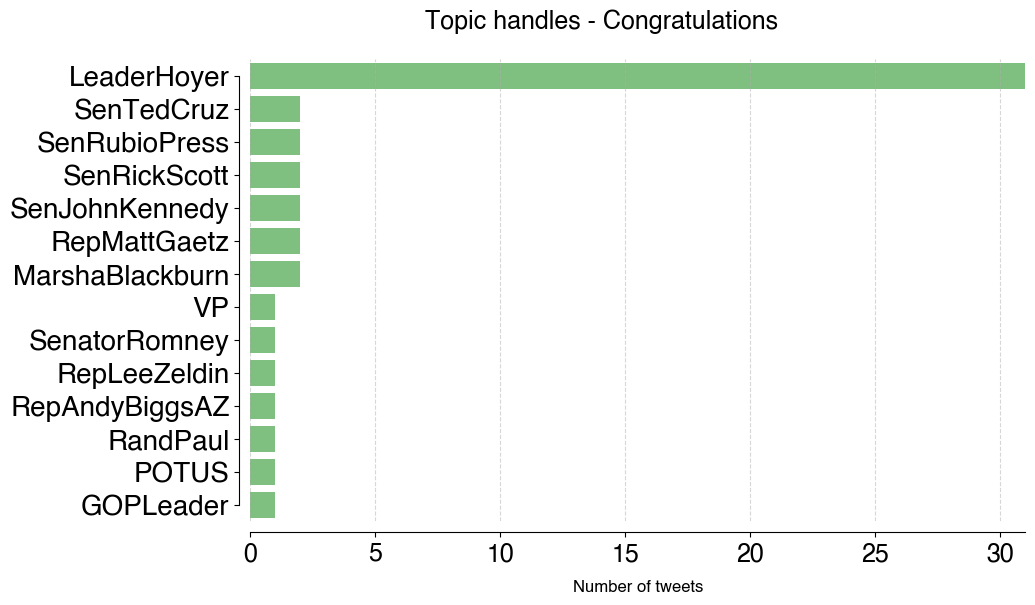

In [161]:
memorial = doc_info_color[doc_info_color['Topic'] == 12]
counts = memorial.groupby(['handle']).count()['index']
counts = counts.sort_values()
names = counts.reset_index()['handle']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(10,6))

ax.set_xlabel('Number of tweets', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.93, 'Topic handles - Congratulations', fontsize=18, fontweight='black', color = 'black')

#stab = doc_info.groupby(['Topic']).count()
#stab = stab['index']
#stab_names = list(set(doc_info_color['Topic']))
 
plt.barh(names, counts, color='green', alpha=0.5)
#plt.legend(['Republican', 'Democrat', 'Independent'])
sns.despine()
ax.spines['left'].set_bounds((0, len(names)-1))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
plt.xlim(left=-1)
ax.set_ylim(-0.5,len(names)-0.5)
ax.set_xlim(0, max(counts))
ax.xaxis.grid(linestyle='--', alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
plt.show()

#ax.spines['left'].set_bounds((0, 800))
#ax.spines['left'].set_position(('outward', 8))
#ax.spines['bottom'].set_position(('outward', 8))
#plt.xticks(rotation=30)

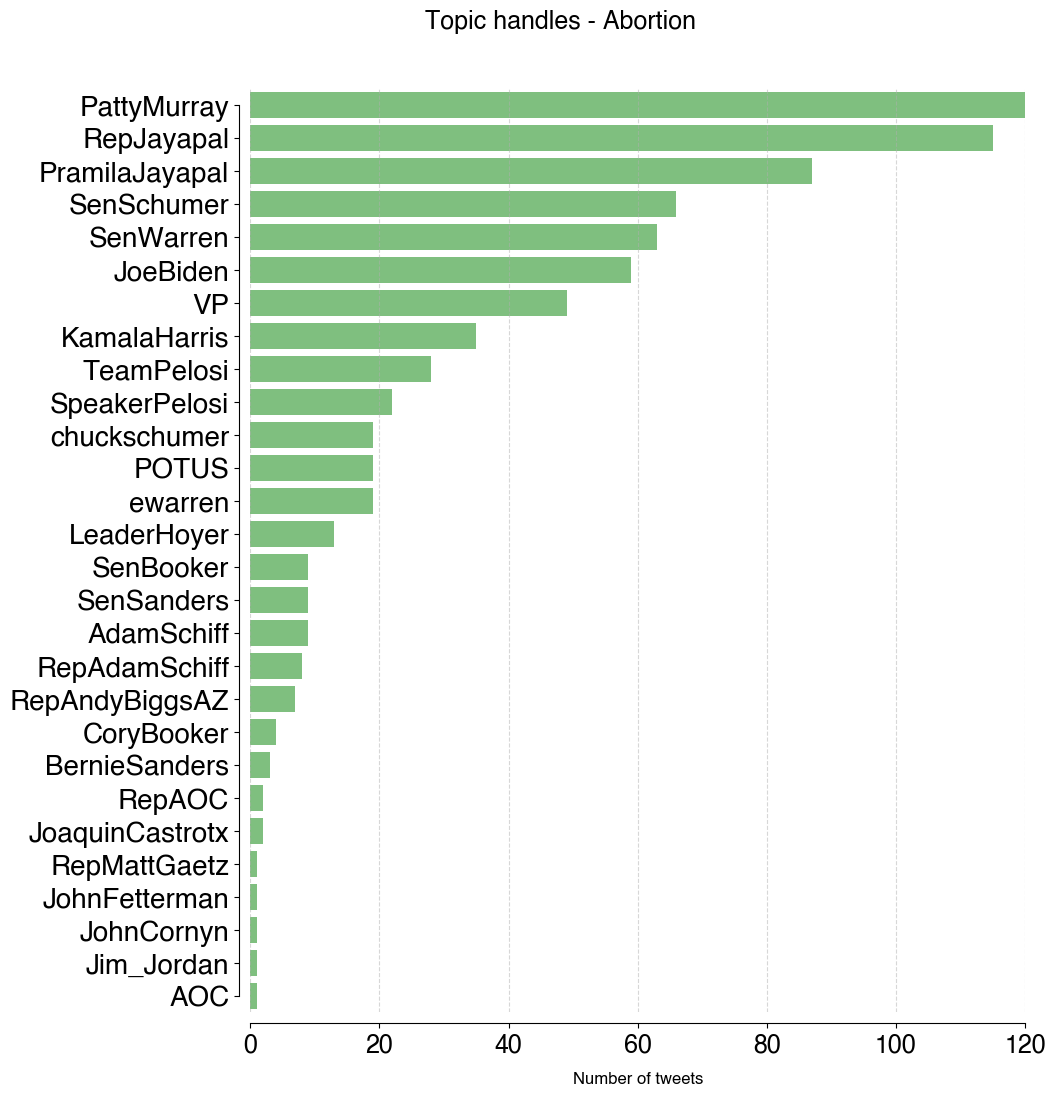

In [179]:
memorial = doc_info_color[doc_info_color['Topic'] == 0]
counts = memorial.groupby(['handle']).count()['index']
counts = counts.sort_values()
names = counts.reset_index()['handle']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(10,12))

ax.set_xlabel('Number of tweets', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.93, 'Topic handles - Abortion', fontsize=18, fontweight='black', color = 'black')

#stab = doc_info.groupby(['Topic']).count()
#stab = stab['index']
#stab_names = list(set(doc_info_color['Topic']))
 
plt.barh(names, counts, color='green', alpha=0.5)
#plt.legend(['Republican', 'Democrat', 'Independent'])
sns.despine()
ax.spines['left'].set_bounds((0, len(names)-1))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
plt.xlim(left=-1)
ax.set_ylim(-0.5,len(names)-0.5)
ax.set_xlim(0, max(counts))
ax.xaxis.grid(linestyle='--', alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
plt.show()

#ax.spines['left'].set_bounds((0, 800))
#ax.spines['left'].set_position(('outward', 8))
#ax.spines['bottom'].set_position(('outward', 8))
#plt.xticks(rotation=30)

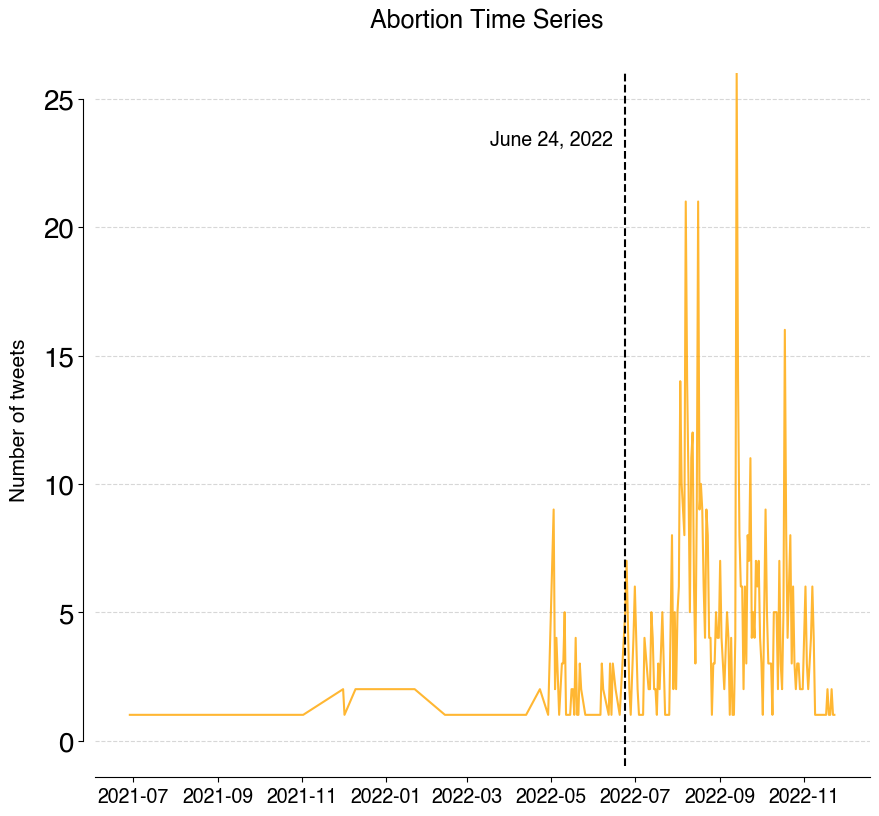

In [172]:
t = memorial.groupby(['date']).count()['index']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(10,9))

ax.set_ylabel("Number of tweets", labelpad=10, fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

fig.text(0.4, 0.93, 'Abortion Time Series', fontsize=18, fontweight='black', color = 'black')
plt.plot(t, color='orange', alpha=0.8);
sns.despine()
ax.spines['left'].set_bounds((0, 25))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
import datetime
d = datetime.date(2022, 6, 24)
plt.axvline(x = d, color = 'black', label = 'axvline - full height', linestyle='--')
fig.text(0.52, 0.8, 'June 24, 2022', fontsize=14, fontweight='black', color = 'black')
#plt.xlim(left=-1)
ax.set_ylim(-1,max(t))
plt.xticks(fontsize=14)
plt.yticks(fontsize=20)
ax.yaxis.grid(linestyle='--', alpha=0.5)


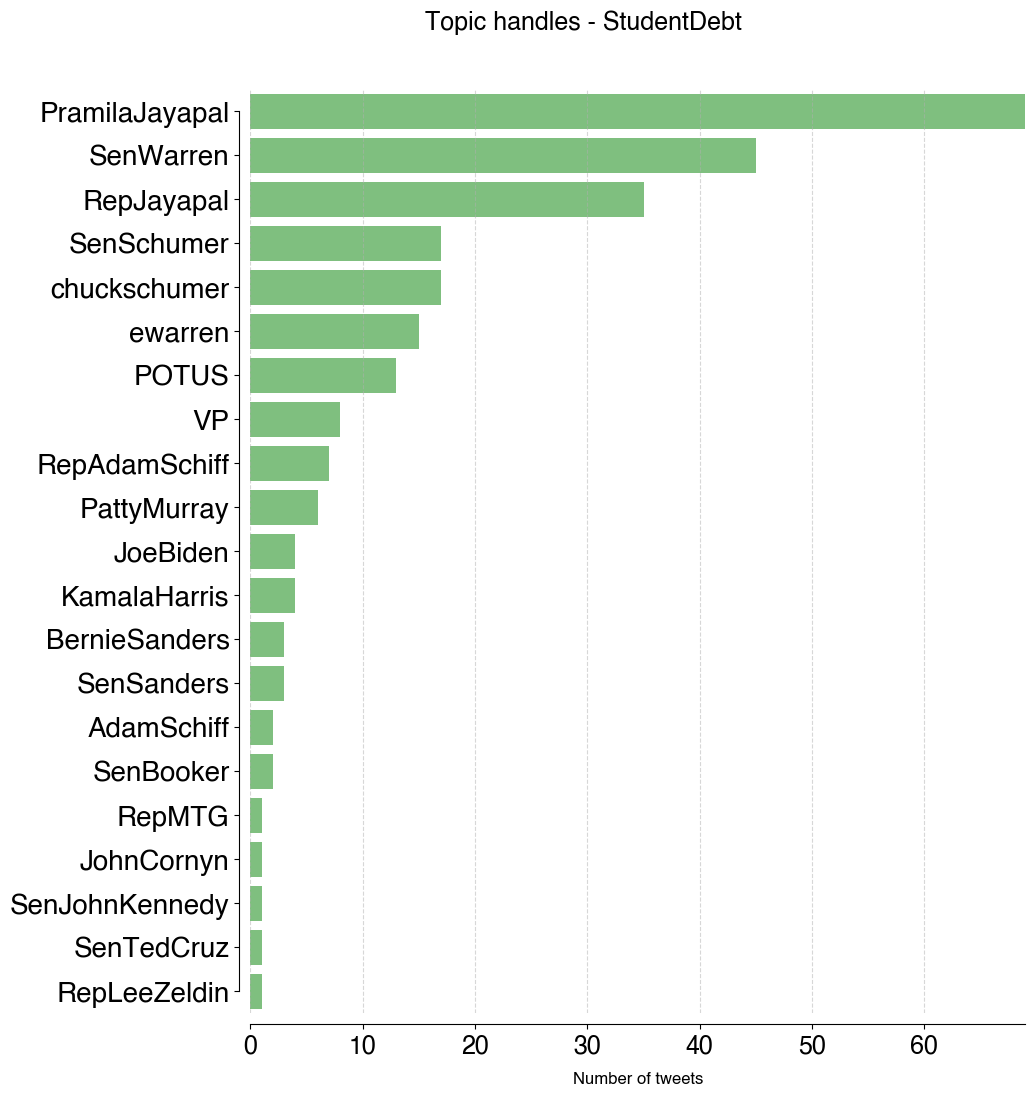

In [181]:
memorial = doc_info_color[doc_info_color['Topic'] == 1]
counts = memorial.groupby(['handle']).count()['index']
counts = counts.sort_values()
names = counts.reset_index()['handle']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(10,12))

ax.set_xlabel('Number of tweets', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.93, 'Topic handles - StudentDebt', fontsize=18, fontweight='black', color = 'black')

#stab = doc_info.groupby(['Topic']).count()
#stab = stab['index']
#stab_names = list(set(doc_info_color['Topic']))
 
plt.barh(names, counts, color='green', alpha=0.5)
#plt.legend(['Republican', 'Democrat', 'Independent'])
sns.despine()
ax.spines['left'].set_bounds((0, len(names)-1))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
plt.xlim(left=-1)
ax.set_ylim(-0.5,len(names)-0.5)
ax.set_xlim(0, max(counts))
plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
ax.xaxis.grid(linestyle='--', alpha=0.5)
plt.show()

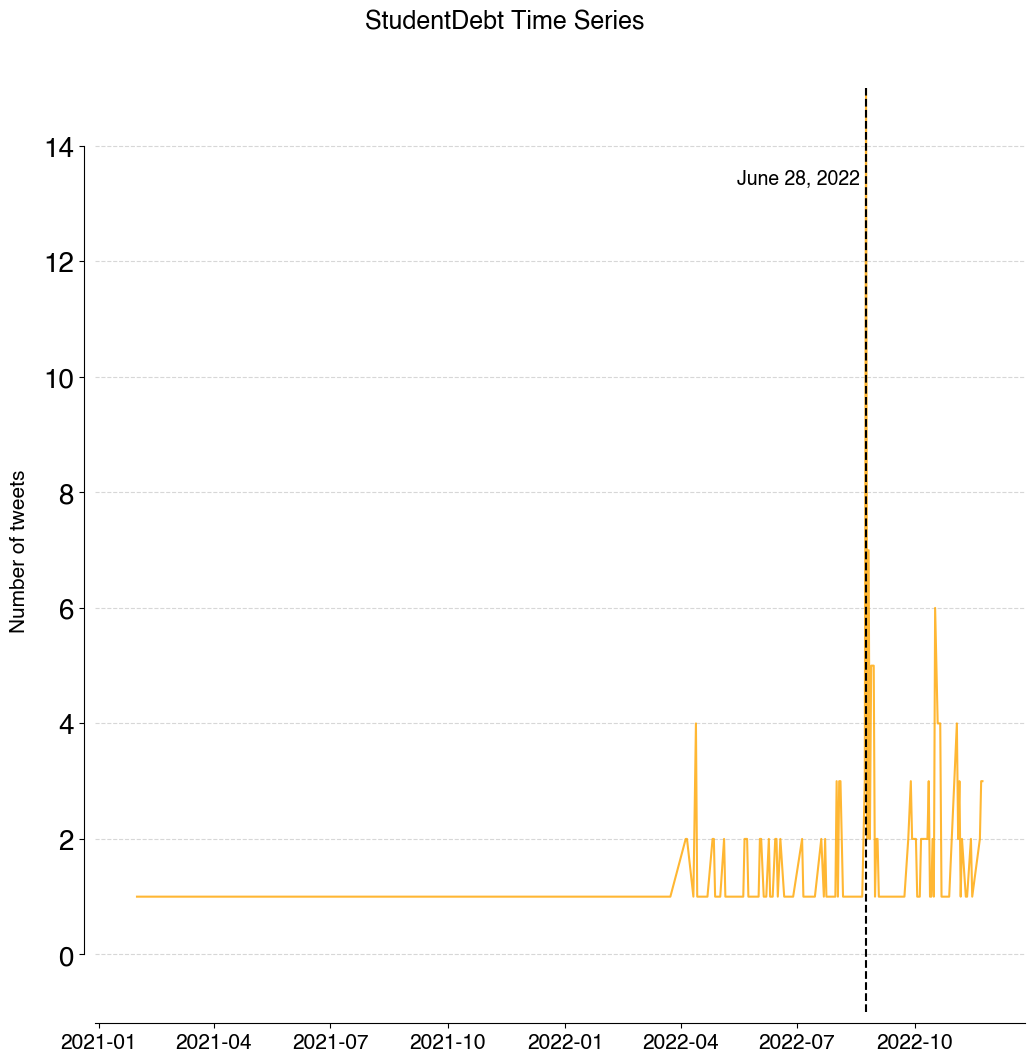

In [178]:
t = memorial.groupby(['date']).count()['index']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(12,12))

ax.set_ylabel("Number of tweets", labelpad=10, fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

fig.text(0.35, 0.93, 'StudentDebt Time Series', fontsize=18, fontweight='black', color = 'black')
plt.plot(t, color='orange', alpha=0.8);
sns.despine()
ax.spines['left'].set_bounds((0, 14))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
import datetime
d = datetime.date(2022, 8, 24)
plt.axvline(x = d, color = 'black', label = 'axvline - full height', linestyle='--')
fig.text(0.66, 0.8, 'June 28, 2022', fontsize=14, fontweight='black', color = 'black')
#plt.xlim(left=-1)
ax.set_ylim(-1,max(t))
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
ax.yaxis.grid(linestyle='--', alpha=0.5)

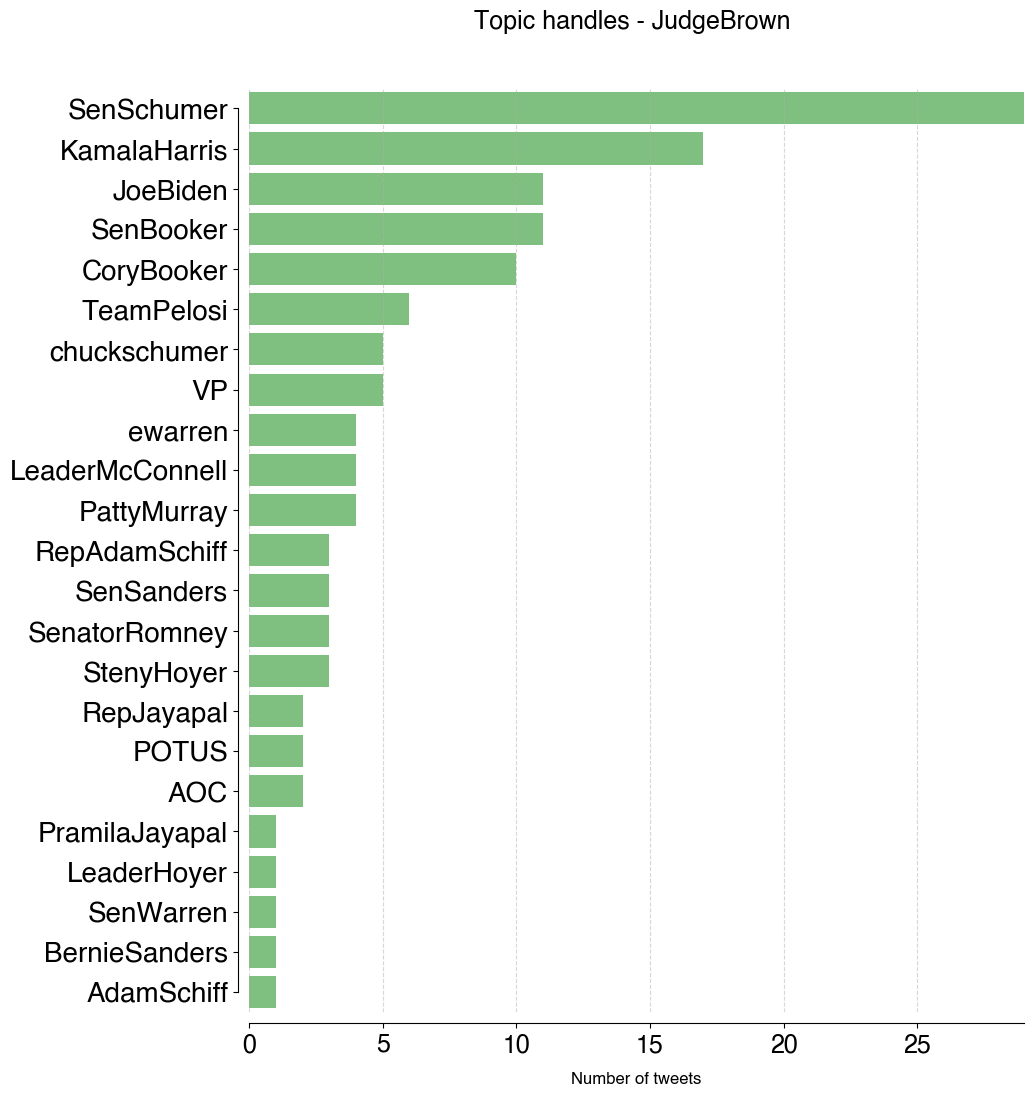

In [144]:
memorial = doc_info_color[doc_info_color['Topic'] == 2]
counts = memorial.groupby(['handle']).count()['index']
counts = counts.sort_values()
names = counts.reset_index()['handle']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(10,12))

ax.set_xlabel('Number of tweets', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.35, 0.93, 'Topic handles - JudgeBrown', fontsize=18, fontweight='black', color = 'black')

#stab = doc_info.groupby(['Topic']).count()
#stab = stab['index']
#stab_names = list(set(doc_info_color['Topic']))
 
plt.barh(names, counts, color='green', alpha=0.5)
#plt.legend(['Republican', 'Democrat', 'Independent'])
sns.despine()
ax.spines['left'].set_bounds((0, len(names)-1))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
plt.xlim(left=-1)
ax.set_ylim(-0.5,len(names)-0.5)
ax.set_xlim(0, max(counts))
ax.xaxis.grid(linestyle='--', alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
plt.show()

#ax.spines['left'].set_bounds((0, 800))
#ax.spines['left'].set_position(('outward', 8))
#ax.spines['bottom'].set_position(('outward', 8))
#plt.xticks(rotation=30)



In [2190]:
(29+17+11+11+10)/sum(counts)

0.6046511627906976

In [2187]:
counts

handle
AdamSchiff          1
BernieSanders       1
SenWarren           1
LeaderHoyer         1
PramilaJayapal      1
AOC                 2
POTUS               2
RepJayapal          2
StenyHoyer          3
SenatorRomney       3
SenSanders          3
RepAdamSchiff       3
PattyMurray         4
LeaderMcConnell     4
ewarren             4
VP                  5
chuckschumer        5
TeamPelosi          6
CoryBooker         10
SenBooker          11
JoeBiden           11
KamalaHarris       17
SenSchumer         29
Name: index, dtype: int64

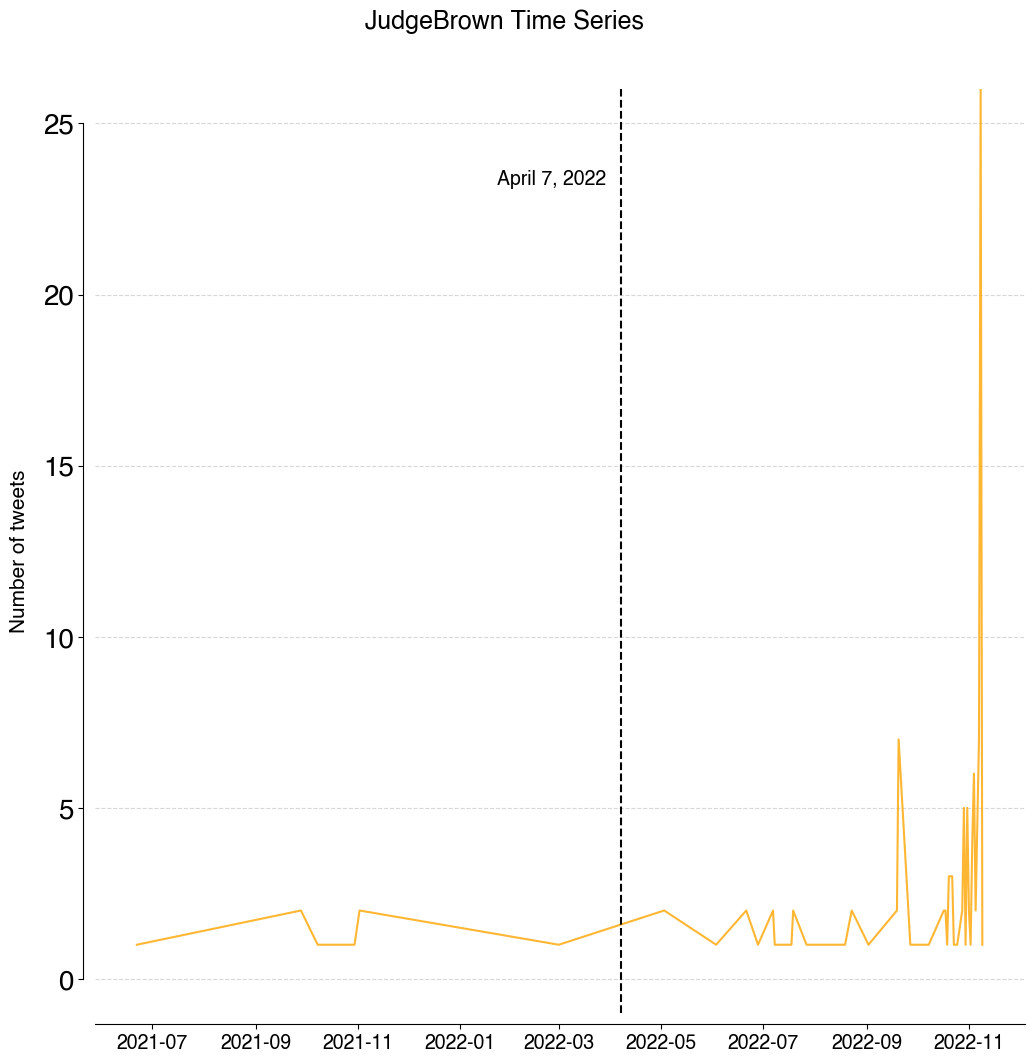

In [207]:
t = memorial.groupby(['date']).count()['index']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(12,12))

ax.set_ylabel("Number of tweets", labelpad=10, fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

fig.text(0.35, 0.93, 'JudgeBrown Time Series', fontsize=18, fontweight='black', color = 'black')
plt.plot(t, color='orange', alpha=0.8);
sns.despine()
ax.spines['left'].set_bounds((0, 25))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
import datetime
d = datetime.date(2022, 4, 7)
plt.axvline(x = d, color = 'black', label = 'axvline - full height', linestyle='--')
fig.text(0.46, 0.8, 'April 7, 2022', fontsize=14, fontweight='black', color = 'black')
#plt.xlim(left=-1)
ax.set_ylim(-1,max(t))
plt.xticks(fontsize=14)
plt.yticks(fontsize=20)
ax.yaxis.grid(linestyle='--', alpha=0.5)

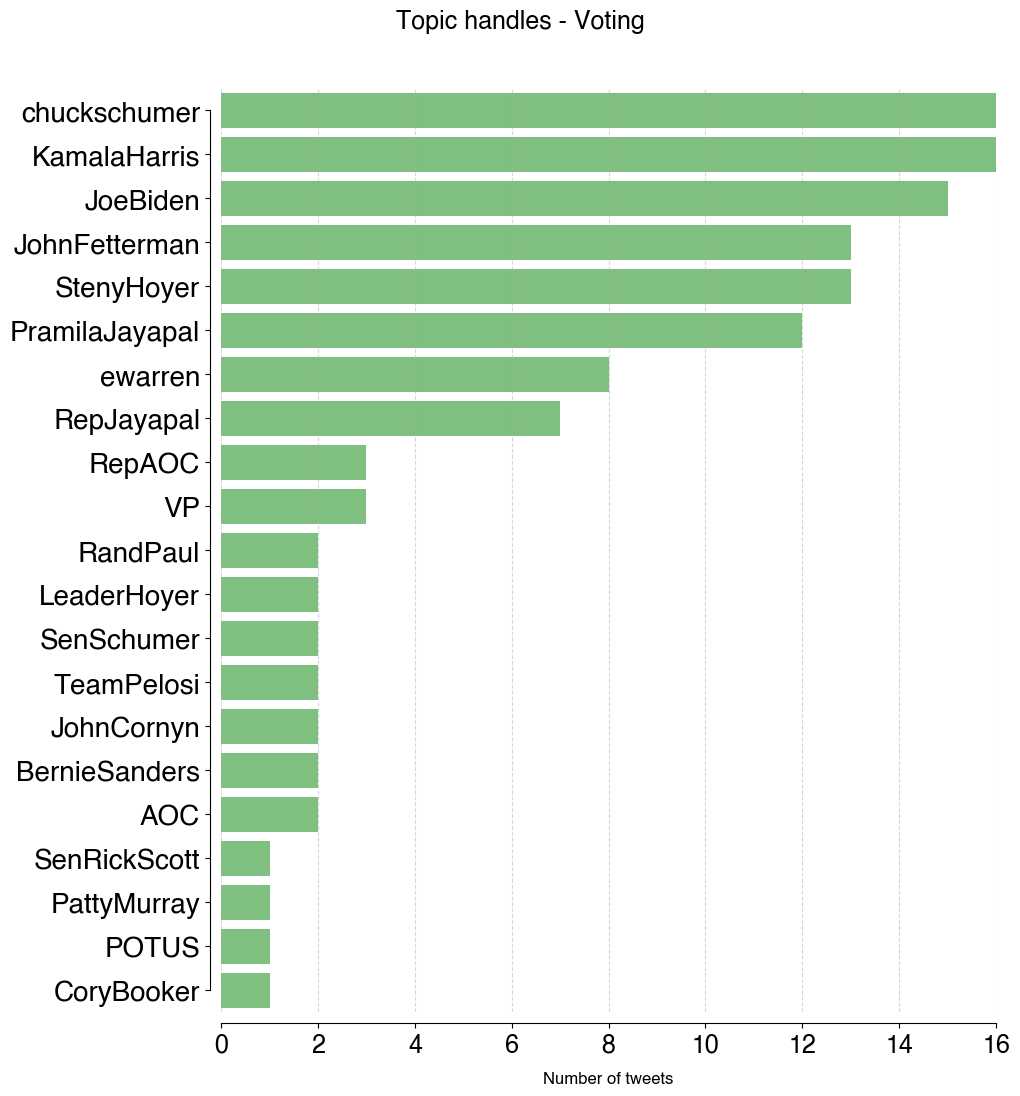

In [198]:
memorial = doc_info_color[doc_info_color['Topic'] == 3]
counts = memorial.groupby(['handle']).count()['index']
counts = counts.sort_values()
names = counts.reset_index()['handle']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(10,12))

ax.set_xlabel('Number of tweets', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.93, 'Topic handles - Voting', fontsize=18, fontweight='black', color = 'black')

#stab = doc_info.groupby(['Topic']).count()
#stab = stab['index']
#stab_names = list(set(doc_info_color['Topic']))
 
plt.barh(names, counts, color='green', alpha=0.5)
#plt.legend(['Republican', 'Democrat', 'Independent'])
sns.despine()
ax.spines['left'].set_bounds((0, len(names)-1))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
plt.xlim(left=-1)
ax.set_ylim(-0.5,len(names)-0.5)
ax.set_xlim(0, max(counts))
ax.xaxis.grid(linestyle='--', alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
plt.show()

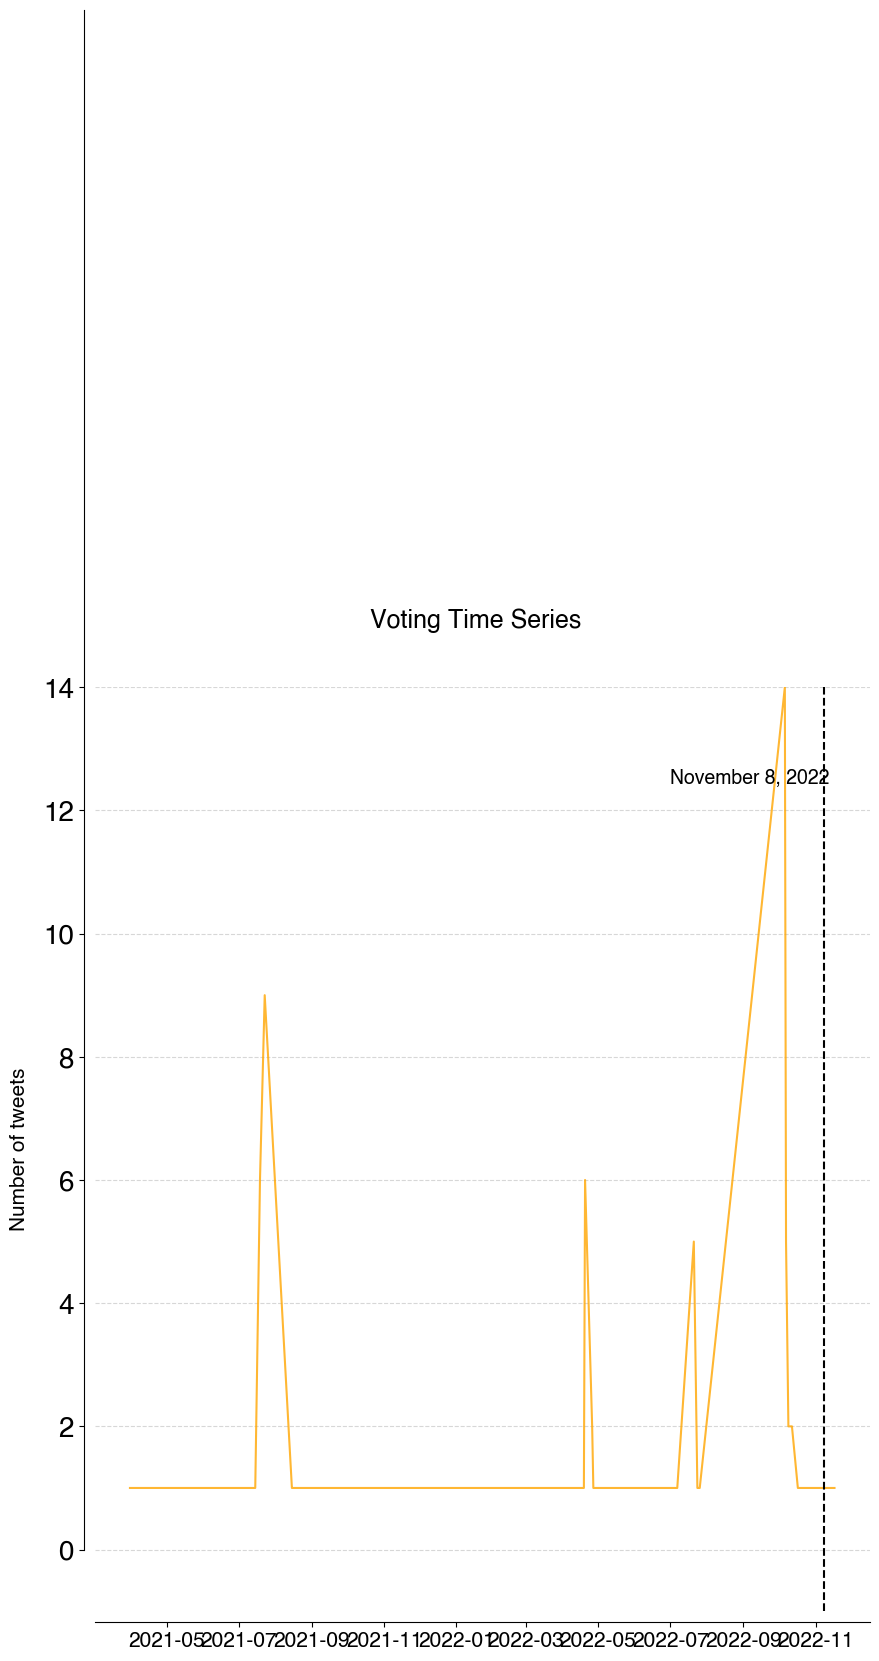

In [216]:
t = memorial.groupby(['date']).count()['index']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(10,12))

ax.set_ylabel("Number of tweets", labelpad=10, fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

fig.text(0.4, 0.93, 'Voting Time Series', fontsize=18, fontweight='black', color = 'black')
plt.plot(t, color='orange', alpha=0.8);
sns.despine()
ax.spines['left'].set_bounds((0, 25))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
import datetime
d = datetime.date(2022, 11, 8)
plt.axvline(x = d, color = 'black', label = 'axvline - full height', linestyle='--')
fig.text(0.7, 0.8, 'November 8, 2022', fontsize=14, fontweight='black', color = 'black')
#plt.xlim(left=-1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
ax.set_ylim(-1,max(t))
ax.yaxis.grid(linestyle='--', alpha=0.5)

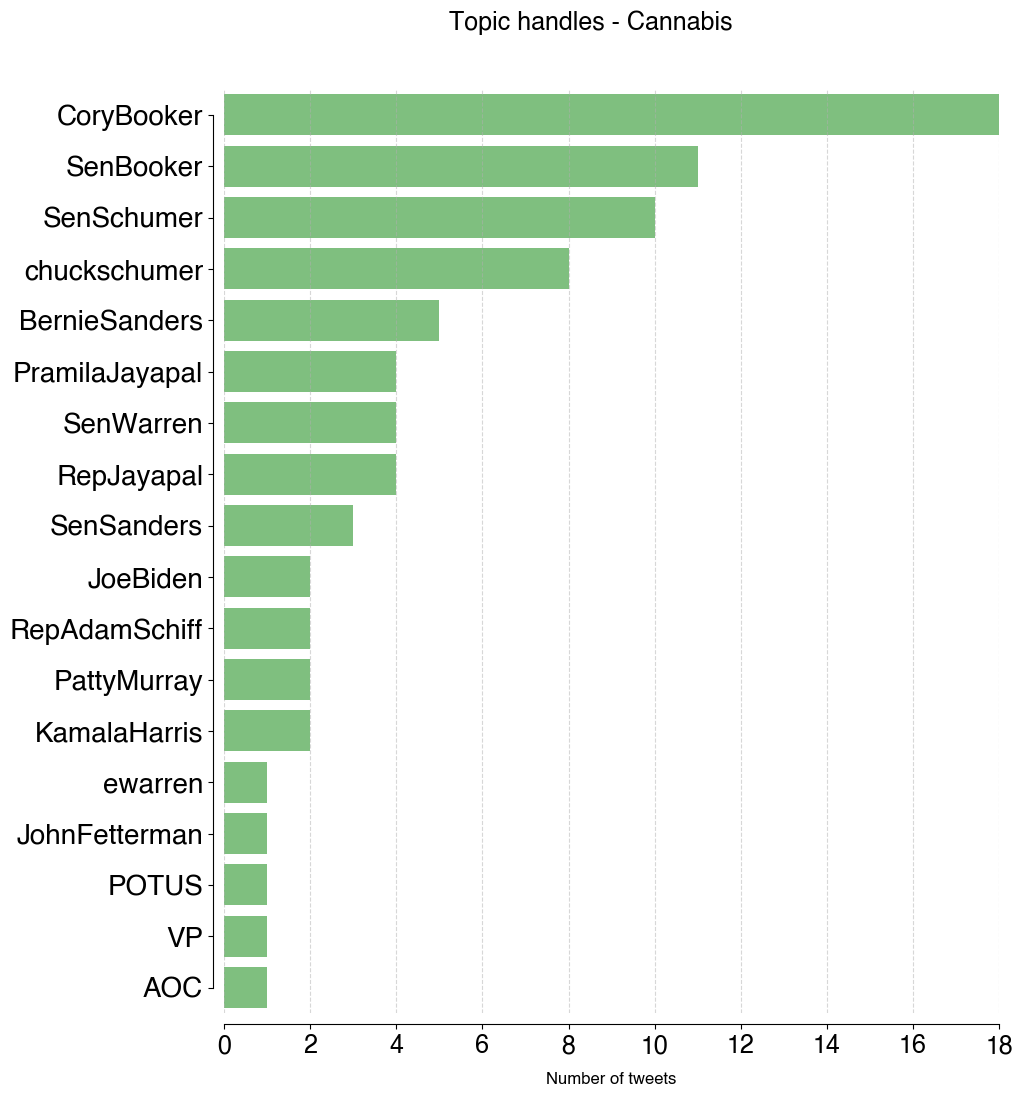

In [208]:
memorial = doc_info_color[doc_info_color['Topic'] == 5]
counts = memorial.groupby(['handle']).count()['index']
counts = counts.sort_values()
names = counts.reset_index()['handle']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(10,12))

ax.set_xlabel('Number of tweets', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.35, 0.93, 'Topic handles - Cannabis', fontsize=18, fontweight='black', color = 'black')

#stab = doc_info.groupby(['Topic']).count()
#stab = stab['index']
#stab_names = list(set(doc_info_color['Topic']))
 
plt.barh(names, counts, color='green', alpha=0.5)
#plt.legend(['Republican', 'Democrat', 'Independent'])
sns.despine()
ax.spines['left'].set_bounds((0, len(names)-1))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
plt.xlim(left=-1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
ax.set_ylim(-0.5,len(names)-0.5)
ax.set_xlim(0, max(counts))
ax.xaxis.grid(linestyle='--', alpha=0.5)
plt.show()

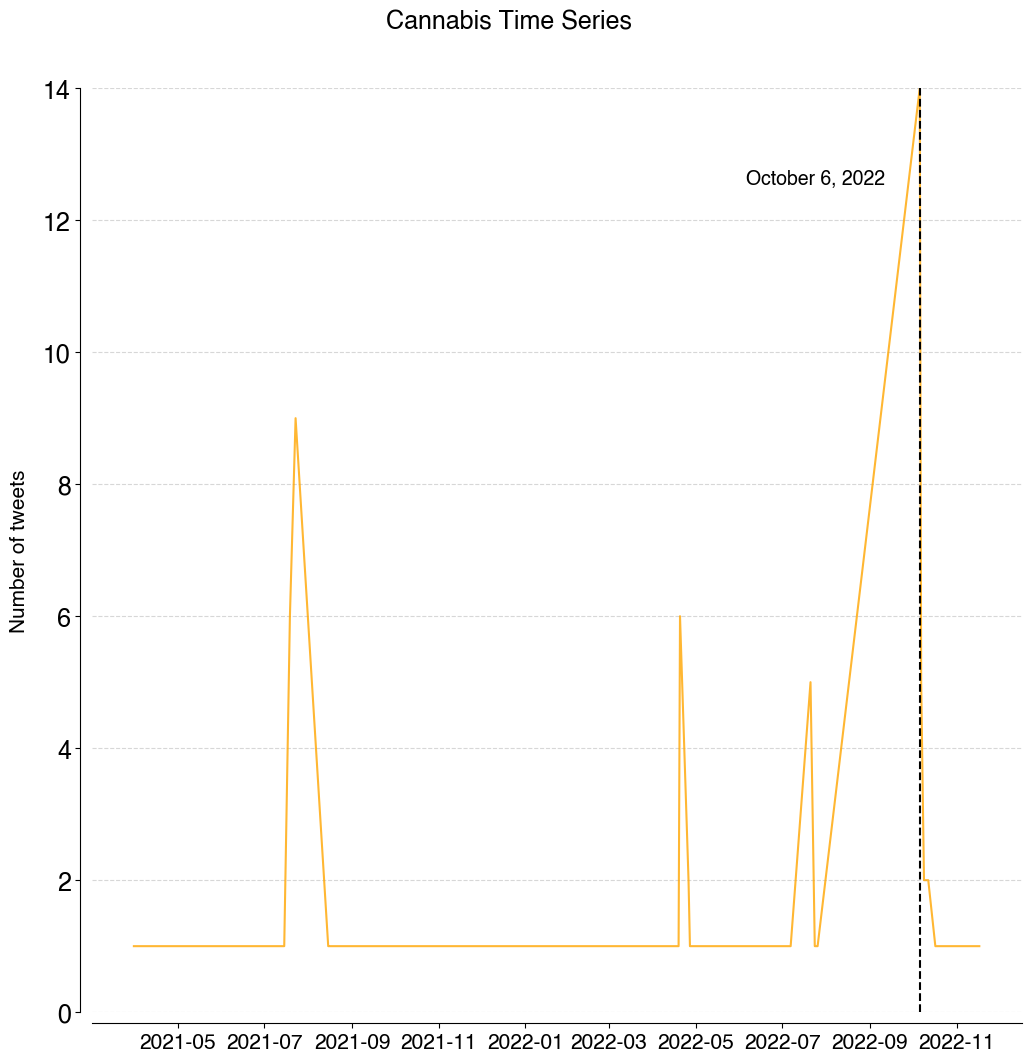

In [214]:
t = memorial.groupby(['date']).count()['index']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(12,12))

ax.set_ylabel("Number of tweets", labelpad=10, fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

fig.text(0.37, 0.93, 'Cannabis Time Series', fontsize=18, fontweight='black', color = 'black')
plt.plot(t, color='orange', alpha=0.8);
sns.despine()
ax.spines['left'].set_bounds((0, 14))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
import datetime
d = datetime.date(2022, 10, 6)
plt.axvline(x = d, color = 'black', label = 'axvline - full height', linestyle='--')
fig.text(0.67, 0.8, 'October 6, 2022', fontsize=14, fontweight='black', color = 'black')
#plt.xlim(left=-1)
ax.set_ylim(0,max(t))
plt.xticks(fontsize=15)
plt.yticks(fontsize=18)
ax.yaxis.grid(linestyle='--', alpha=0.5)

In [2240]:
18/sum(counts)

0.225

In [2236]:
t[t==max(t)]

date
2022-10-06    14
Name: index, dtype: int64

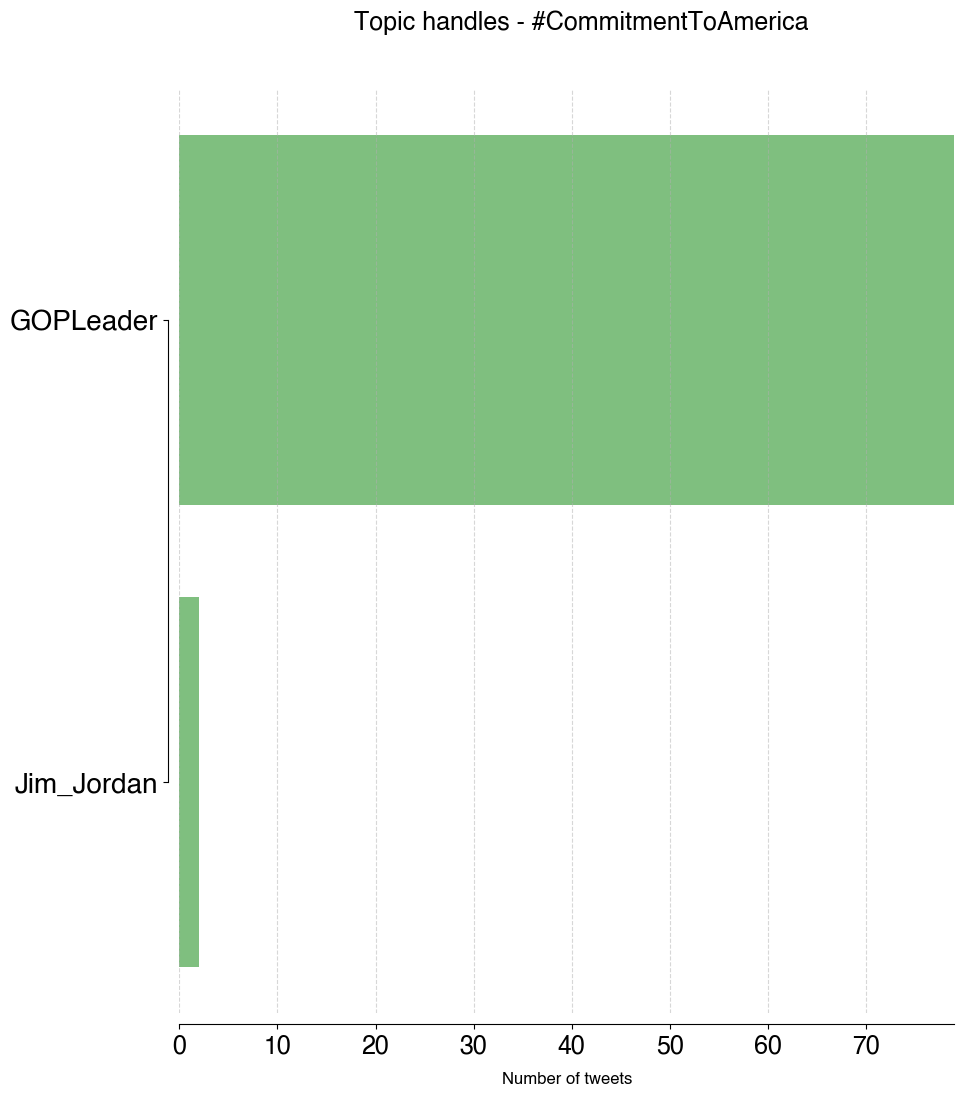

In [218]:
memorial = doc_info_color[doc_info_color['Topic'] == 6]
counts = memorial.groupby(['handle']).count()['index']
counts = counts.sort_values()
names = counts.reset_index()['handle']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(10,12))

ax.set_xlabel('Number of tweets', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.93, 'Topic handles - #CommitmentToAmerica', fontsize=18, fontweight='black', color = 'black')

#stab = doc_info.groupby(['Topic']).count()
#stab = stab['index']
#stab_names = list(set(doc_info_color['Topic']))
 
plt.barh(names, counts, color='green', alpha=0.5)
#plt.legend(['Republican', 'Democrat', 'Independent'])
sns.despine()
ax.spines['left'].set_bounds((0, len(names)-1))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
plt.xlim(left=-1)
ax.set_ylim(-0.5,len(names)-0.5)
ax.set_xlim(0, max(counts))
plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
ax.xaxis.grid(linestyle='--', alpha=0.5)
plt.show()

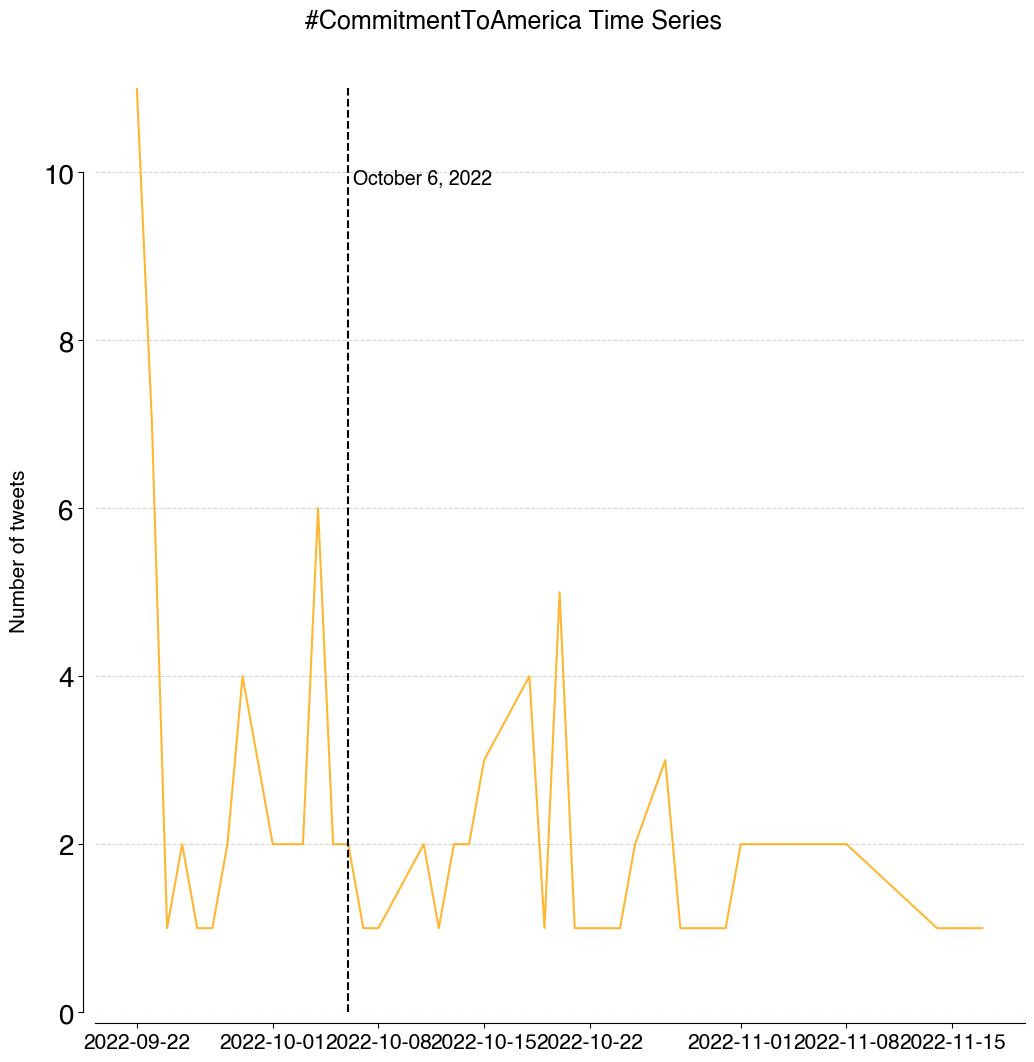

In [221]:
t = memorial.groupby(['date']).count()['index']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(12,12))

ax.set_ylabel("Number of tweets", labelpad=10, fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

fig.text(0.3, 0.93, '#CommitmentToAmerica Time Series', fontsize=18, fontweight='black', color = 'black')
plt.plot(t, color='orange', alpha=0.8);
sns.despine()
ax.spines['left'].set_bounds((0, 10))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
import datetime
d = datetime.date(2022, 10, 6)
plt.axvline(x = d, color = 'black', label = 'axvline - full height', linestyle='--')
fig.text(0.34, 0.8, 'October 6, 2022', fontsize=14, fontweight='black', color = 'black')
#plt.xlim(left=-1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=20)
ax.set_ylim(0,max(t))
ax.yaxis.grid(linestyle='--', alpha=0.5)

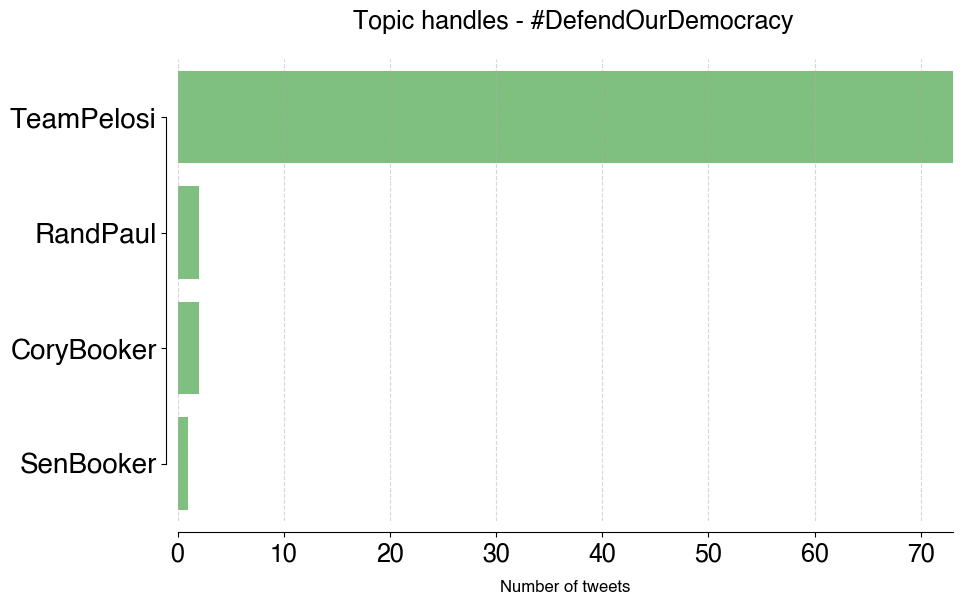

In [223]:
memorial = doc_info_color[doc_info_color['Topic'] == 7]
counts = memorial.groupby(['handle']).count()['index']
counts = counts.sort_values()
names = counts.reset_index()['handle']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(10,6))

ax.set_xlabel('Number of tweets', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.3, 0.93, 'Topic handles - #DefendOurDemocracy', fontsize=18, fontweight='black', color = 'black')

#stab = doc_info.groupby(['Topic']).count()
#stab = stab['index']
#stab_names = list(set(doc_info_color['Topic']))
 
plt.barh(names, counts, color='green', alpha=0.5)
#plt.legend(['Republican', 'Democrat', 'Independent'])
sns.despine()
ax.spines['left'].set_bounds((0, 3))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
plt.xlim(left=-1)
ax.set_ylim(-0.5,len(names)-0.5)
ax.set_xlim(0, max(counts))
ax.xaxis.grid(linestyle='--', alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
plt.show()

In [2245]:
d = doc_info_color[doc_info_color['Topic'] == 7]
d = d[d['handle'] == 'TeamPelosi']
d

index                                           Document  Topic   
2712  20185  Democratic Victory Congratulations Congresswom...      7  \
2715  20194  Democratic Victory Congratulations Congressman...      7   
2716  20195  Democratic Victory Congratulations Congresswom...      7   
2718  20197  Democratic Victory Congratulations Congressman...      7   
2720  20199  Democratic Victory Congratulations Congressman...      7   
...     ...                                                ...    ...   
2822  20559  DefendOurDemocracy Elect Brittany Pettersen De...      7   
2823  20561  DefendOurDemocracy Re-elect Rep. Josh Harder D...      7   
2824  20563  DefendOurDemocracy Re-elect Democratic Rep. Gr...      7   
2825  20564  DefendOurDemocracy Elect Democrat Rudy Salas CA22      7   
2826  20565  DefendOurDemocracy Re-elect Democratic Rep. To...      7   

                                                   Name   
2712  7_defendourdemocracy_victory_congressman_congr...  \
2715  7_defendourdemocracy_victory_congressman_congr...   
2716  7_defendourdemocracy_victory_congressman_congr...   
2718  7_defendourdemocracy_victory_congressman_congr...   
2720  7_defendourdemocracy_victory_congressman_congr...   
...                                                 ...   
2822  7_defendourdemocracy_victory_congressman_congr...   
2823  7_defendourdemocracy_victory_congressman_congr...   
2824  7_defendourdemocracy_victory_congressman_congr...   
2825  7_defendourdemocracy_victory_congressman_congr...   
2826  7_defendourdemocracy_victory_congressman_congr...   

                                         Representation   
2712  [defendourdemocracy, victory, congressman, con...  \
2715  [defendourdemocracy, victory, congressman, con...   
2716  [defendourdemocracy, victory, congressman, con...   
2718  [defendourdemocracy, victory, congressman, con...   
2720  [defendourdemocracy, victory, congressman, con...   
...                                                 ...   
2822  [defendourdemocracy, victory, congressman, con...   
2823  [defendourdemocracy, victory, congressman, con...   
2824  [defendourdemocracy, victory, congressman, con...   
2825  [defendourdemocracy, victory, congressman, con...   
2826  [defendourdemocracy, victory, congressman, con...   

                                    Representative_Docs   
2712  [Democratic Victory Congratulations Congressma...  \
2715  [Democratic Victory Congratulations Congressma...   
2716  [Democratic Victory Congratulations Congressma...   
2718  [Democratic Victory Congratulations Congressma...   
2720  [Democratic Victory Congratulations Congressma...   
...                                                 ...   
2822  [Democratic Victory Congratulations Congressma...   
2823  [Democratic Victory Congratulations Congressma...   
2824  [Democratic Victory Congratulations Congressma...   
2825  [Democratic Victory Congratulations Congressma...   
2826  [Democratic Victory Congratulations Congressma...   

                                            Top_n_words  Probability   
2712  defendourdemocracy - victory - congressman - c...     0.934319  \
2715  defendourdemocracy - victory - congressman - c...     1.000000   
2716  defendourdemocracy - victory - congressman - c...     0.878754   
2718  defendourdemocracy - victory - congressman - c...     0.816152   
2720  defendourdemocracy - victory - congressman - c...     1.000000   
...                                                 ...          ...   
2822  defendourdemocracy - victory - congressman - c...     0.812613   
2823  defendourdemocracy - victory - congressman - c...     0.809195   
2824  defendourdemocracy - victory - congressman - c...     0.836599   
2825  defendourdemocracy - victory - congressman - c...     0.820525   
2826  defendourdemocracy - victory - congressman - c...     0.874169   

      Representative_document      handle color  account_type     month  year   
2712                    False  TeamPelosi  blue  profess

In [2249]:
df.iloc[20565]

date                                          2022-07-01 00:00:00
hour                                                     23:00:00
handle                                                 TeamPelosi
color                                                        blue
account_type                                         professional
text            #DefendOurDemocracy: Re-elect Democratic Rep. ...
tweet           DefendOurDemocracy Re-elect Democratic Rep. To...
mentions                                                       []
tokens          [#, DefendOurDemocracy, :, Re-elect, Democrati...
stopwords       [DefendOurDemocracy, Re-elect, Democratic, Rep...
hashtags                           [#DefendOurDemocracy:, #AZ02.]
week                                                           26
weekday                                                         5
month                                                        July
year                                                         2022
care      

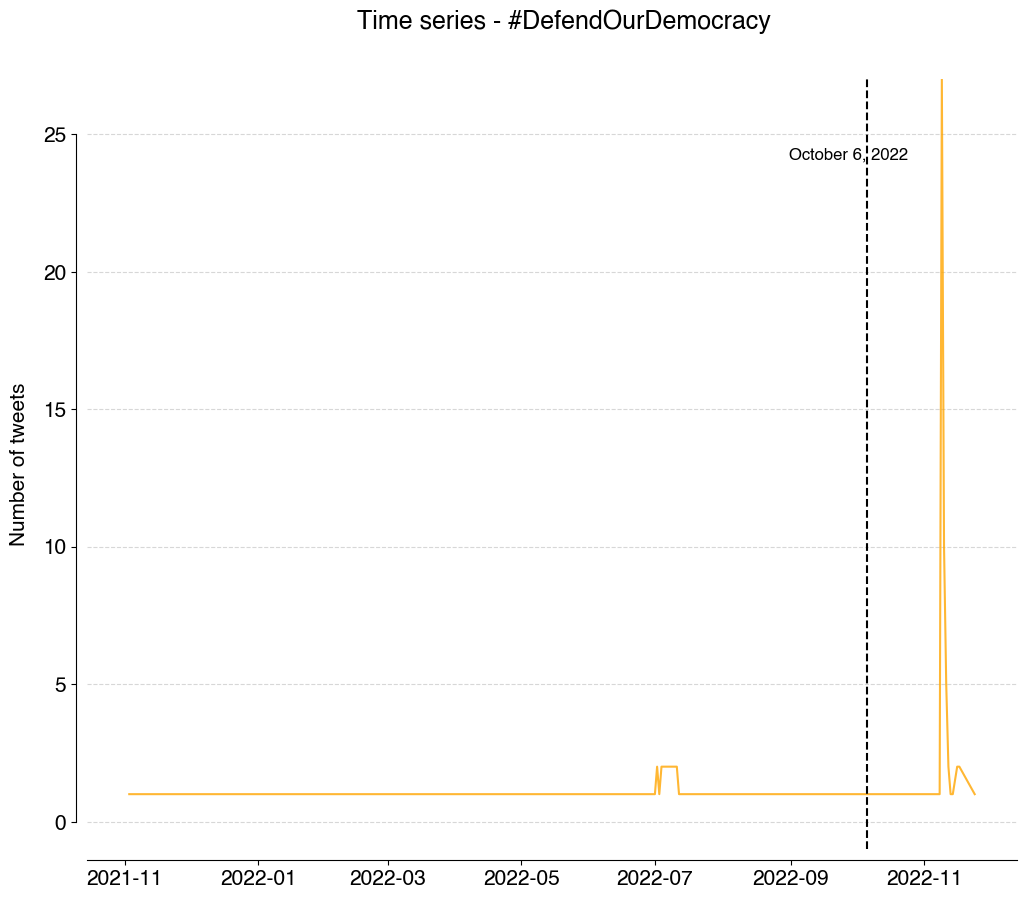

In [2217]:
t = memorial.groupby(['date']).count()['index']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(12,10))

ax.set_ylabel("Number of tweets", labelpad=10, fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

fig.text(0.35, 0.93, 'Time series - #DefendOurDemocracy', fontsize=18, fontweight='black', color = 'black')
plt.plot(t, color='orange', alpha=0.8);
sns.despine()
ax.spines['left'].set_bounds((0, 25))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
import datetime
d = datetime.date(2022, 10, 6)
plt.axvline(x = d, color = 'black', label = 'axvline - full height', linestyle='--')
fig.text(0.71, 0.8, 'October 6, 2022', fontsize=12, fontweight='black', color = 'black')
#plt.xlim(left=-1)
ax.set_ylim(-1,max(t))
ax.yaxis.grid(linestyle='--', alpha=0.5)

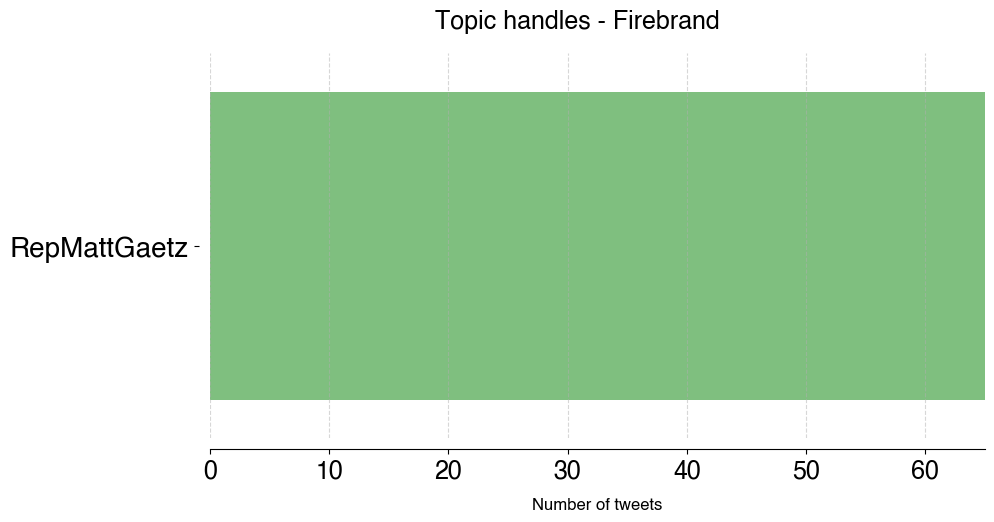

In [224]:
memorial = doc_info_color[doc_info_color['Topic'] == 8]
counts = memorial.groupby(['handle']).count()['index']
counts = counts.sort_values()
names = counts.reset_index()['handle']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(10,5))

ax.set_xlabel('Number of tweets', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.35, 0.93, 'Topic handles - Firebrand', fontsize=18, fontweight='black', color = 'black')

#stab = doc_info.groupby(['Topic']).count()
#stab = stab['index']
#stab_names = list(set(doc_info_color['Topic']))
 
plt.barh(names, counts, color='green', alpha=0.5)
#plt.legend(['Republican', 'Democrat', 'Independent'])
sns.despine()
ax.spines['left'].set_bounds((0, len(names)-1))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
plt.xlim(left=-1)
ax.set_ylim(-0.5,len(names)-0.5)
ax.set_xlim(0, max(counts))
ax.xaxis.grid(linestyle='--', alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
plt.show()

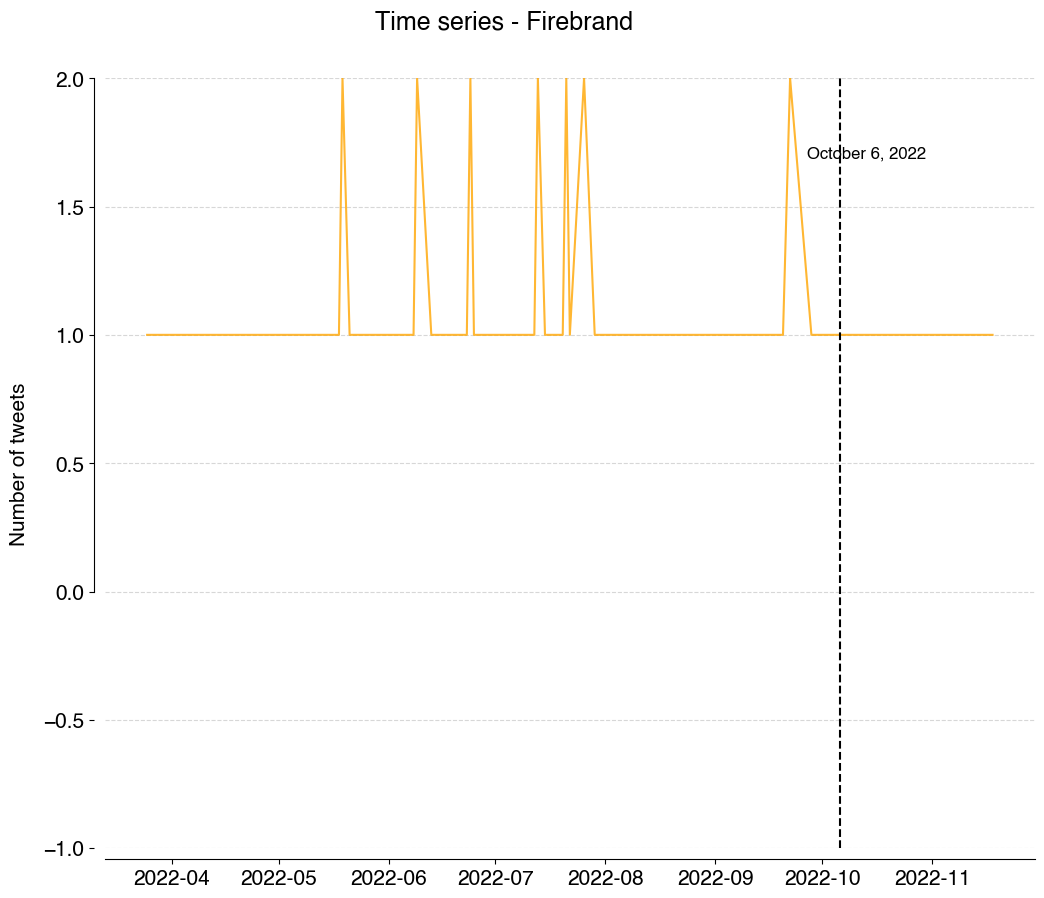

In [2221]:
t = memorial.groupby(['date']).count()['index']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(12,10))

ax.set_ylabel("Number of tweets", labelpad=10, fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

fig.text(0.35, 0.93, 'Time series - Firebrand', fontsize=18, fontweight='black', color = 'black')
plt.plot(t, color='orange', alpha=0.8);
sns.despine()
ax.spines['left'].set_bounds((0, 2))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
import datetime
d = datetime.date(2022, 10, 6)
plt.axvline(x = d, color = 'black', label = 'axvline - full height', linestyle='--')
fig.text(0.71, 0.8, 'October 6, 2022', fontsize=12, fontweight='black', color = 'black')
#plt.xlim(left=-1)
ax.set_ylim(-1,max(t))
ax.yaxis.grid(linestyle='--', alpha=0.5)

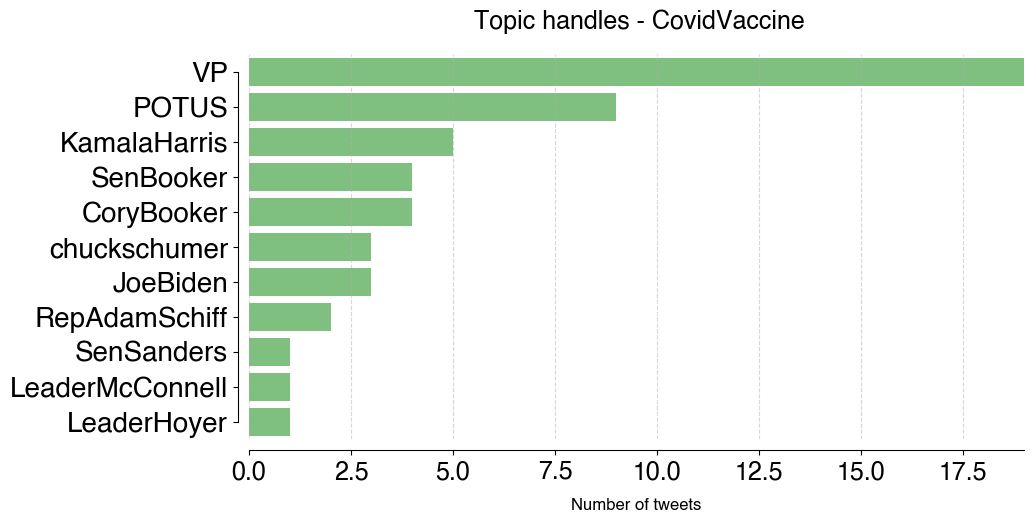

In [227]:
memorial = doc_info_color[doc_info_color['Topic'] == 10]
counts = memorial.groupby(['handle']).count()['index']
counts = counts.sort_values()
names = counts.reset_index()['handle']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(10,5))

ax.set_xlabel('Number of tweets', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.35, 0.93, 'Topic handles - CovidVaccine', fontsize=18, fontweight='black', color = 'black')

#stab = doc_info.groupby(['Topic']).count()
#stab = stab['index']
#stab_names = list(set(doc_info_color['Topic']))
 
plt.barh(names, counts, color='green', alpha=0.5)
#plt.legend(['Republican', 'Democrat', 'Independent'])
sns.despine()
ax.spines['left'].set_bounds((0, len(names)-1))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
plt.xlim(left=-1)
ax.set_ylim(-0.5,len(names)-0.5)
ax.set_xlim(0, max(counts))
ax.xaxis.grid(linestyle='--', alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
ax.xaxis.grid(linestyle='--', alpha=0.5)
plt.show()

In [2252]:
19/sum(counts)

0.36538461538461536

In [2253]:
d = doc_info_color[doc_info_color['Topic'] == 10]
d = d[d['handle'] == 'VP']
d

index                                           Document  Topic   
1886  13896  Prepare healthy holiday season get update COVI...     10  \
1889  13905  Seniors important get update COVID vaccine hol...     10   
1890  13908  important get update COVID vaccine holiday Vis...     10   
1895  13918  essential stay date COVID-19 vaccinations—by g...     10   
1906  13959  Children age 5 older get update COVID-19 vacci...     10   
1908  13964  time get update COVID-19 vaccine safe holiday ...     10   
1909  13966  Everyone get update COVID vaccine fall Make pl...     10   
1913  13973  weekend make plan get update COVID vaccine fre...     10   
1914  13975  holiday season fast approach protect love ones...     10   
1918  13995  FDA CDC approve update COVID-19 vaccines child...     10   
1938  14062  receive COVID-19 booster vaccines safe free ef...     10   
2009  14348  many parent families wait moment Millions youn...     10   
2010  14352  Vaccines safe effective approve FDA CDC Admini...     10   
2012  14362  day many families wait FDA authorize COVID-19 ...     10   
2013  14363  early next week pending CDC recommendations pa...     10   
2014  14386  're commit get every family child 5 vaccine FD...     10   
2027  14453  CDC approve COVID-19 boosters everyone five ye...     10   
2046  14574  Free vaccines Free at-home test Free high-qual...     10   
2047  14575  Yesterday receive second COVID-19 booster shoo...     10   

                                 Name   
1886  10_vaccine_19_vaccinate_booster  \
1889  10_vaccine_19_vaccinate_booster   
1890  10_vaccine_19_vaccinate_booster   
1895  10_vaccine_19_vaccinate_booster   
1906  10_vaccine_19_vaccinate_booster   
1908  10_vaccine_19_vaccinate_booster   
1909  10_vaccine_19_vaccinate_booster   
1913  10_vaccine_19_vaccinate_booster   
1914  10_vaccine_19_vaccinate_booster   
1918  10_vaccine_19_vaccinate_booster   
1938  10_vaccine_19_vaccinate_booster   
2009  10_vaccine_19_vaccinate_booster   
2010  10_vaccine_19_vaccinate_booster   
2012  10_vaccine_19_vaccinate_booster   
2013  10_vaccine_19_vaccinate_booster   
2014  10_vaccine_19_vaccinate_booster   
2027  10_vaccine_19_vaccinate_booster   
2046  10_vaccine_19_vaccinate_booster   
2047  10_vaccine_19_vaccinate_booster   

                                         Representation   
1886  [vaccine, 19, vaccinate, booster, update, appo...  \
1889  [vaccine, 19, vaccinate, booster, update, appo...   
1890  [vaccine, 19, vaccinate, booster, update, appo...   
1895  [vaccine, 19, vaccinate, booster, update, appo...   
1906  [vaccine, 19, vaccinate, booster, update, appo...   
1908  [vaccine, 19, vaccinate, booster, update, appo...   
1909  [vaccine, 19, vaccinate, booster, update, appo...   
1913  [vaccine, 19, vaccinate, booster, update, appo...   
1914  [vaccine, 19, vaccinate, booster, update, appo...   
1918  [vaccine, 19, vaccinate, booster, update, appo...   
1938  [vaccine, 19, vaccinate, booster, update, appo...   
2009  [vaccine, 19, vaccinate, booster, update, appo...   
2010  [vaccine, 19, vaccinate, booster, update, appo...   
2012  [vaccine, 19, vaccinate, booster, update, appo...   
2013  [vaccine, 19, vaccinate, booster, update, appo...   
2014  [vaccine, 19, vaccinate, booster, update, appo...   
2027  [vaccine, 19, vaccinate, booster, update, appo...   
2046  [vaccine, 19, vaccinate, booster, update, appo...   
2047  [vaccine, 19, vaccinate, booster, update, appo...   

                                    Representative_Docs   
1886  [FDA CDC approve update COVID-19 vaccines chil...  \
1889  [FDA CDC approve update COVID-19 vaccines chil...   
1890  [FDA CDC approve update COVID-19 vaccines chil...   
1895  [FDA CDC approve update COVID-19 vaccines chil...   
1906  [FDA CDC approve update COVID-19 vaccines chil...   
1908  [FDA CDC approve update COVID-19 vaccines chil...   
1909  [FDA CDC approve update COVID-19 vaccines chil...   
1913  [FDA CDC approve update COVID-19 vaccines chil...   
1914  [FDA C

In [2257]:
df.iloc[13896]

date                                          2022-11-13 00:00:00
hour                                                     16:38:00
handle                                                         VP
color                                                        blue
account_type                                         professional
text            Prepare for a healthy holiday season by gettin...
tweet           Prepare healthy holiday season get update COVI...
mentions                                                       []
tokens          [Prepare, for, a, healthy, holiday, season, by...
stopwords       [Prepare, healthy, holiday, season, getting, u...
hashtags                                                       []
week                                                           45
weekday                                                         7
month                                                    November
year                                                         2022
care      

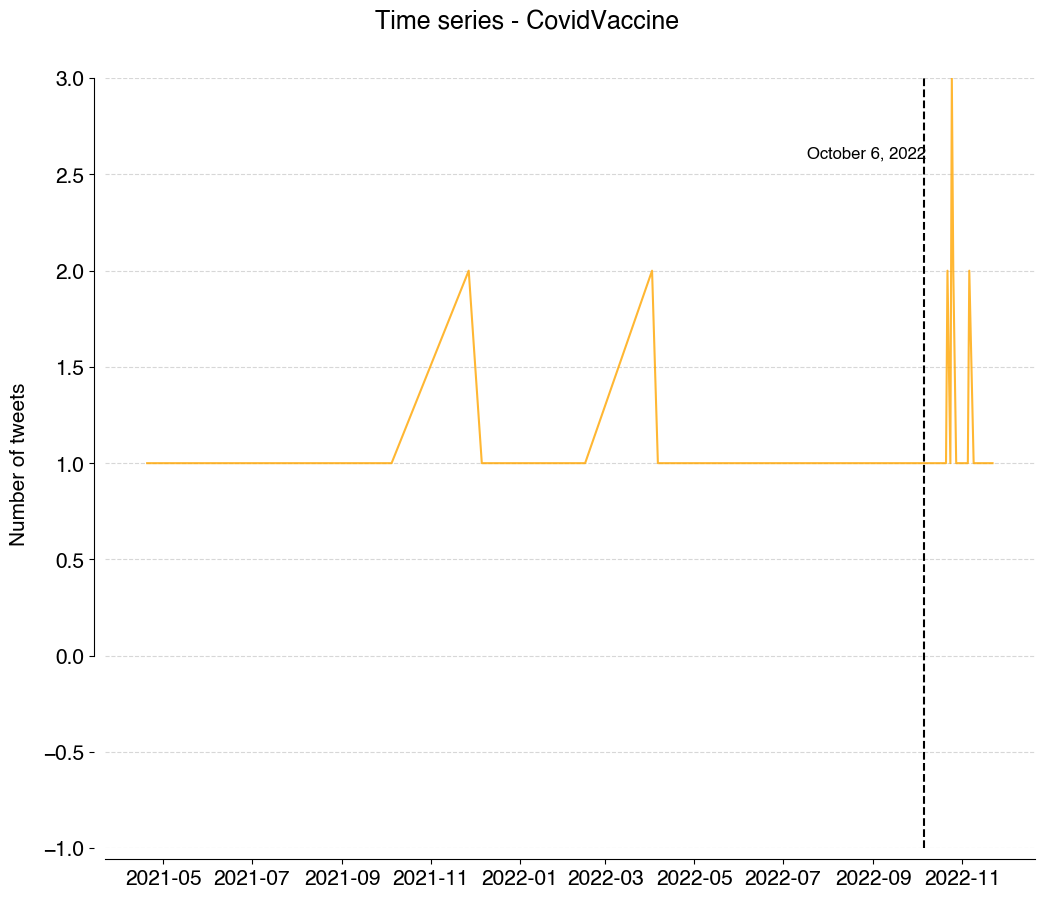

In [2224]:
t = memorial.groupby(['date']).count()['index']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(12,10))

ax.set_ylabel("Number of tweets", labelpad=10, fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

fig.text(0.35, 0.93, 'Time series - CovidVaccine', fontsize=18, fontweight='black', color = 'black')
plt.plot(t, color='orange', alpha=0.8);
sns.despine()
ax.spines['left'].set_bounds((0, 3))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
import datetime
d = datetime.date(2022, 10, 6)
plt.axvline(x = d, color = 'black', label = 'axvline - full height', linestyle='--')
fig.text(0.71, 0.8, 'October 6, 2022', fontsize=12, fontweight='black', color = 'black')
#plt.xlim(left=-1)
ax.set_ylim(-1,max(t))
ax.yaxis.grid(linestyle='--', alpha=0.5)

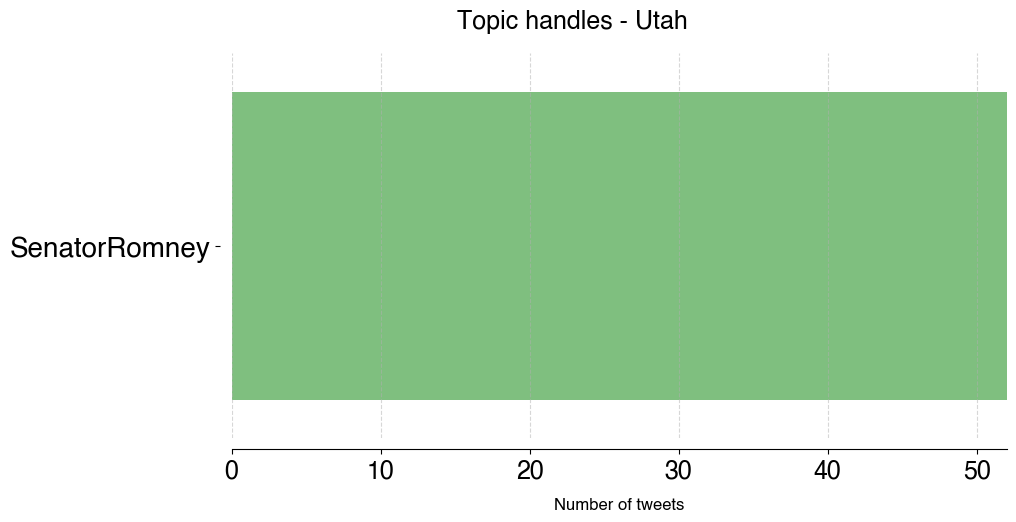

In [229]:
memorial = doc_info_color[doc_info_color['Topic'] == 11]
counts = memorial.groupby(['handle']).count()['index']
counts = counts.sort_values()
names = counts.reset_index()['handle']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(10,5))

ax.set_xlabel('Number of tweets', fontsize=12, fontweight='black', color = 'black', labelpad=10)
ax.set_ylabel("", labelpad=1)
ax.tick_params(axis='both', which='major', labelsize=12)

fig.text(0.35, 0.93, 'Topic handles - Utah', fontsize=18, fontweight='black', color = 'black')

#stab = doc_info.groupby(['Topic']).count()
#stab = stab['index']
#stab_names = list(set(doc_info_color['Topic']))
 
plt.barh(names, counts, color='green', alpha=0.5)
#plt.legend(['Republican', 'Democrat', 'Independent'])
sns.despine()
ax.spines['left'].set_bounds((0, 0))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
plt.xlim(left=-1)
ax.set_ylim(-0.5,len(names)-0.5)
ax.set_xlim(0, max(counts))
ax.xaxis.grid(linestyle='--', alpha=0.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
plt.show()

#ax.spines['left'].set_bounds((0, 800))
#ax.spines['left'].set_position(('outward', 8))
#ax.spines['bottom'].set_position(('outward', 8))
#plt.xticks(rotation=30)



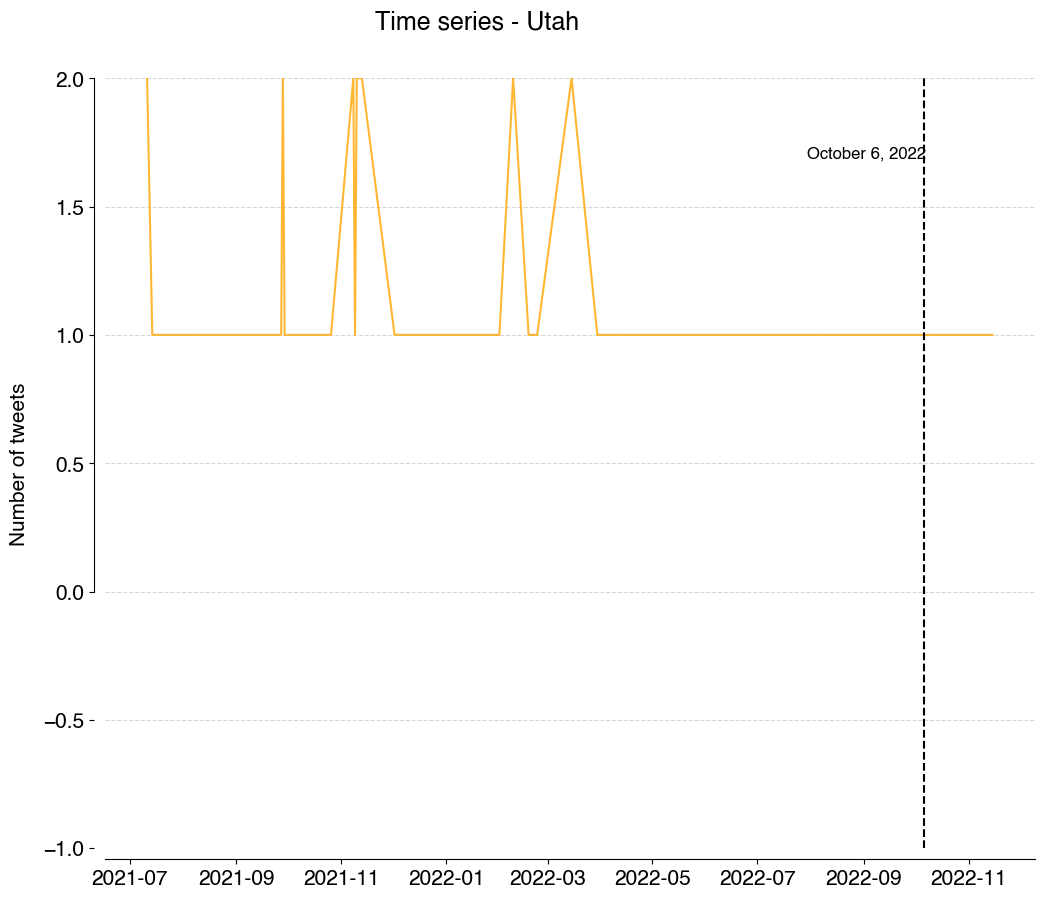

In [2227]:
t = memorial.groupby(['date']).count()['index']

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
fig, ax = plt.subplots(figsize=(12,10))

ax.set_ylabel("Number of tweets", labelpad=10, fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

fig.text(0.35, 0.93, 'Time series - Utah', fontsize=18, fontweight='black', color = 'black')
plt.plot(t, color='orange', alpha=0.8);
sns.despine()
ax.spines['left'].set_bounds((0, 2))
ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 8))
import datetime
d = datetime.date(2022, 10, 6)
plt.axvline(x = d, color = 'black', label = 'axvline - full height', linestyle='--')
fig.text(0.71, 0.8, 'October 6, 2022', fontsize=12, fontweight='black', color = 'black')
#plt.xlim(left=-1)
ax.set_ylim(-1,max(t))
ax.yaxis.grid(linestyle='--', alpha=0.5)

In [2000]:
df.text.iloc[20009]

'The needs of Utahns have been forefront as I’ve helped negotiate our bipartisan infrastructure plan. Our plan would provide Utah with funding to expand our physical infrastructure and help fight wildfires without tax increases or adding to the deficit. https://t.co/ZQRu5TwnBf'

In [1999]:
df.iloc[20009]

date                                          2021-07-11 00:00:00
hour                                                     13:59:33
handle                                              SenatorRomney
color                                                         red
account_type                                         professional
text            The needs of Utahns have been forefront as I’v...
tweet           need Utahns forefront help negotiate bipartisa...
mentions                                                       []
tokens          [The, needs, of, Utahns, have, been, forefront...
stopwords       [needs, Utahns, forefront, helped, negotiate, ...
hashtags                                                       []
week                                                           27
weekday                                                         7
month                                                        July
year                                                         2021
care      

# Case Study

In [4]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October',
          'November', 'December']

In [5]:
# Step 1 - Extract embeddings
embedding_model = Word2Vec

# Step 2 - Reduce dimensionality
umap_model = BaseDimensionalityReduction()

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN()

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(ngram_range=(1, 1))

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True, bm25_weighting=False)

# All steps together
topic_model = BERTopic(
    verbose=False,
    embedding_model=embedding_model,          # Step 1 - Extract embeddings
    umap_model=umap_model,                    # Step 2 - Reduce dimensionality
    hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
    vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model
)

NameError: name 'Word2Vec' is not defined

In [2438]:
num_months = [1,2,3,4,5,6,7,8,9,10,11,12]
topics2021 = {}
topics2022 = {}
tweettopics2021 = {}
tweettopics2022 = {}
#2021
for month in num_months:
    print(month)
    month_df = df2021[df2021['month'] == month]
    topics, probs = topic_model.fit_transform(month_df['tweet'].tolist())
    topics2021[month] = topic_model.get_topic_info()[1:]
    tweettopics2021[month] = topic_model.get_document_info(month_df['tweet'])

1


2023-09-19 18:52:31,711 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:52:31,712 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:52:31,712 - BERTopic - Reduced dimensionality
2023-09-19 18:52:31,722 - BERTopic - Clustered reduced embeddings


2


2023-09-19 18:52:32,303 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:52:32,304 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:52:32,304 - BERTopic - Reduced dimensionality
2023-09-19 18:52:32,327 - BERTopic - Clustered reduced embeddings


3


2023-09-19 18:52:32,857 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:52:32,858 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:52:32,858 - BERTopic - Reduced dimensionality
2023-09-19 18:52:32,878 - BERTopic - Clustered reduced embeddings


4


2023-09-19 18:52:33,286 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:52:33,286 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:52:33,286 - BERTopic - Reduced dimensionality
2023-09-19 18:52:33,300 - BERTopic - Clustered reduced embeddings


5


2023-09-19 18:52:33,687 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:52:33,687 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:52:33,687 - BERTopic - Reduced dimensionality
2023-09-19 18:52:33,701 - BERTopic - Clustered reduced embeddings


6


2023-09-19 18:52:34,120 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:52:34,120 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:52:34,120 - BERTopic - Reduced dimensionality
2023-09-19 18:52:34,137 - BERTopic - Clustered reduced embeddings


7


2023-09-19 18:52:34,781 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:52:34,781 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:52:34,781 - BERTopic - Reduced dimensionality
2023-09-19 18:52:34,814 - BERTopic - Clustered reduced embeddings


8


2023-09-19 18:52:35,468 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:52:35,469 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:52:35,469 - BERTopic - Reduced dimensionality
2023-09-19 18:52:35,503 - BERTopic - Clustered reduced embeddings


9


2023-09-19 18:52:36,440 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:52:36,441 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:52:36,441 - BERTopic - Reduced dimensionality
2023-09-19 18:52:36,510 - BERTopic - Clustered reduced embeddings


10


2023-09-19 18:52:37,401 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:52:37,401 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:52:37,402 - BERTopic - Reduced dimensionality
2023-09-19 18:52:37,470 - BERTopic - Clustered reduced embeddings


11


2023-09-19 18:52:38,507 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:52:38,507 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:52:38,507 - BERTopic - Reduced dimensionality
2023-09-19 18:52:38,608 - BERTopic - Clustered reduced embeddings


12


2023-09-19 18:52:40,060 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:52:40,060 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:52:40,060 - BERTopic - Reduced dimensionality
2023-09-19 18:52:40,243 - BERTopic - Clustered reduced embeddings


In [2439]:
#2022
for month in num_months[:11]:
    print(month)
    month_df = df2022[df2022['month'] == month]
    topic_model = topic_model
    topics, probs = topic_model.fit_transform(month_df['tweet'].tolist())
    topics2022[month] = topic_model.get_topic_info()[1:]
    tweettopics2022[month] = topic_model.get_document_info(month_df['tweet'])

1


2023-09-19 18:52:48,197 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:52:48,197 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:52:48,197 - BERTopic - Reduced dimensionality
2023-09-19 18:52:48,410 - BERTopic - Clustered reduced embeddings


2


2023-09-19 18:52:50,028 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:52:50,028 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:52:50,028 - BERTopic - Reduced dimensionality
2023-09-19 18:52:50,233 - BERTopic - Clustered reduced embeddings


3


2023-09-19 18:52:53,648 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:52:53,648 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:52:53,648 - BERTopic - Reduced dimensionality
2023-09-19 18:52:54,538 - BERTopic - Clustered reduced embeddings


4


2023-09-19 18:52:57,561 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:52:57,561 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:52:57,562 - BERTopic - Reduced dimensionality
2023-09-19 18:52:58,351 - BERTopic - Clustered reduced embeddings


5


2023-09-19 18:53:02,337 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:53:02,337 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:53:02,337 - BERTopic - Reduced dimensionality
2023-09-19 18:53:03,568 - BERTopic - Clustered reduced embeddings


6


2023-09-19 18:53:08,160 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:53:08,161 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:53:08,161 - BERTopic - Reduced dimensionality
2023-09-19 18:53:09,888 - BERTopic - Clustered reduced embeddings


7


2023-09-19 18:53:14,356 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:53:14,357 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:53:14,357 - BERTopic - Reduced dimensionality
2023-09-19 18:53:16,161 - BERTopic - Clustered reduced embeddings


8


2023-09-19 18:53:22,748 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:53:22,748 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:53:22,748 - BERTopic - Reduced dimensionality
2023-09-19 18:53:26,372 - BERTopic - Clustered reduced embeddings


9


2023-09-19 18:53:35,543 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:53:35,543 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:53:35,543 - BERTopic - Reduced dimensionality
2023-09-19 18:53:43,742 - BERTopic - Clustered reduced embeddings


10


2023-09-19 18:53:55,254 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:53:55,255 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:53:55,255 - BERTopic - Reduced dimensionality
2023-09-19 18:54:04,547 - BERTopic - Clustered reduced embeddings


11


2023-09-19 18:54:11,434 - BERTopic - Transformed documents to Embeddings
2023-09-19 18:54:11,434 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-09-19 18:54:11,434 - BERTopic - Reduced dimensionality
2023-09-19 18:54:16,299 - BERTopic - Clustered reduced embeddings


In [2295]:
from collections import Counter
import math

def jaccard_similarity(lst1,lst2):
    intersection = len([value for value in lst1 if value in lst2])
    #intersection = len(set(l1).intersection(l2))
    union = (len(set(lst1)) + len(set(lst2))) - intersection
    return round(intersection / union,3)

def cosine_similarity(list_A,list_B):
    c1 = Counter(list_A)
    c2 = Counter(list_B)
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return round(dotprod / (magA * magB),3)

In [2296]:
def month_similarity_2021(month1, month2):
    #dict to save each month similarities to the next
    result = {}  
    for i in range(1, 1+len(topics2021[month1]['Representation'])):
        topic = [] 
        rep1 = topics2021[month1]['Representation'][i]
        for j in range(1, 1+len(topics2021[month2]['Representation'])):
            rep2 = topics2021[month2]['Representation'][j]
            topic.append(cosine_similarity(rep1,rep2))
        result[i] = topic
    return result

def month_similarity_2022(month1, month2):
    #dict to save each month similarities to the next
    result = {}  
    for i in range(1, 1+len(topics2022[month1]['Representation'])):
        topic = [] 
        rep1 = topics2022[month1]['Representation'][i]
        for j in range(1, 1+len(topics2022[month2]['Representation'])):
            rep2 = topics2022[month2]['Representation'][j]
            topic.append(cosine_similarity(rep1,rep2))
        result[i] = topic
    return result

def month_similarity_between_years(month1, month2):
    #dict to save each month similarities to the next
    result = {}  
    for i in range(1, 1+len(topics2021[month1]['Representation'])):
        topic = [] 
        rep1 = topics2021[month1]['Representation'][i]
        for j in range(1, 1+len(topics2022[month2]['Representation'])):
            rep2 = topics2022[month2]['Representation'][j]
            topic.append(cosine_similarity(rep1,rep2))
        result[i] = topic
    return result

In [2447]:
#2021
twenty1 = {}
twenty2 = {}
for i in range(len(num_months)-1):
    twenty1[num_months[i]] = month_similarity_2021(num_months[i], num_months[i+1])
for i in range((len(num_months)-2)):
    twenty2[num_months[i]] = month_similarity_2022(num_months[i], num_months[i+1])
twenty1['December'] = month_similarity_between_years(12, 1)

In [2448]:
twenty1

{1: {},
 2: {1: [0.2, 0.0, 0.0], 2: [0.0, 0.0, 0.0]},
 3: {1: [0.0, 0.0, 0.0], 2: [0.0, 0.1, 0.0], 3: [0.0, 0.0, 0.0]},
 4: {1: [0.2, 0.0], 2: [0.0, 0.0], 3: [0.1, 0.0]},
 5: {1: [0.4, 0.0], 2: [0.0, 0.1]},
 6: {1: [0.0, 0.1, 0.0, 0.0, 0.1, 0.0], 2: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
 7: {1: [0.1, 0.0, 0.0, 0.0],
  2: [0.1, 0.0, 0.0, 0.0],
  3: [0.0, 0.0, 0.5, 0.0],
  4: [0.0, 0.0, 0.0, 0.0],
  5: [0.0, 0.0, 0.0, 0.0],
  6: [0.0, 0.0, 0.0, 0.0]},
 8: {1: [0.5, 0.0], 2: [0.0, 0.0], 3: [0.0, 0.0], 4: [0.0, 0.0]},
 9: {1: [0.3, 0.0, 0.0, 0.0, 0.0, 0.1], 2: [0.0, 0.1, 0.0, 0.0, 0.0, 0.0]},
 10: {1: [0.3, 0.0, 0.0],
  2: [0.0, 0.0, 0.0],
  3: [0.0, 0.0, 0.0],
  4: [0.0, 0.0, 0.0],
  5: [0.0, 0.0, 0.0],
  6: [0.0, 0.0, 0.1]},
 11: {1: [0.1, 0.0], 2: [0.0, 0.0], 3: [0.0, 0.0]},
 'December': {1: [0.2, 0.1, 0.1, 0.0, 0.0, 0.0],
  2: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}}

In [2449]:
twenty2

{1: {1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  2: [0.0, 0.4, 0.1, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  3: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0],
  4: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  5: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  6: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
 2: {1: [0.3, 0.0, 0.0],
  2: [0.0, 0.0, 0.0],
  3: [0.0, 0.0, 0.0],
  4: [0.0, 0.0, 0.0],
  5: [0.0, 0.0, 0.0],
  6: [0.0, 0.0, 0.0],
  7: [0.1, 0.0, 0.0],
  8: [0.0, 0.0, 0.0],
  9: [0.0, 0.0, 0.079],
  10: [0.0, 0.0, 0.0],
  11: [0.0, 0.0, 0.0],
  12: [0.0, 0.0, 0.0],
  13: [0.0, 0.0, 0.0]},
 3: {1: [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.2,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  2: [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
  

In [2451]:
topics2021[1]

Empty DataFrame
Columns: [Topic, Count, Name, Representation, Representative_Docs]
Index: []

In [2452]:
topics2021[2]

Topic  Count                                  Name   
1      0    136             0_trump_covid_relief_need  \
2      1      9  1_robinhood_trade_customers_business   

                                      Representation   
1  [trump, covid, relief, need, incite, president...  \
2  [robinhood, trade, customers, business, custom...   

                                 Representative_Docs  
1  [Science data disprove Democrats notion K-12 s...  
2  [Citadel repeatedly break law place stock trad...

In [2456]:
topics2021[3]

Topic  Count                            Name   
1      0     38   0_asian_american_relief_check  \
2      1     14  1_voter_vote_georgia_democracy   
3      2      6   2_filibuster_senate_would_use   

                                      Representation   
1  [asian, american, relief, check, plan, covid, ...  \
2  [voter, vote, georgia, democracy, suppression,...   
3  [filibuster, senate, would, use, express, lane...   

                                 Representative_Docs  
1  [1,400 check already bank account Vaccines com...  
2  [lose Georgia GOP waste time Working hard supp...  
3  [Last Congress Sen. Schumer Democrats use fili...

In [2455]:
topics2021[4]

Topic  Count                                            Name   
1      0     49  0_infrastructure_republicans_democrats_climate  \
2      1     10                  1_officer_capitol_evans_police   
3      2      8             2_genocide_armenian_recognize_truth   

                                      Representation   
1  [infrastructure, republicans, democrats, clima...  \
2  [officer, capitol, evans, police, billy, die, ...   
3  [genocide, armenian, recognize, truth, potus, ...   

                                 Representative_Docs  
1  [Today Senate Republicans introduce framework ...  
2  [heart go Officer Billy Evans family especiall...  
3  [lead 100 members call POTUS recognize Armenia...

In [2457]:
topics2021[5]

Topic  Count                                   Name   
1      0     84     0_vote_trump_democracy_republicans  \
2      1      6  1_israel_terrorist_hamas_palestinians   

                                      Representation   
1  [vote, trump, democracy, republicans, truth, l...  \
2  [israel, terrorist, hamas, palestinians, ally,...   

                                 Representative_Docs  
1  [Democrats partisan power-grab “ election refo...  
2  ['m proud steadfast supporter Israel U.S. stan...

In [2458]:
topics2021[6]

Topic  Count                                       Name   
1      0     56  0_vote_democrats_infrastructure_democracy  \
2      1      9                   1_lgbtq_pride_month_carl   

                                      Representation   
1  [vote, democrats, infrastructure, democracy, s...  \
2  [lgbtq, pride, month, carl, shoulder, proud, a...   

                                 Representative_Docs  
1  [Republicans try rip away right vote state sta...  
2  [Proud Carl Nassib courageously live truth Rep...

In [2459]:
topics2021[7]

Topic  Count                                      Name   
1      0     23  0_marijuana_marijuanajustice_federal_war  \
2      1     19             1_child_families_payments_cut   
3      2     18        2_vaccines_vaccine_covid_vaccinate   
4      3      7                3_mccarthy_gop_trump_kevin   
5      4      7        4_democracy_wherever_facts_january   
6      5      6                 5_cuba_brave_cuban_regime   

                                      Representation   
1  [marijuana, marijuanajustice, federal, war, bi...  \
2  [child, families, payments, cut, childtaxcredi...   
3  [vaccines, vaccine, covid, vaccinate, 19, covi...   
4  [mccarthy, gop, trump, kevin, never, january, ...   
5  [democracy, wherever, facts, january, mob, see...   
6  [cuba, brave, cuban, regime, injustices, miami...   

                                 Representative_Docs  
1  [Ending federal marijuana prohibition fix bank...  
2  [BIG NEWS July 15 first Child Tax Credit payme...  
3  [Getting vaccinate best way keep communities s...  
4  [McCarthy cry foul remember Democrats negotiat...  
5  [January 6 attack citadel democracy Americans ...  
6  [celebrate nation independence let us continue...

In [2460]:
topics2021[8]

Topic  Count                                              Name   
1      0     78              0_infrastructure_bill_tax_bipartisan  \
2      1     54         1_afghanistan_afghan_administration_biden   
3      2      9                    2_vaccine_safe_effective_covid   
4      3      6  3_congratulations_jerseypride_incredible_teamusa   

                                      Representation   
1  [infrastructure, bill, tax, bipartisan, pass, ...  \
2  [afghanistan, afghan, administration, biden, p...   
3  [vaccine, safe, effective, covid, fda, vaccine...   
4  [congratulations, jerseypride, incredible, tea...   

                                 Representative_Docs  
1  [landmark infrastructure package allow New Jer...  
2  [happen Afghanistan humanitarian foreign polic...  
3  [FDA officially grant full approval Pfizer vac...  
4  [Congratulations former UtahGymnastics athlete...

In [2461]:
topics2021[9]

Topic  Count                       Name   
1      0    247  0_need_democrats_tax_must  \
2      1      5     1_tovah_mar_kippur_yom   

                                      Representation   
1  [need, democrats, tax, must, work, families, c...  \
2  [tovah, mar, kippur, yom, meaningful, hope, ob...   

                                 Representative_Docs  
1  [pharmaceutical industry want us lower cost pr...  
2  [observe hope bless Yom Kippur meaningful fast...

In [2462]:
topics2021[10]

Topic  Count                                  Name   
1      0     87   0_bill_americans_american_democrats  \
2      1     14  1_midnight_book_washington_democracy   
3      2      8   2_subpoena_criminal_contempt_bannon   
4      3      8              3_schiff_adam_rep_sunday   
5      4      8             4_china_global_ccp_taiwan   
6      5      7          5_register_vote_day_november   

                                      Representation   
1  [bill, americans, american, democrats, people,...  \
2  [midnight, book, washington, democracy, copy, ...   
3  [subpoena, criminal, contempt, bannon, comply,...   
4  [schiff, adam, rep, sunday, insurrection, fact...   
5  [china, global, ccp, taiwan, ambition, become,...   
6  [register, vote, day, november, early, york, e...   

                                 Representative_Docs  
1  [Reconciliation Bill transformational take Pha...  
2  [Last night sit maddow MSNBC deeply grateful c...  
3  [matter Biden Administration already waive exe...  
4  [sfpelosi insurrectionists whitewash Jan6th Ad...  
5  [Amid significant threats pose China illicit a...  
6  [TODAY last day New Yorkers register vote Nove...

In [2463]:
topics2021[11]

Topic  Count                                       Name   
1      0     99  0_infrastructure_bipartisan_bill_families  \
2      1     17       1_hanukkah_happy_thanksgiving_family   
3      2     13           2_veterans_service_day_sacrifice   

                                      Representation   
1  [infrastructure, bipartisan, bill, families, b...  \
2  [hanukkah, happy, thanksgiving, family, happin...   
3  [veterans, service, day, sacrifice, veteransda...   

                                 Representative_Docs  
1  [Together Bipartisan Infrastructure Deal Build...  
2  [Hanukkah celebrate many miracles live ones lo...  
3  [reverence freedom importance service value en...

In [2464]:
topics2021[12]

Topic  Count                                    Name   
1      0    423                 0_workers_work_back_get  \
2      1      6  1_contempt_meadows_mark_january6thcmte   

                                      Representation   
1  [workers, work, back, get, make, people, must,...  \
2  [contempt, meadows, mark, january6thcmte, appe...   

                                 Representative_Docs  
1  [Kellogg company make 1.4 billion profit last ...  
2  [Jan 6 committee vote recommend House hold Jef...

In [2465]:
topics2022[1]

Topic  Count                                       Name   
1      0     94                 0_vote_act_right_democracy  \
2      1     40              1_kroger_wealth_workers_greed   
3      2     26                   2_mask_booster_covid_n95   
4      3     12            3_bragg_alvin_enforce_manhattan   
5      4     11  4_holocaust_remembrance_jews_antisemitism   
6      5      9         5_wade_roe_abortion_constitutional   

                                      Representation   
1  [vote, act, right, democracy, freedom, king, s...  \
2  [kroger, wealth, workers, greed, growth, decen...   
3  [mask, booster, covid, n95, vaccine, vaccinate...   
4  [bragg, alvin, enforce, manhattan, da, law, go...   
5  [holocaust, remembrance, jews, antisemitism, m...   
6  [wade, roe, abortion, constitutional, 49, repr...   

                                 Representative_Docs  
1  [must protect vote right Senate must pass Free...  
2  [LIVE workers consider essential enough work p...  
3  [200 million Americans vaccinate One billion f...  
4  [Manhattan DA Alvin Bragg want let criminals w...  
5  [HolocaustRemembranceDay honor 11 million vict...  
6  [Today mark 49 years since Roe v. Wade guarant...

In [2466]:
topics2022[2]

Topic  Count                                        Name   
1       0     73                  0_putin_russia_ukraine_war  \
2       1     20      1_starbucks_workers_organize_corporate   
3       2     20          2_drug_prescription_pharma_insulin   
4       3     15                 3_jackson_judge_court_brown   
5       4     14               4_history_black_african_month   
6       5     14                5_utahns_olympics_2002_games   
7       6     11        6_economy_wealth_billionaires_bottom   
8       7     10                  7_happy_tiger_lunar_cancer   
9       8      9                 8_mask_kathy_mandate_hochul   
10      9      7            9_program_child_federal_children   
11     10      6           10_inflation_spin_supercharge_101   
12     11      5  11_implement_infrastructure_bill_provision   
13     12      5      12_louisianians_hurricanes_flood_laura   

                                       Representation   
1   [putin, russia, ukraine, war, invasion, russia...  \
2   [starbucks, workers, organize, corporate, prof...   
3   [drug, prescription, pharma, insulin, pharmace...   
4   [jackson, judge, court, brown, ketanji, suprem...   
5   [history, black, african, month, celebrate, te...   
6   [utahns, olympics, 2002, games, olympic, utah,...   
7   [economy, wealth, billionaires, bottom, job, i...   
8   [happy, tiger, lunar, cancer, year, celebrate,...   
9   [mask, kathy, mandate, hochul, school, young, ...   
10  [program, child, federal, children, impact, im...   
11  [inflation, spin, supercharge, 101, anyway, wo...   
12  [implement, infrastructure, bill, provision, b...   
13  [louisianians, hurricanes, flood, laura, ida, ...   

                                  Representative_Docs  
1   [Putin oligarch friends seek divide world dest...  
2   [Profits Starbucks CEO get BIG raise last year...  
3   [Nearly one four Americans struggle afford pre...  
4   [Today POTUS make history nomination Judge Ket...  
5   ['m proud join RepBowman effort TellTheTruth A...  
6   [Tonight watch Olympics open ceremonies Salt L...  
7   [still lot work ahead us focus get Americans b...  
8   [past 20 years people survive endure cancer di...  
9   [Maskless Kathy Hochul hug kiss Hillary Clinto...  
10  [Existing family program kind impact ought chi...  
11  [American families face worst inflation 40 yea...  
12  [Nearly half Utah Navajo Nation run water home...  
13  [Louisianians still suffer destruction Hurrica...

In [2467]:
topics2022[3]

Topic  Count                          Name   
1      0   1250   0_ukraine_putin_russia_work  \
2      1     12  1_lord_psalms_praise_matthew   
3      2      5      2_days_ago_write_exactly   

                                      Representation   
1  [ukraine, putin, russia, work, biden, people, ...  \
2  [lord, psalms, praise, matthew, name, god, fat...   
3  [days, ago, write, exactly, two, happen, well,...   

                                 Representative_Docs  
1  [Congresswoman MadeleineDean answer call publi...  
2  [Awake sleep Lord Rise reject us forever hide ...  
3  [2 days ago well, write 8 days ago exactly hap...

In [2468]:
topics2022[4]

Topic  Count                                               Name   
1       0     60                      0_jackson_ketanji_brown_judge  \
2       1     46             1_starbucks_amazon_workers_amazonlabor   
3       2     35                         2_student_debt_loan_cancel   
4       3     32           3_republicans_raise_affordable_democrats   
5       4     21                   4_easter_celebrate_happy_sameach   
6       5     14                     5_border_illegal_immigrants_42   
7       6     13                          6_putin_ukraine_war_deter   
8       7     12                      7_earth_climate_tackle_planet   
9       8     11                   8_maternal_women_health_systemic   
10      9     11           9_marijuana_convictions_expunge_cannabis   
11     10     11                   10_jews_holocaust_bigotry_murder   
12     11     10                     11_episode_firebrand_matt_feat   
13     12      9                          12_iran_nuclear_2015_deal   
14     13      7      13_corystories_kindness_profoundly_compassion   
15     14      7  14_oklahoma_unconstitutional_abortion_reproduc...   
16     15      6                      15_ramadan_mubarak_holy_month   
17     16      6               16_victims_violence_horrific_monitor   
18     17      5       17_infrastructure_bipartisan_modernize_roads   
19     18      5                         18_hit_inflation_food_math   
20     19      5                19_china_well_economically_lockdown   
21     20      5               20_norway_krutnes_anniken_livestream   

                                       Representation   
1   [jackson, ketanji, brown, judge, court, suprem...  \
2   [starbucks, amazon, workers, amazonlabor, unio...   
3   [student, debt, loan, cancel, cancelstudentdeb...   
4   [republicans, raise, affordable, democrats, ta...   
5   [easter, celebrate, happy, sameach, chag, pass...   
6   [border, illegal, immigrants, 42, title, cross...   
7   [putin, ukraine, war, deter, ukrainian, barrel...   
8   [earth, climate, tackle, planet, existential, ...   
9   [maternal, women, health, systemic, bias, blac...   
10  [marijuana, convictions, expunge, cannabis, dr...   
11  [jews, holocaust, bigotry, murder, hashoah, na...   
12  [episode, firebrand, matt, feat, gaetz, firebr...   
13  [iran, nuclear, 2015, deal, treaty, agreement,...   
14  [corystories, kindness, profoundly, compassion...   
15  [oklahoma, unconstitutional, abortion, reprodu...   
16  [ramadan, mubarak, holy, month, muslims, renew...   
17  [victims, violence, horrific, monitor, respond...   
18  [infrastructure, bipartisan, modernize, roads,...   
19  [hit, inflation, food, math, burgeon, salt, fu...   
20  [china, well, economically, lockdown, authorit...   
21  [norway, krutnes, anniken, livestream, ambassa...   

                                  Representative_Docs  
1   [proud Senate confirm Judge Ketanji Brown Jack...  
2   [organize victory Amazon Staten Island signal ...  
3   ['m glad POTUS extend pause student loan repay...  
4   [Democrats strengthen safety net make wealthy ...  
5   [wish happy Passover everyone celebrate Seder ...  
6   [Several Central American leaders inform traff...  
7   [Two months Ukrainian people heroic defense De...  
8   [Earth Day commit build future everyone clean ...  
9   [U.S. maternal mortality morbidity crisis sham...  
10  [Legalize marijuana Expunge past marijuana con...  
11  [Yom HaShoah remember six million Jews countle...  
12  [LIVE Episode 34 Laptop Hell feat Vish Burra F...  
13  [Biden Admin trip reenter Iran nuke deal even ...  
14  [Nothing happen take away inherent worth CoryS...  
15  [Republican-controlled state legislatures embo...  
16  [mark begin Ramadan want wish Muslim community...  
17  [heart break Sacramento become latest city tra...  
18  [Many America children breathe pollute air way...  
19  [Even furniture price skyrocket almost 10 Pres...  
20  [Remember “ smart ” people tell us China “ bea...  
21  [Tomor

In [2469]:
topics2022[5]

Topic  Count                            Name   
1      0   1056     0_right_abortion_must_fight  \
2      1     19                 1_cuba_de_en_la   
3      2     11  2_matt_firebrand_episode_gaetz   

                                      Representation   
1  [right, abortion, must, fight, people, make, w...  \
2  [cuba, de, en, la, régimen, biden, venezuela, ...   
3  [matt, firebrand, episode, gaetz, firebrand_po...   

                                 Representative_Docs  
1  [rally together Long Island today reproductive...  
2  [Biden eliminó la FARC marxistas en Colombia d...  
3  [Episode 45 Bushes Losing feat Darren Beattie ...

In [2470]:
topics2022[6]

Topic  Count                                    Name   
1       0    185                0_abortion_roe_gun_right  \
2       1     49             1_student_debt_cancel_potus   
3       2     28            2_lgbtq_pride_month_equality   
4       3     25          3_birthday_friend_daca_wishing   
5       4     19             4_vaccines_covid_vaccine_19   
6       5     18          5_toxic_pact_veterans_honoring   
7       6     17          6_firebrand_episode_matt_gaetz   
8       7     16      7_mobrooks_huntsville_poll_alabama   
9       8     15          8_father_dads_happy_fathersday   
10      9     15  9_juneteenth_slavery_enslave_celebrate   
11     10     12            10_trump_donald_election_lie   
12     11     11        11_jackson_ketanji_brown_justice   
13     12     10          12_child_affordable_by_quality   
14     13      8         13_shipping_ocean_chain_relieve   
15     14      6        14_pardon_seek_congressman_wrong   
16     15      5        15_climate_ability_epa_polluters   
17     16      5     16_development_workforce_chain_cost   

                                       Representation   
1   [abortion, roe, gun, right, safety, violence, ...  \
2   [student, debt, cancel, potus, loan, borrowers...   
3   [lgbtq, pride, month, equality, celebrate, com...   
4   [birthday, friend, daca, wishing, happy, membe...   
5   [vaccines, covid, vaccine, 19, cdc, fda, manda...   
6   [toxic, pact, veterans, honoring, pit, burn, e...   
7   [firebrand, episode, matt, gaetz, firebrand_po...   
8   [mobrooks, huntsville, poll, alabama, birmingh...   
9   [father, dads, happy, fathersday, dad, figure,...   
10  [juneteenth, slavery, enslave, celebrate, blac...   
11  [trump, donald, election, lie, claim, spread, ...   
12  [jackson, ketanji, brown, justice, perspective...   
13  [child, affordable, by, quality, profits, care...   
14  [shipping, ocean, chain, relieve, supply, refo...   
15  [pardon, seek, congressman, wrong, january, sa...   
16  [climate, ability, epa, polluters, pollute, mi...   
17  [development, workforce, chain, cost, supply, ...   

                                  Representative_Docs  
1   [Supreme Court overturn Roe abortion could ban...  
2   [Look face POTUS relief joy must lift burden 4...  
3   [Pride month—and every month—we celebrate hard...  
4   [Wishing happy birthday friend CA09 RepMcNerne...  
5   [early next week pending CDC recommendations p...  
6   [many nation veterans suffer illnesses cause t...  
7   [Episode 51 LIVE Revolver News Roundup feat Da...  
8   [MoBrooks RandPaul en route Alabama Come see u...  
9   [Missing father today grateful many memories l...  
10  [Juneteenth celebration—but also reminder figh...  
11  [Donald Trump unfounded claim fraud put electi...  
12  [first time American history Black woman serve...  
13  [Expanding child care would also help fight in...  
14  [Senate Democrats act reduce cost American fam...  
15  [Every member Congress able answer one questio...  
16  [Supreme Court decide case could eviscerate ab...  
17  [House Democrats take action bring price pump ...

In [2471]:
topics2022[7]

Topic  Count                        Name   
1      0   1523       0_right_biden_get_act  \
2      1      9  1_abe_japan_minister_prime   

                                      Representation   
1  [right, biden, get, act, work, make, people, a...  \
2  [abe, japan, minister, prime, shinzo, japanese...   

                                 Representative_Docs  
1  [SenCortezMasto gillibrandny introduce legisla...  
2  [sadden death Shinzo Abe former Prime Minister...

In [2472]:
topics2022[8]

Topic  Count                                 Name   
1      0   2030       0_inflation_act_reduction_cost  \
2      1     14       1_gaetz_matt_firebrand_episode   
3      2      6  2_brittney_griner_sentence_wrongful   

                                      Representation   
1  [inflation, act, reduction, cost, people, demo...  \
2  [gaetz, matt, firebrand, episode, feat, tampaf...   
3  [brittney, griner, sentence, wrongful, russia,...   

                                 Representative_Docs  
1  [Historic legislation pass House Inflation Red...  
2  [Firebrand_Pod Episode 65 LIVE Spy Games Fireb...  
3  [Brittney Griner sentence unjust unacceptable ...

In [2473]:
topics2022[9]

Topic  Count                                               Name   
1       0    233                      0_abortion_ban_reduction_care  \
2       1     84               1_strong_housegop_economy_commitment   
3       2     58                          2_nhc_atlantic_edt_ian_fl   
4       3     29                   3_2001_11_neverforget_responders   
5       4     29       4_whistleblower_fbi_retaliate_whistleblowers   
6       5     26                      5_labor_unions_laborday_union   
7       6     25                    6_birthday_friend_wishing_happy   
8       7     24                        7_rosh_hashanah_shana_sweet   
9       8     23                      8_puerto_rico_fiona_hurricane   
10      9     22                       9_queen_elizabeth_ii_kingdom   
11     10     19                        10_crime_defund_police_soft   
12     11     16             11_debt_student_borrowers_cancellation   
13     12     15  12_registration_register_nationalvoterregistra...   
14     13     14  13_hispanic_heritage_fabric_hispanicheritagemonth   
15     14     14                14_dark_disclose_money_transparency   
16     15     13                       15_g7_speakers_ukraine_putin   
17     16     12     16_bidenbordercrisis_border_alien_deliberately   
18     17     12                        17_mahsa_amini_iranian_iran   
19     18     12                   18_pawn_humanity_disgust_dignity   
20     19     12        19_judiciarygop_rephankjohnson_recap_twenty   
21     20     11              20_swimmer_rileygaines_kentucky_sport   
22     21     11                     21_stock_spouses_trade_members   
23     22     10            22_armenia_azerbaijan_ceasefire_yerevan   
24     23     10                          23_weapons_assault_ban_37   
25     24      9            24_988_suicide_confidential_988lifeline   
26     25      8      25_mgc_mil_joaquincastrotx_compliment_latinos   
27     26      8               26_jackson_ketanji_brown_investiture   
28     27      8         27_michelle_barack_portraits_michelleobama   
29     28      8                    28_firebrand_episode_matt_gaetz   
30     29      7                       29_distract_high_salaries_40   
31     30      7                      30_rally_rsvp_lehigh_saturday   
32     31      7                            31_black_equal_cents_58   
33     32      6             32_innocence_8731_promotion_mutilation   
34     33      6                     33_school_dads_parent_children   
35     34      6                34_hunger_nutrition_diet_conference   
36     35      6                  35_circuit_judge_nominees_confirm   
37     36      5                         36_israel_nuclear_usa_axis   
38     37      5                  37_315_august_creating_jobsreport   
39     38      5             38_markruffalo_virtual_headline_annual   
40     39      5                 39_grill_fauci_dcexaminer_randpaul   

                                       Representation   
1   [abortion, ban, reduction, care, drug, health,...  \
2   [strong, housegop, economy, commitment, nation...   
3   [nhc_atlantic, edt, ian, fl, 28, hurricane, st...   
4   [2001, 11, neverforget, responders, september,...   
5   [whistleblower, fbi, retaliate, whistleblowers...   
6   [labor, unions, laborday, union, workers, wag,...   
7   [birthday, friend, wishing, happy, advocacy, s...   
8   [rosh, hashanah, shana, sweet, tova, healthy, ...   
9   [puerto, rico, fiona, hurricane, recover, fede...   
10  [queen, elizabeth, ii, kingdom, royal, majesty...   
11  [crime, defund, police, soft, on, federalize, ...   
12  [debt, student, borrowers, cancellation, loan,...   
13  [registration, register, nationalvoterregistra...   
14  [hispanic, heritage, fabric, hispanicheritagem...   
15  [dark, disclose, money, transparency, election...   
16  [g7, speakers, ukraine, putin, summit, autocra...   
17  [bidenbordercrisis, border, alien, deliberatel...   
18  [mahsa, amini, iranian, iran, protest, sensele...   
19  [pawn

In [2474]:
topics2022[10]

Topic  Count                                        Name   
1      0   3326          0_biden_make_democrats_republicans  \
2      1      7  1_israel_isaac_herzog_lebanon_breakthrough   

                                      Representation   
1  [biden, make, democrats, republicans, people, ...  \
2  [israel, isaac_herzog, lebanon, breakthrough, ...   

                                 Representative_Docs  
1  [House Democrats put PeopleOverPolitics delive...  
2  [honor welcome President Isaac_Herzog Israel W...

In [2475]:
topics2022[11]

Topic  Count                                         Name   
1       0     68                  0_poll_voice_location_early  \
2       1     53      1_victory_np_congratulations_democratic   
3       2     50    2_veterans_veteransday_happy_thanksgiving   
4       3     35                  3_student_debt_relief_block   
5       4     34                 4_violence_gun_lgbtq_springs   
6       5     33           5_medicare_prescription_lower_cost   
7       6     32   6_librarycongress_joaquincastrotx_flaco_la   
8       7     31             7_storm_nicole_subtropical_surge   
9       8     25        8_vaccine_covid_update_servicemembers   
10      9     19                 9_mccarthy_kevin_speaker_218   
11     10     18    10_infrastructure_roads_bipartisan_bridge   
12     11     17        11_marriage_respect_marry_interracial   
13     12     13  12_bidenflation_thanksgiving_expensive_meal   
14     13     12                          13_yes_read_mean_pa   
15     14     12               14_usmc_247th_marines_birthday   
16     15     11           15_doj_fbi_seanhannity_allegations   
17     16      9         16_astros_worldseries_series_houston   
18     17      8            17_audit_ukraine_resolution_penny   
19     18      8              18_kroger_albertsons_merger_ftc   
20     19      7          19_governors_paths_republican_truly   
21     20      7          20_greene_taylor_marjorie_mtgreenee   
22     21      7               21_protestors_iran_regime_sham   
23     22      7  22_overwhelmingly_abortion_zip_restrictions   
24     23      7    23_housegop_commitmenttoamerica_earn_amer   
25     24      7        24_reverendwarnock_runoff_georgia_dec   
26     25      6      25_sayfie_redwave2022_kissimmee_redwave   
27     26      6             26_angeles_mayor_karenbassla_los   
28     27      6      27_progressive_ourrevolution_caucus_voi   
29     28      5      28_bidenbordercrisis_roost_starts_worse   
30     29      5   29_agenda_accomplishing_vindication_gamble   

                                       Representation   
1   [poll, voice, location, early, hear, ballot, c...  \
2   [victory, np, congratulations, democratic, con...   
3   [veterans, veteransday, happy, thanksgiving, g...   
4   [student, debt, relief, block, loan, borrowers...   
5   [violence, gun, lgbtq, springs, trans, transge...   
6   [medicare, prescription, lower, cost, ban, soc...   
7   [librarycongress, joaquincastrotx, flaco, la, ...   
8   [storm, nicole, subtropical, surge, hurricane,...   
9   [vaccine, covid, update, servicemembers, vacci...   
10  [mccarthy, kevin, speaker, 218, assignment, qu...   
11  [infrastructure, roads, bipartisan, bridge, in...   
12  [marriage, respect, marry, interracial, equali...   
13  [bidenflation, thanksgiving, expensive, meal, ...   
14         [yes, read, mean, pa, good, thank, , , , ]   
15  [usmc, 247th, marines, birthday, semperfi, 247...   
16  [doj, fbi, seanhannity, allegations, whistlebl...   
17  [astros, worldseries, series, houston, phillie...   
18  [audit, ukraine, resolution, penny, dollar, ta...   
19  [kroger, albertsons, merger, ftc, store, groce...   
20  [governors, paths, republican, truly, reddest,...   
21  [greene, taylor, marjorie, mtgreenee, newsmax,...   
22  [protestors, iran, regime, sham, iranian, evil...   
23  [overwhelmingly, abortion, zip, restrictions, ...   
24  [housegop, commitmenttoamerica, earn, amer, re...   
25  [reverendwarnock, runoff, georgia, dec, donati...   
26  [sayfie, redwave2022, kissimmee, redwave, flor...   
27  [angeles, mayor, karenbassla, los, madam, kare...   
28  [progressive, ourrevolution, caucus, voi, fres...   
29  [bidenbordercrisis, roost, starts, worse, top,...   
30  [agenda, accomplishing, vindication, gamble, f...   

                                  Representative_Docs  
1   [Democratic House build People members candida...  
2   [Democratic Victory Congratulations Congressma...  
3   [Veterans deserve deepest appreciation respect..

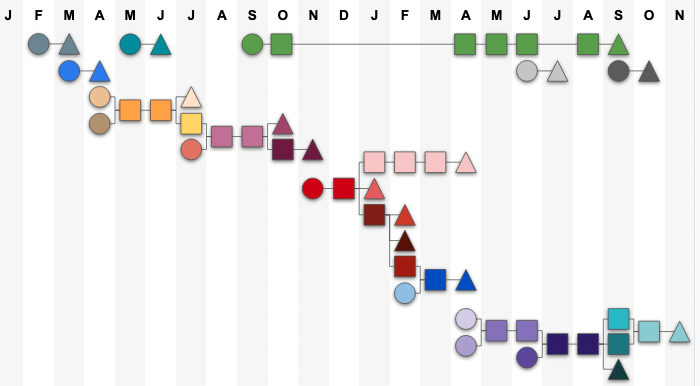

- three large groups
- five tiny groups
- one weirdo group, firebrand

For each topic, we first need to average its tweets scores on morality pillars

In [2674]:
#tweettopics2021 has the documents associated to each topic, by month
tweet_topics2021 = {}
tweet_topics2021_red = {}
tweet_topics2021_blue = {}
tweet_topics2021_white = {}
#first we want to remove outlier topic
for month in tqdm(num_months):
    cur = tweettopics2021[month]  
    cur = cur[cur['Topic'] != -1]
    cur = cur.drop_duplicates(subset=['Document'])
    cur = cur.reset_index()
    t = df2021[df2021.month == month]
    
    
    #now we need to fetch the morality scores per tweet
    a,b,c,d,e,f,g = ([] for j in range(7))
    for i in range(len(cur)):
        for m in range(len(t)):
            if (cur.Document.iloc[i] == t.tweet.iloc[m]):
                a.append(df2021.care.iloc[m])
                b.append(df2021.fairness.iloc[m])
                c.append(df2021.loyalty.iloc[m])
                d.append(df2021.authority.iloc[m])
                e.append(df2021.purity.iloc[m])
                f.append(df2021.date.iloc[m])
                g.append(df2021.color.iloc[m])
    
    #and retrieve the scores to tweet_topics2021
    cur['care'] = a
    cur['fairness'] = b
    cur['loyalty'] = c
    cur['authority'] = d
    cur['purity'] = e
    cur['date'] = f
    cur['color'] = g
    
    #now, group by topic and determine avg of scores
    cur_gb = cur.groupby(['Topic']).mean('care')
    
    #let's separate by colors as well
    cur_red = cur[cur.color == 'red']
    cur_blue = cur[cur.color == 'blue']
    cur_white = cur[cur.color == 'white']
    
    cur_gb_red = cur_red.groupby(['Topic']).mean('care')
    cur_gb_blue = cur_blue.groupby(['Topic']).mean('care')
    cur_gb_white = cur_white.groupby(['Topic']).mean('care')
    
    #and now return this to proper places in dicts
    tweet_topics2021[month] = cur_gb
    tweet_topics2021_red[month] = cur_gb_red
    tweet_topics2021_blue[month] = cur_gb_blue
    tweet_topics2021_white[month] = cur_gb_white

100%|███████████████████████████████████████████| 12/12 [00:05<00:00,  2.21it/s]


In [2687]:
#tweettopics2022 has the documents associated to each topic, by month
tweet_topics2022 = {}
tweet_topics2022_red = {}
tweet_topics2022_blue = {}
tweet_topics2022_white = {}

for month in tqdm(num_months[:11]):
    #first we want to remove outlier topic
    cur = tweettopics2022[month]  
    cur = cur[cur['Topic'] != -1]
    cur = cur.drop_duplicates(subset=['Document'])
    cur = cur.reset_index()
    t = df2022[df2022.month == month]
    
    #now we need to fetch the morality scores per tweet
    a,b,c,d,e,f,g = ([] for j in range(7))
    for i in range(len(cur)):
        for m in range(len(t)):
            if (cur.Document.iloc[i] == t.tweet.iloc[m]):
                a.append(df2022.care.iloc[m])
                b.append(df2022.fairness.iloc[m])
                c.append(df2022.loyalty.iloc[m])
                d.append(df2022.authority.iloc[m])
                e.append(df2022.purity.iloc[m])
                f.append(df2022.date.iloc[m])
                g.append(df2022.color.iloc[m])
    
    
    #grrrrr!!!!
    if (len(a) < len(cur)):
        a = a[:len(cur)]
        b = b[:len(cur)]
        c = c[:len(cur)]
        d = d[:len(cur)]
        e = e[:len(cur)]
        f = f[:len(cur)]
        g = g[:len(cur)]
    elif (len(a) > len(cur)):
        filler = len(a)-len(cur)
        
    
    #and retrieve the scores to tweet_topics2022
    cur['care'] = a
    cur['fairness'] = b
    cur['loyalty'] = c
    cur['authority'] = d
    cur['purity'] = e
    cur['date'] = f
    cur['color'] = g
    
    #now, group by topic and determine avg of scores
    cur_gb = cur.groupby(['Topic']).mean('care')
    
    #let's separate by colors as well
    cur_red = cur[cur.color == 'red']
    cur_blue = cur[cur.color == 'blue']
    cur_white = cur[cur.color == 'white']
    
    cur_gb_red = cur_red.groupby(['Topic']).mean('care')
    cur_gb_blue = cur_blue.groupby(['Topic']).mean('care')
    cur_gb_white = cur_white.groupby(['Topic']).mean('care')
    
    #and now return this to proper places in dicts
    tweet_topics2022[month] = cur_gb
    tweet_topics2022_red[month] = cur_gb_red
    tweet_topics2022_blue[month] = cur_gb_blue
    tweet_topics2022_white[month] = cur_gb_white

100%|███████████████████████████████████████████| 11/11 [05:02<00:00, 27.46s/it]


Now we want to group the scores according to the groups from the image

In [2728]:
#Group A begins on April 2021 and finishes on November 2021
groupA = {}
groupA['April'] = tweet_topics2021[4][:2]
groupA['May'] = tweet_topics2021[5][:1]
groupA['June'] = tweet_topics2021[6][:1]
groupA['July'] = tweet_topics2021[7].loc[[0,1,4]]
groupA['August'] = tweet_topics2021[8][:1]
groupA['September'] = tweet_topics2021[9][:1]
groupA['October'] = tweet_topics2021[10].loc[[0,5]]
groupA['November'] = tweet_topics2021[11][2:3]

#Group B begins November 2021 and ends April 2022
groupB = {}
groupB['November'] = tweet_topics2021[11][:1]
groupB['December'] = tweet_topics2021[12][:1]
groupB['January'] = tweet_topics2022[1][:3]
groupB['February'] = tweet_topics2022[2].loc[[0,1,2,6,8]]
groupB['March'] = tweet_topics2022[3].loc[[0,2]]
groupB['April'] = tweet_topics2022[4].loc[[6,19]]

#Group C begins April 2022 and ends November 2022
groupC = {}
groupC['April'] = tweet_topics2022[4].loc[[8,14]]
groupC['May'] = tweet_topics2022[5][:1]
groupC['June'] = tweet_topics2022[6].loc[[0,12]]
groupC['July'] = tweet_topics2022[7][:1]
groupC['August'] = tweet_topics2022[8][:1]
groupC['September'] = tweet_topics2022[9].loc[[0,11,12]]
groupC['October'] = tweet_topics2022[10][:1]
groupC['November'] = tweet_topics2022[11][:1]

In [2795]:
from statistics import mean
careC, fairC, authC, loyalC, purC = ([] for j in range(5))
for month in groupC:
    t = groupC[month]
    for i in range(len(t)):
        careC.append(t.care.iloc[i])
        fairC.append(t.fairness.iloc[i])
        authC.append(t.authority.iloc[i])
        loyalC.append(t.loyalty.iloc[i])
        purC.append(t.purity.iloc[i])

groupC_scores = {}
groupC_scores['care'] = round(np.nanmean(careC),2)
groupC_scores['fairness'] = round(np.nanmean(fairC),2)
groupC_scores['authority'] = round(np.nanmean(authC),2)
groupC_scores['loyalty'] = round(np.nanmean(loyalC),2)
groupC_scores['purity'] = round(np.nanmean(purC),2)

#groupA
careC, fairC, authC, loyalC, purC = ([] for j in range(5))
for month in groupA:
    t = groupA[month]
    for i in range(len(t)):
        careC.append(t.care.iloc[i])
        fairC.append(t.fairness.iloc[i])
        authC.append(t.authority.iloc[i])
        loyalC.append(t.loyalty.iloc[i])
        purC.append(t.purity.iloc[i])

groupA_scores = {}
groupA_scores['care'] = round(np.nanmean(careC),2)
groupA_scores['fairness'] = round(np.nanmean(fairC),2)
groupA_scores['authority'] = round(np.nanmean(authC),2)
groupA_scores['loyalty'] = round(np.nanmean(loyalC),2)
groupA_scores['purity'] = round(np.nanmean(purC),2)

#groupB
careC, fairC, authC, loyalC, purC = ([] for j in range(5))
for month in groupB:
    t = groupB[month]
    for i in range(len(t)):
        careC.append(t.care.iloc[i])
        fairC.append(t.fairness.iloc[i])
        authC.append(t.authority.iloc[i])
        loyalC.append(t.loyalty.iloc[i])
        purC.append(t.purity.iloc[i])

groupB_scores = {}
groupB_scores['care'] = round(np.nanmean(careC),2)
groupB_scores['fairness'] = round(np.nanmean(fairC),2)
groupB_scores['authority'] = round(np.nanmean(authC),2)
groupB_scores['loyalty'] = round(np.nanmean(loyalC),2)
groupB_scores['purity'] = round(np.nanmean(purC),2)

In [2796]:
groupA_scores

{'care': 4.64,
 'fairness': 7.28,
 'authority': 5.86,
 'loyalty': 6.66,
 'purity': 6.23}

In [2797]:
groupB_scores

{'care': 4.12,
 'fairness': 7.42,
 'authority': 6.29,
 'loyalty': 6.03,
 'purity': 6.79}

In [2798]:
groupC_scores

{'care': 5.17,
 'fairness': 7.6,
 'authority': 5.95,
 'loyalty': 6.34,
 'purity': 5.32}

In [2801]:
tweet_topics2021[2]

index  Probability  Representative_document      care  fairness   
Topic                                                                         
0      100.705882     0.989781                 0.022059  5.131676  7.384428  \
1       86.888889     0.989950                 0.333333  6.529167  7.034722   

        loyalty  authority    purity  
Topic                                 
0      6.377929   5.877783  6.153775  
1      6.400000   5.984921  7.766667

In [2803]:
#Group D
groupD = {}
groupD['February'] = tweet_topics2021[2][:1]
groupD['March'] = tweet_topics2021[3][:1]

#Group E
groupE = {}
groupD['May'] = tweet_topics2021[5][1:2]
groupD['June'] = tweet_topics2021[6][1:2]

#Group F
groupF = {}
groupF['September'] = tweet_topics2021[9][1:2]
groupF['October'] = tweet_topics2021[10][1:2]
groupF['April'] = tweet_topics2022[4][11:12]
groupF['May'] = tweet_topics2022[5][2:3]
groupF['June'] = tweet_topics2022[6][6:7]
groupF['August'] = tweet_topics2022[8][1:2]
groupF['September'] = tweet_topics2022[9][28:29]

#group G
groupG['March'] = tweet_topics2021[3][1:2]
groupG['April'] = tweet_topics2021[4][1:2]

#Group H
groupH['June'] = tweet_topics2022[6][1:2]
groupH['July'] = tweet_topics2022[7][1:2]

#Group I
groupI['March'] = tweet_topics2021[3][1:2]
groupI['April'] = tweet_topics2021[4][1:2]
